# MiniProject 2: Classification of Image Data with Multilayer Perceptrons and Convolutional Neural Networks


> The task is to design, implement, and evaluate neural network models for image classification. The primary goal is to obtain hands-on experience with neural network training and understand the impact of various hyperparameters and design choices on the model's performance.

# Pre-Task 1: Import Library For Usage

In [ ]:
from tqdm import tqdm
import numpy as np
import sklearn as sk
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.models import vgg11
from torchvision.models import resnet18

# Pre-Task 2: Define the Untils Function/ Class


> - Implement the common function (E.g. Tran-test split, data preprocessing, normalization, etc)
- Some printing and plotting functions



In [ ]:
# Utils
def show_mnist(training_data):
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",9-
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()


def show_cifar(training_data):
    labels_map = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck",
    }
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        # Change Channels x Height x Width (C, H, W) to Height x Width x Channels (H, W, C)
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

def train_val_split_tensors(training_data, train_size):
    train_len = int(train_size * len(training_data))
    val_len = len(training_data) - train_len
    dataset_train, dataset_val = random_split(training_data, [train_len, val_len])
    return dataset_train, dataset_val

def train_val_test_data_loader(dataset_train, dataset_val, dataset_test, batch_size):
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    # no shuffling for the validation dataset
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    return dataloader_train, dataloader_val, dataloader_test


def plot_training_vs_val_loss(L_vals_train, L_vals_val):
    plt.plot(L_vals_train, label='training loss')
    plt.plot(L_vals_val, label="validation loss")
    plt.legend(loc="upper right")
    plt.show()


def train_cpu(model, dataloader_train, dataloader_val, num_epochs):
    L_vals_train = []
    L_vals_val = []
    for ep in tqdm(range(num_epochs)):
        # total cross-entropy
        L = 0
        for x_batch, y_batch in dataloader_train:
            # x_batch = x_batch.to(device)
            # y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = torch.nn.functional.cross_entropy(outputs, y_batch)
            # wipe the slate clean
            model.zero_grad()
            # compute the gradient
            loss.backward()
            # update the beta
            optimizer.step()
            L += loss * len(x_batch)

        # cross-entropy on validation set
        L_val = 0
        num_correct = 0
        for x_val, y_val in dataloader_val:
            # x_val = x_val.to(device)
            # y_val = y_val.to(device)
            with torch.no_grad():
                outputs = model(x_val)
                loss = torch.nn.functional.cross_entropy(outputs, y_val)
                L_val += loss * len(x_val)

                # get accuracy
                probs = torch.nn.functional.softmax(outputs, dim=1)
                y_pred = torch.argmax(probs, dim=1)
                num_correct += sum(y_pred == y_val)

        L_val = (L_val / len(dataloader_val.dataset)).item()
        L_vals_val.append(L_val)

        L = (L / len(dataloader_train.dataset)).item()
        L_vals_train.append(L)
        print("Epoch is", ep, "Avg CE (Train):", L, "Avg CE (Val):", L_val,
              "Accuracy (Val): ", (num_correct / len(dataloader_val.dataset)).item())
    return L_vals_train, L_vals_val


def train_gpu(model, dataloader_train, dataloader_val, num_epochs, device):
    L_vals_train = []
    L_vals_val = []
    for ep in tqdm(range(num_epochs)):
        # total cross-entropy
        L = 0
        for x_batch, y_batch in dataloader_train:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = torch.nn.functional.cross_entropy(outputs, y_batch)
            # wipe the slate clean
            model.zero_grad()
            # compute the gradient
            loss.backward()
            # update the beta
            optimizer.step()
            L += loss * len(x_batch)

        # cross-entropy on validation set
        L_val = 0
        num_correct = 0
        for x_val, y_val in dataloader_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            with torch.no_grad():
                outputs = model(x_val)
                loss = torch.nn.functional.cross_entropy(outputs, y_val)
                L_val += loss * len(x_val)

                # get accuracy
                probs = torch.nn.functional.softmax(outputs, dim=1)
                y_pred = torch.argmax(probs, dim=1)
                num_correct += sum(y_pred == y_val)

        L_val = (L_val / len(dataloader_val.dataset)).item()
        L_vals_val.append(L_val)

        L = (L / len(dataloader_train.dataset)).item()
        L_vals_train.append(L)
        print("Epoch is", ep, "Avg CE (Train):", L, "Avg CE (Val):", L_val,
              "Accuracy (Val): ", (num_correct / len(dataloader_val.dataset)).item())
    return L_vals_train, L_vals_val



def test_acc_cpu(model, dataloader_test):
    num_correct = 0
    for x_batch, y_batch in dataloader_test:
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.to(device)
        with torch.no_grad():
            outputs = model(x_batch)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            y_pred = torch.argmax(probs, dim=1)
            num_correct += sum(y_pred == y_batch)

    print("Test accuracy is ", (num_correct / len(dataloader_test.dataset)).item())


def test_acc_gpu(model, dataloader_test, device):
    num_correct = 0
    for x_batch, y_batch in dataloader_test:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            outputs = model(x_batch)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            y_pred = torch.argmax(probs, dim=1)
            num_correct += sum(y_pred == y_batch)

    acc = (num_correct / len(dataloader_test.dataset)).item()
    print("Test accuracy is ", acc)
    return acc

# Use mean and std from dataset_train to perform normalization
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)


def normalize_images(dataset_train, dataset_val, dataset_test):
    # Calculate mean and std only from train dataset
    dataset_data = torch.cat([d[0] for d in dataset_train])
    dataset_mean = dataset_data.mean()
    dataset_std = dataset_data.std()

    transform = transforms.Compose([
        transforms.Normalize(mean=[dataset_mean], std=[dataset_std])
    ])

    dataset_train_t = TransformedDataset(dataset_train, transform=transform)
    dataset_val_t = TransformedDataset(dataset_val, transform=transform)
    dataset_test_t = TransformedDataset(dataset_test, transform=transform)

    return dataset_train_t, dataset_val_t, dataset_test_t

def normalize_images_RGB(dataset_train, dataset_val, dataset_test):
    # Calculate mean and std only from train dataset
    dataset_data = torch.stack([d[0] for d in dataset_train], dim=0)
    dataset_mean = torch.mean(dataset_data, dim=(0, 2, 3))
    dataset_std = torch.std(dataset_data, dim=(0, 2, 3))

    transform = transforms.Compose([
        transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
    ])

    dataset_train_t = TransformedDataset(dataset_train, transform=transform)
    dataset_val_t = TransformedDataset(dataset_val, transform=transform)
    dataset_test_t = TransformedDataset(dataset_test, transform=transform)

    return dataset_train_t, dataset_val_t, dataset_test_t

# Build 2D Numpy arr (Keep the length of dataset and flatten other dimensions)
def NumpyArrBuilder(dataset_train, dataset_val, dataset_test):
    def XBuilder(dataset):
        return torch.cat([d[0] for d in dataset]).numpy().reshape((len(dataset), -1))

    def yBuilder(dataset):
        return np.array([d[1] for d in dataset])

    return XBuilder(dataset_train), XBuilder(dataset_val), XBuilder(dataset_test), yBuilder(dataset_train), yBuilder(
        dataset_val), yBuilder(dataset_test)

# Task 1: Acquire the data



> Datasets:
- Fashion MNIST: This dataset is a collection of grayscale images of 10 different clothing categories. It is designed as a drop-in replacement for the original MNIST dataset but is more challenging.
-CIFAR-10: The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes include objects like airplanes, cars, birds, and more.



In [ ]:
# ToTensor(): Divide values by 255.0
training_data_mnist = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data_mnist = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

training_data_cifar = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
test_data_cifar = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

# Split the dataset to train and val
dataset_train_mnist, dataset_val_mnist = train_val_split_tensors(training_data_mnist, 0.8)

# Unnormalized MNIST dataset
X_train_mnist_r, X_val_mnist_r, X_test_mnist_r, y_train_mnist_r, y_val_mnist_r, y_test_mnist_r = NumpyArrBuilder(
    dataset_train_mnist, dataset_val_mnist, test_data_mnist)

# Normalize Dataset using the mean and std from dataset_train
dataset_train_mnist, dataset_val_mnist, dataset_test_mnist = normalize_images(dataset_train_mnist, dataset_val_mnist,
                                                                              test_data_mnist)
X_train_mnist, X_val_mnist, X_test_mnist, y_train_mnist, y_val_mnist, y_test_mnist = NumpyArrBuilder(
    dataset_train_mnist, dataset_val_mnist, dataset_test_mnist)

# Split the dataset to train and val
dataset_train_cifar, dataset_val_cifar = train_val_split_tensors(training_data_cifar, 0.8)

# Normalize Dataset using the mean and std from dataset_train
dataset_train_cifar, dataset_val_cifar, dataset_test_cifar = normalize_images_RGB(dataset_train_cifar, dataset_val_cifar,
                                                                              test_data_cifar)
X_train_cifar, X_val_cifar, X_test_cifar, y_train_cifar, y_val_cifar, y_test_cifar = NumpyArrBuilder(
    dataset_train_cifar, dataset_val_cifar, dataset_test_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Check the shape of the normalized numpy array
[_.shape for _ in [X_train_mnist, X_val_mnist, X_test_mnist, y_train_mnist, y_val_mnist, y_test_mnist]]

[(48000, 784), (12000, 784), (10000, 784), (48000,), (12000,), (10000,)]

In [ ]:
[_.shape for _ in [X_train_cifar, X_val_cifar, X_test_cifar, y_train_cifar, y_val_cifar, y_test_cifar]]

[(40000, 3072), (10000, 3072), (10000, 3072), (40000,), (10000,), (10000,)]

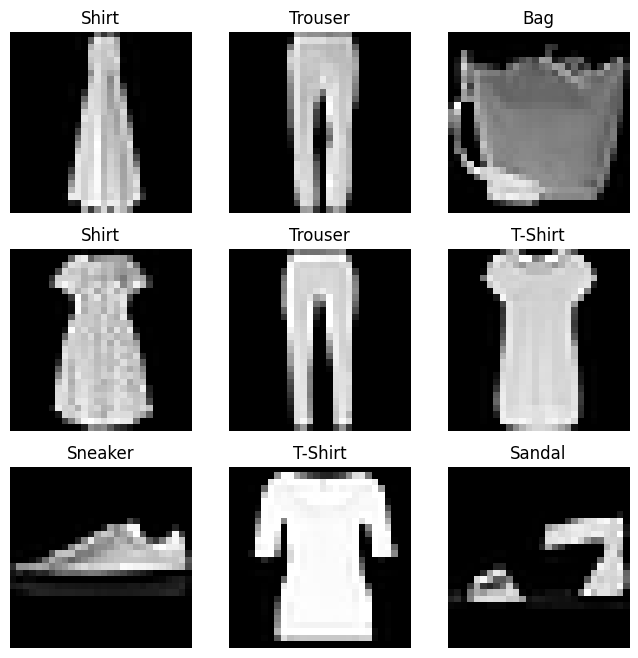

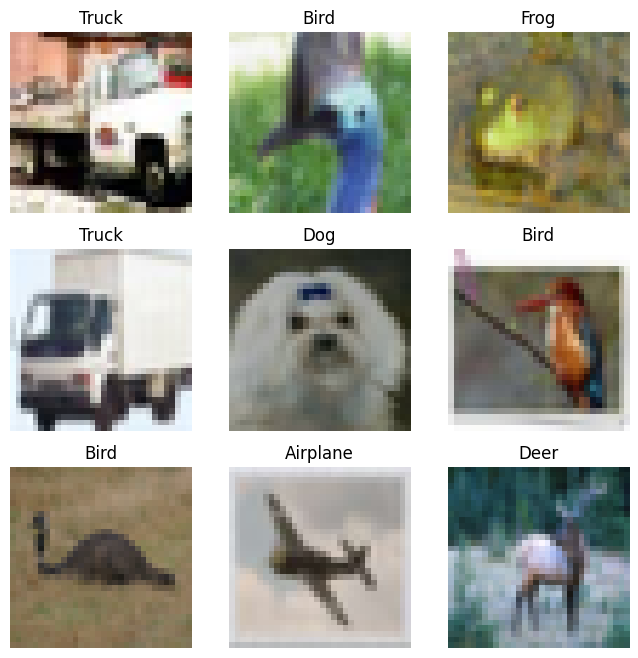

In [ ]:
show_mnist(training_data_mnist)
show_cifar(training_data_cifar)

# Task 2: Implement a Multilayer Perceptron

### A. Until Classes For MLP Usage


> - Define the Derivative functions for Forward Pass
- Define the Prime Derivative functions for Backward Pass
- Define some evaluation measures



In [ ]:
# until classes
def relu(x):
    return np.maximum(0, x)


def relu_prime(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(a):
    return a * (1 - a)


def soft_plus(x):
    x = np.clip(x, -20, 20)  # prevent overflow
    return np.log(1 + np.exp(x))


def soft_plus_prime(x):
    return 1 / (1 + np.exp(-x))


def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return probabilities


def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss


def evaluate_acc(y_true, y_pred):
    # Calculate accuracy (assuming one-hot encoding for y_true and y_pred)
    correct_predictions = np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))
    total_samples = y_true.shape[0]
    return correct_predictions / total_samples

def train_val_split(images, labels, val_fraction=0.2, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    num_samples = len(images)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    val_size = int(val_fraction * num_samples)

    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    val_images, val_labels = images[val_indices], labels[val_indices]
    train_images, train_labels = images[train_indices], labels[train_indices]

    return train_images, val_images, train_labels, val_labels


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Set up the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training vs. Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training and validation accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training vs. Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

### B. The Optimizer of Mini-Batch SGD


> Help for implementing the Mini-Batch SGD in the MLP



In [ ]:
class MiniBatchSGD:
    def __init__(self, lr, batch_size, rs=None):
        self.lr = lr
        self.batch_size = batch_size
        self.random_seed = rs

    def update(self, model_, x_, y_):
        num_samples_ = x_.shape[0]
        # FIX: num_batches
        num_batches = 0
        # num_batches = num_samples_ // self.batch_size

        total_loss = 0.0

        if self.random_seed is not None:
            # Set the random seed for shuffling
            np.random.seed(self.random_seed)

        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples_)
        x_ = x_[permutation]
        y_ = y_[permutation]

        for i in range(0, num_samples_, self.batch_size):
            x_batch = x_[i:i + self.batch_size]
            y_batch = y_[i:i + self.batch_size]
            loss = model_.backward_pass(x_batch, y_batch, self.lr)
            total_loss += loss
            # FIX: num_batches
            num_batches += 1

        average_loss = total_loss / num_batches
        return average_loss


### C. The MLP Main Structure


Initialization:
- Specifies activation function, layer sizes, and weight initialization method.
- Initializes weights and biases based on the provided method.

Activations:
- Supports relu, sigmoid, and soft_plus activation functions and their derivatives.

Forward Pass:
- Computes activations for each layer.
- Uses softmax for the output layer if there are hidden layers present, otherwise directly applies softmax.

Backward Pass:
- Computes the error and gradients for each layer.
- Updates weights and biases using the calculated gradients.

Training:
- Iteratively performs forward and backward passes.
- Computes both training and validation losses and accuracies.
- Supports integration with an optimizer class.

Prediction:
- Computes the softmax outputs for given inputs.



In [ ]:
class MLP:
    def __init__(self, activation_name, hidden_layers_sizes, input_sizes, output_sizes, weight_init):
        self.activation_name = activation_name
        self.hidden_layers_sizes = hidden_layers_sizes
        self.input_sizes = input_sizes
        self.output_sizes = output_sizes
        self.weights = []
        self.biases = []
        self.activations = []
        self.weight_init = weight_init  # 'zeros'/ 'uniform'/ 'gaussian'/ 'xavier'/ 'kaiming'

        # init the network structure here
        self.init_parameters()

    def init_parameters(self):
        layer_sizes = [self.input_sizes] + self.hidden_layers_sizes + [self.output_sizes]
        print(layer_sizes)
        for i in range(1, len(layer_sizes)):
            # weight init
            if self.weight_init == 'zeros':
                weight_matrix = np.zeros((layer_sizes[i - 1], layer_sizes[i]))
            elif self.weight_init == 'uniform':
                weight_matrix = np.random.uniform(-1, 1, (layer_sizes[i - 1], layer_sizes[i]))
            elif self.weight_init == 'gaussian':
                weight_matrix = np.random.randn(layer_sizes[i - 1], layer_sizes[i])
            elif self.weight_init == 'xavier':
                weight_matrix = np.random.randn(layer_sizes[i - 1], layer_sizes[i]) / np.sqrt(layer_sizes[i - 1])
            elif self.weight_init == 'kaiming':
                weight_matrix = np.random.randn(layer_sizes[i - 1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i - 1])
            else:
                raise ValueError("Unsupported initialization type.")

            # Fix bias
            bias_vector = np.ones((1, layer_sizes[i]))
            # bias_vector = np.zeros((1, layer_sizes[i]))
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    def activation_func(self, x):
        if self.activation_name == 'relu':
            return relu(x)
        elif self.activation_name == 'sigmoid':
            return sigmoid(x)
        elif self.activation_name == 'soft_plus':
            return soft_plus(x)
        else:
            raise ValueError("Not Defined Activation Function")

    def activation_prime_func(self, x):
        if self.activation_name == 'relu':
            return relu_prime(x)
        elif self.activation_name == 'sigmoid':
            return sigmoid_prime(x)
        elif self.activation_name == 'soft_plus':
            return soft_plus_prime(x)
        else:
            raise ValueError("Not Defined Activation Function")

    def forward_pass(self, x):
        self.activations = [x]

        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(self.activations[-1], weight) + bias

            # If it's last weight matrix and no hidden layers
            # skip the activation and directly apply softmax
            if len(self.hidden_layers_sizes) == 0 and len(self.weights) == 1:
                self.activations.append(softmax(z))
            else:
                a = self.activation_func(z)
                # store the current output of the active layer
                self.activations.append(a)

        # if there are hidden layers, apply softmax in the last layer
        if len(self.hidden_layers_sizes) > 0:
            self.activations.append(softmax(self.activations[-1]))

        return self.activations[-1]

    def backward_pass(self, x, y, lr=0.01):
        y_pred = self.forward_pass(x)
        loss = cross_entropy_loss(y, y_pred)

        # Initialize the error in the final layer
        dL_dz_final = (y_pred - y) / y_pred.shape[0] # d CE/ d softmax

        gradients_w = []
        gradients_b = []

        # Calculate the gradient for all layers first
        for i in range(len(self.biases) - 1, -1, -1):
            # If there are no hidden layers, skip the multiplication with the activation derivative.
            if len(self.hidden_layers_sizes) == 0 and len(self.biases) == 1:
                dL_dz = dL_dz_final
            else:
                dL_dz = dL_dz_final * self.activation_prime_func(self.activations[i + 1])

            dL_dw = np.dot(self.activations[i].T, dL_dz)
            dL_db = np.sum(dL_dz, axis=0, keepdims=True)

            gradients_w.insert(0, dL_dw)
            gradients_b.insert(0, dL_db)

            dL_dz_final = np.dot(dL_dz, self.weights[i].T)

        # Update the weights and biases
        for i in range(len(self.biases)):
            self.weights[i] -= lr * gradients_w[i]
            self.biases[i] -= lr * gradients_b[i]

        return loss

    def fit(self, X_train, y_train, X_val, y_val, num_of_epoch, optimizer_class):
        # start training here
        train_losses = []
        val_losses = []
        train_accuracy = []
        val_accuracy = []

        # FIX: add tqdm
        for ep in tqdm(range(num_of_epoch)):
            average_loss = optimizer_class.update(self, X_train, y_train)

            # Calculate training data accuracy
            y_pred = self.predict(X_train)
            train_acc = evaluate_acc(y_true=y_train, y_pred=y_pred)

            # Calculate validation data accuracy
            val_pred = self.predict(X_val)
            val_loss = cross_entropy_loss(y_val, val_pred)
            val_acc = evaluate_acc(y_true=y_val, y_pred=val_pred)

            # Print results for the epoch
            print(f'Epoch {ep + 1}/{num_of_epoch}')
            print(f'Train Loss: {average_loss:.4f}, Train Accuracy: {train_acc * 100:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%')
            print('-' * 50)

            # store the values for printing purpose
            train_losses.append(average_loss)
            val_losses.append(val_loss)
            train_accuracy.append(train_acc)
            val_accuracy.append(val_acc)

        return train_losses, val_losses, train_accuracy, val_accuracy

    def predict(self, X):
        output_softmax = self.forward_pass(X)
        return output_softmax

### D. One Hot Encoding of the dataset


> There are 10 types of the classes for the Mnist Data



In [ ]:
# X_train_mnist, X_val_mnist, X_test_mnist, y_train_mnist, y_val_mnist, y_test_mnist
# Fix hard code num_classes
num_classes = len(np.unique(y_train_mnist))
# num_classes = 10
y_train_mnist = np.eye(num_classes)[y_train_mnist]
y_val_mnist = np.eye(num_classes)[y_val_mnist]
y_test_mnist = np.eye(num_classes)[y_test_mnist]

### E. Self-Testing on Sigmoid Activation

[784, 128, 64, 10]


 10%|█         | 1/10 [00:01<00:16,  1.88s/it]

Epoch 1/10
Train Loss: 1.6935, Train Accuracy: 68.48%
Val Loss: 1.6378, Val Accuracy: 67.64%
--------------------------------------------------


 20%|██        | 2/10 [00:03<00:14,  1.85s/it]

Epoch 2/10
Train Loss: 1.6225, Train Accuracy: 78.69%
Val Loss: 1.6197, Val Accuracy: 77.22%
--------------------------------------------------


 30%|███       | 3/10 [00:05<00:13,  1.86s/it]

Epoch 3/10
Train Loss: 1.6072, Train Accuracy: 79.84%
Val Loss: 1.6126, Val Accuracy: 78.25%
--------------------------------------------------


 40%|████      | 4/10 [00:08<00:14,  2.43s/it]

Epoch 4/10
Train Loss: 1.5890, Train Accuracy: 81.75%
Val Loss: 1.5950, Val Accuracy: 80.73%
--------------------------------------------------


 50%|█████     | 5/10 [00:10<00:11,  2.22s/it]

Epoch 5/10
Train Loss: 1.5837, Train Accuracy: 82.56%
Val Loss: 1.5892, Val Accuracy: 81.33%
--------------------------------------------------


 60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

Epoch 6/10
Train Loss: 1.5784, Train Accuracy: 82.67%
Val Loss: 1.5922, Val Accuracy: 81.48%
--------------------------------------------------


 70%|███████   | 7/10 [00:14<00:05,  1.99s/it]

Epoch 7/10
Train Loss: 1.5730, Train Accuracy: 83.68%
Val Loss: 1.5807, Val Accuracy: 82.15%
--------------------------------------------------


 80%|████████  | 8/10 [00:16<00:03,  1.93s/it]

Epoch 8/10
Train Loss: 1.5698, Train Accuracy: 83.66%
Val Loss: 1.5810, Val Accuracy: 82.26%
--------------------------------------------------


 90%|█████████ | 9/10 [00:17<00:01,  1.90s/it]

Epoch 9/10
Train Loss: 1.5675, Train Accuracy: 84.32%
Val Loss: 1.5772, Val Accuracy: 82.98%
--------------------------------------------------


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

Epoch 10/10
Train Loss: 1.5648, Train Accuracy: 84.05%
Val Loss: 1.5751, Val Accuracy: 82.79%
--------------------------------------------------
The Test Accuracy: 82.16%
--------------------------------------------------


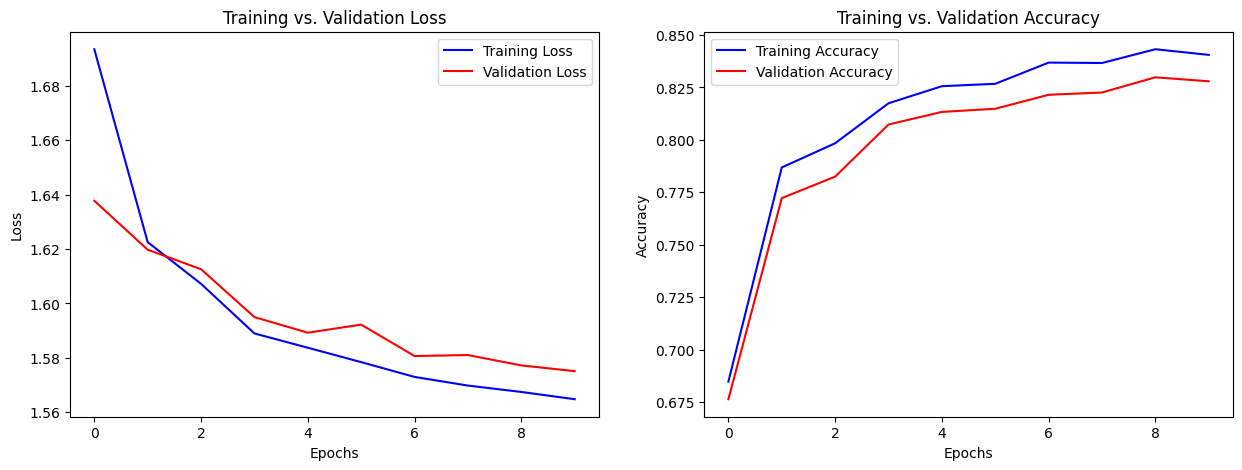

In [ ]:
# Initialize your MLP model
model = MLP(activation_name='sigmoid',
            hidden_layers_sizes=[128, 64],
            input_sizes=X_train_mnist.shape[1],
            output_sizes=y_train_mnist.shape[1],
            weight_init='gaussian'
            )

# Train the model with batches
optimizer = MiniBatchSGD(lr=0.1, batch_size=128, rs=42)
train_losses, val_losses, train_accuracy, val_accuracy = model.fit(
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    num_of_epoch=10,
    optimizer_class=optimizer
)

# Print the test accuracy
y_pred = model.predict(X_test_mnist)
test_acc = evaluate_acc(y_true=y_test_mnist, y_pred=y_pred)
test_acc_percentage = test_acc * 100
print(f"The Test Accuracy: {test_acc_percentage}%")
print('-' * 50)

# Plot the loss and accuracy graph
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

### F. Self-Testing on ReLu Activation

[784, 128, 64, 10]


 10%|█         | 1/10 [00:03<00:27,  3.06s/it]

Epoch 1/10
Train Loss: 0.8826, Train Accuracy: 73.46%
Val Loss: 0.7123, Val Accuracy: 73.05%
--------------------------------------------------


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

Epoch 2/10
Train Loss: 0.5077, Train Accuracy: 84.47%
Val Loss: 0.4380, Val Accuracy: 83.93%
--------------------------------------------------


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Epoch 3/10
Train Loss: 0.4283, Train Accuracy: 85.57%
Val Loss: 0.4098, Val Accuracy: 84.88%
--------------------------------------------------


 40%|████      | 4/10 [00:11<00:18,  3.03s/it]

Epoch 4/10
Train Loss: 0.4025, Train Accuracy: 86.16%
Val Loss: 0.3927, Val Accuracy: 85.44%
--------------------------------------------------


 50%|█████     | 5/10 [00:15<00:16,  3.23s/it]

Epoch 5/10
Train Loss: 0.3846, Train Accuracy: 86.70%
Val Loss: 0.3808, Val Accuracy: 86.00%
--------------------------------------------------


 60%|██████    | 6/10 [00:18<00:12,  3.06s/it]

Epoch 6/10
Train Loss: 0.3708, Train Accuracy: 87.16%
Val Loss: 0.3718, Val Accuracy: 86.28%
--------------------------------------------------


 70%|███████   | 7/10 [00:20<00:08,  2.96s/it]

Epoch 7/10
Train Loss: 0.3595, Train Accuracy: 87.53%
Val Loss: 0.3647, Val Accuracy: 86.48%
--------------------------------------------------


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

Epoch 8/10
Train Loss: 0.3498, Train Accuracy: 87.85%
Val Loss: 0.3589, Val Accuracy: 86.67%
--------------------------------------------------


 90%|█████████ | 9/10 [00:28<00:03,  3.38s/it]

Epoch 9/10
Train Loss: 0.3414, Train Accuracy: 88.16%
Val Loss: 0.3542, Val Accuracy: 86.80%
--------------------------------------------------


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

Epoch 10/10
Train Loss: 0.3338, Train Accuracy: 88.37%
Val Loss: 0.3501, Val Accuracy: 87.02%
--------------------------------------------------
The Test Accuracy: 85.77%
--------------------------------------------------


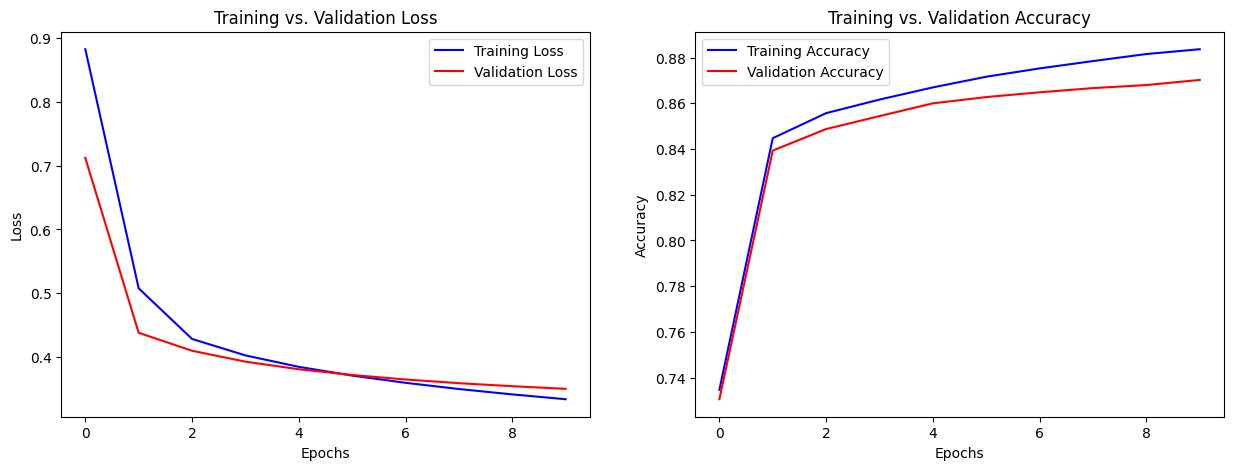

In [ ]:
# Initialize your MLP model
model = MLP(activation_name='relu',
            hidden_layers_sizes=[128, 64],
            input_sizes=X_train_mnist.shape[1],
            output_sizes=y_train_mnist.shape[1],
            weight_init='kaiming'
            )

# Train the model with batches
optimizer = MiniBatchSGD(lr=0.01, batch_size=128, rs=42)
train_losses, val_losses, train_accuracy, val_accuracy = model.fit(
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    num_of_epoch=10,
    optimizer_class=optimizer
)


# Print the test accuracy
y_pred = model.predict(X_test_mnist)
test_acc = evaluate_acc(y_true=y_test_mnist, y_pred=y_pred)
test_acc_percentage = test_acc * 100
print(f"The Test Accuracy: {test_acc_percentage}%")
print('-' * 50)

# Plot the loss and accuracy graph
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

### G. Self-Testing on SoftPlus

[784, 128, 64, 10]


 10%|█         | 1/10 [00:04<00:38,  4.31s/it]

Epoch 1/10
Train Loss: 0.6944, Train Accuracy: 81.48%
Val Loss: 0.5149, Val Accuracy: 81.31%
--------------------------------------------------


 20%|██        | 2/10 [00:11<00:49,  6.19s/it]

Epoch 2/10
Train Loss: 0.4982, Train Accuracy: 83.39%
Val Loss: 0.4613, Val Accuracy: 83.13%
--------------------------------------------------


 30%|███       | 3/10 [00:15<00:35,  5.10s/it]

Epoch 3/10
Train Loss: 0.4595, Train Accuracy: 84.33%
Val Loss: 0.4360, Val Accuracy: 84.21%
--------------------------------------------------


 40%|████      | 4/10 [00:19<00:27,  4.60s/it]

Epoch 4/10
Train Loss: 0.4370, Train Accuracy: 84.96%
Val Loss: 0.4203, Val Accuracy: 84.73%
--------------------------------------------------


 50%|█████     | 5/10 [00:25<00:24,  4.95s/it]

Epoch 5/10
Train Loss: 0.4213, Train Accuracy: 85.45%
Val Loss: 0.4090, Val Accuracy: 85.29%
--------------------------------------------------


 60%|██████    | 6/10 [00:29<00:19,  4.93s/it]

Epoch 6/10
Train Loss: 0.4092, Train Accuracy: 85.84%
Val Loss: 0.4002, Val Accuracy: 85.51%
--------------------------------------------------


 70%|███████   | 7/10 [00:33<00:13,  4.56s/it]

Epoch 7/10
Train Loss: 0.3993, Train Accuracy: 86.11%
Val Loss: 0.3931, Val Accuracy: 85.74%
--------------------------------------------------


 80%|████████  | 8/10 [00:39<00:09,  4.83s/it]

Epoch 8/10
Train Loss: 0.3909, Train Accuracy: 86.36%
Val Loss: 0.3872, Val Accuracy: 85.90%
--------------------------------------------------


 90%|█████████ | 9/10 [00:42<00:04,  4.50s/it]

Epoch 9/10
Train Loss: 0.3837, Train Accuracy: 86.56%
Val Loss: 0.3820, Val Accuracy: 86.17%
--------------------------------------------------


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]

Epoch 10/10
Train Loss: 0.3773, Train Accuracy: 86.75%
Val Loss: 0.3776, Val Accuracy: 86.22%
--------------------------------------------------


The Test Accuracy: 84.78%
--------------------------------------------------


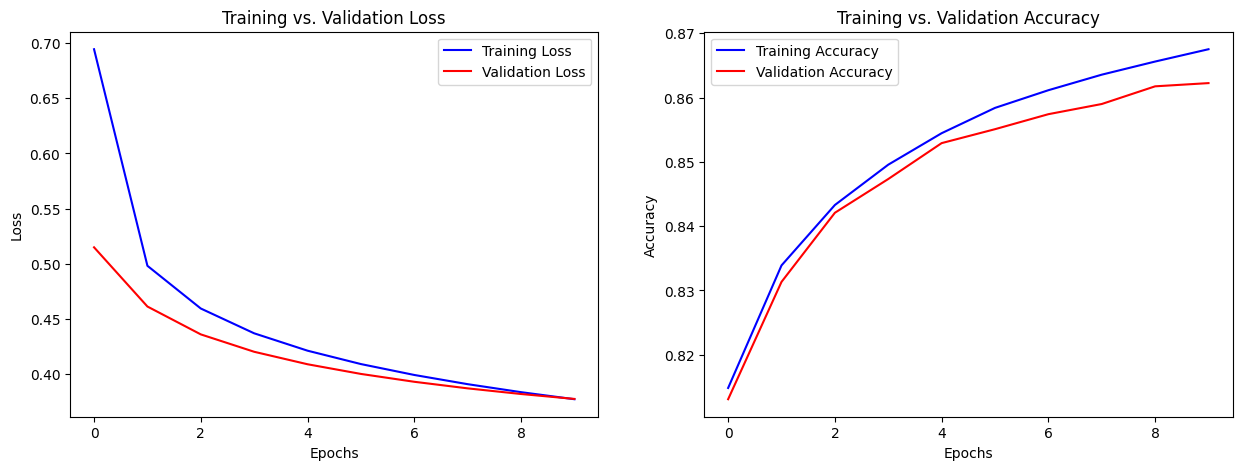

In [ ]:
# Initialize your MLP model
model = MLP(activation_name='soft_plus',
            hidden_layers_sizes=[128, 64],
            input_sizes=X_train_mnist.shape[1],
            output_sizes=y_train_mnist.shape[1],
            weight_init='kaiming'
            )

# Train the model with batches
optimizer = MiniBatchSGD(lr=0.01, batch_size=128, rs=42)
train_losses, val_losses, train_accuracy, val_accuracy = model.fit(
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    num_of_epoch=10,
    optimizer_class=optimizer
)


# Print the test accuracy
y_pred = model.predict(X_test_mnist)
test_acc = evaluate_acc(y_true=y_test_mnist, y_pred=y_pred)
test_acc_percentage = test_acc * 100
print(f"The Test Accuracy: {test_acc_percentage}%")
print('-' * 50)

# Plot the loss and accuracy graph
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

# Task 3: Experiments

## 3.1 Experiment With Initializing Model Weights


> - Testing on 'zeros', 'uniform', 'gaussian', 'xavier', 'kaiming'
- Plotting Training Curve and Test Accuracy Comparison
- We have done the experiment in three activations



In [ ]:
def weight_initialization_experiment(activation, hidden_layers_sizes, epochs, X_train, y_train, X_val, y_val, X_test, y_test, lr=0.1, batch_size=128):
    weight_inits = ['zeros', 'uniform', 'gaussian', 'xavier', 'kaiming']
    training_curves = {}
    test_accuracies = {}

    for init in weight_inits:
        print(f"Training with {init} initialization...")
        # Initialize the MLP model
        model = MLP(activation_name=activation,
                    hidden_layers_sizes=hidden_layers_sizes,
                    input_sizes=X_train.shape[1],
                    output_sizes=y_train.shape[1],
                    weight_init=init)

        # Train the model
        optimizer = MiniBatchSGD(lr=lr, batch_size=batch_size, rs=42)
        train_losses, _, _, _ = model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            num_of_epoch=epochs,
            optimizer_class=optimizer
        )

        # Store training loss for plotting
        training_curves[init] = train_losses

        # Evaluate on test set
        y_pred = model.predict(X_test)
        test_acc = evaluate_acc(y_test, y_pred)
        test_accuracies[init] = test_acc

    # Plot training curves
    plt.figure(figsize=(12, 6))
    for init, curve in training_curves.items():
        plt.plot(curve, label=init)
    plt.title("Training Loss Curves for Different Weight Initializations")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot test accuracies
    plt.figure(figsize=(12, 6))
    names = list(test_accuracies.keys())
    values = list(test_accuracies.values())
    plt.bar(names, values, color=['blue', 'green', 'red', 'purple', 'cyan'])
    plt.title("Test Accuracy for Different Weight Initializations")
    plt.xlabel("Weight Initialization Methods")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  # to scale the y-axis between 0 and 1
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()

### A. Testing On Sigmoid Activation


> - Assume the learning rate is 0.1 and epochs are 10
- zero weight init is the worst while the other inits have the similar performance getting of the accuracy around 0.83-0.85 with similar training curves
- Relatively, we will choose "Kaiming" as the weight init method with a better learning performance



Training with zeros initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:04<00:37,  4.17s/it]

Epoch 1/10
Train Loss: 2.0117, Train Accuracy: 17.61%
Val Loss: 1.9474, Val Accuracy: 17.77%
--------------------------------------------------


 20%|██        | 2/10 [00:06<00:26,  3.28s/it]

Epoch 2/10
Train Loss: 1.9705, Train Accuracy: 15.78%
Val Loss: 1.9587, Val Accuracy: 15.15%
--------------------------------------------------


 30%|███       | 3/10 [00:09<00:20,  2.99s/it]

Epoch 3/10
Train Loss: 1.9637, Train Accuracy: 16.96%
Val Loss: 1.9377, Val Accuracy: 16.51%
--------------------------------------------------


 40%|████      | 4/10 [00:12<00:17,  2.88s/it]

Epoch 4/10
Train Loss: 1.9586, Train Accuracy: 18.70%
Val Loss: 1.9922, Val Accuracy: 18.66%
--------------------------------------------------


 50%|█████     | 5/10 [00:16<00:16,  3.38s/it]

Epoch 5/10
Train Loss: 1.9540, Train Accuracy: 16.29%
Val Loss: 1.9313, Val Accuracy: 15.54%
--------------------------------------------------


 60%|██████    | 6/10 [00:19<00:12,  3.16s/it]

Epoch 6/10
Train Loss: 1.9518, Train Accuracy: 16.33%
Val Loss: 1.9323, Val Accuracy: 15.57%
--------------------------------------------------


 70%|███████   | 7/10 [00:21<00:09,  3.00s/it]

Epoch 7/10
Train Loss: 1.9503, Train Accuracy: 17.87%
Val Loss: 1.9474, Val Accuracy: 17.47%
--------------------------------------------------


 80%|████████  | 8/10 [00:24<00:05,  2.90s/it]

Epoch 8/10
Train Loss: 1.9496, Train Accuracy: 17.85%
Val Loss: 1.9397, Val Accuracy: 17.49%
--------------------------------------------------


 90%|█████████ | 9/10 [00:28<00:03,  3.24s/it]

Epoch 9/10
Train Loss: 1.9466, Train Accuracy: 17.28%
Val Loss: 1.9468, Val Accuracy: 16.81%
--------------------------------------------------


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


Epoch 10/10
Train Loss: 1.9478, Train Accuracy: 16.18%
Val Loss: 1.9369, Val Accuracy: 15.35%
--------------------------------------------------
Training with uniform initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:02<00:25,  2.86s/it]

Epoch 1/10
Train Loss: 1.6520, Train Accuracy: 79.68%
Val Loss: 1.5966, Val Accuracy: 79.89%
--------------------------------------------------


 20%|██        | 2/10 [00:10<00:45,  5.72s/it]

Epoch 2/10
Train Loss: 1.5907, Train Accuracy: 81.88%
Val Loss: 1.5850, Val Accuracy: 81.18%
--------------------------------------------------


 30%|███       | 3/10 [00:13<00:30,  4.36s/it]

Epoch 3/10
Train Loss: 1.5769, Train Accuracy: 83.60%
Val Loss: 1.5754, Val Accuracy: 83.43%
--------------------------------------------------


 40%|████      | 4/10 [00:16<00:22,  3.73s/it]

Epoch 4/10
Train Loss: 1.5694, Train Accuracy: 84.21%
Val Loss: 1.5718, Val Accuracy: 83.47%
--------------------------------------------------


 50%|█████     | 5/10 [00:18<00:16,  3.38s/it]

Epoch 5/10
Train Loss: 1.5637, Train Accuracy: 83.47%
Val Loss: 1.5722, Val Accuracy: 82.81%
--------------------------------------------------


 60%|██████    | 6/10 [00:22<00:13,  3.42s/it]

Epoch 6/10
Train Loss: 1.5589, Train Accuracy: 84.76%
Val Loss: 1.5677, Val Accuracy: 84.03%
--------------------------------------------------


 70%|███████   | 7/10 [00:25<00:10,  3.38s/it]

Epoch 7/10
Train Loss: 1.5578, Train Accuracy: 85.40%
Val Loss: 1.5700, Val Accuracy: 84.40%
--------------------------------------------------


 80%|████████  | 8/10 [00:28<00:06,  3.17s/it]

Epoch 8/10
Train Loss: 1.5539, Train Accuracy: 86.21%
Val Loss: 1.5637, Val Accuracy: 85.10%
--------------------------------------------------


 90%|█████████ | 9/10 [00:31<00:03,  3.03s/it]

Epoch 9/10
Train Loss: 1.5524, Train Accuracy: 86.28%
Val Loss: 1.5648, Val Accuracy: 85.35%
--------------------------------------------------


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]

Epoch 10/10
Train Loss: 1.5508, Train Accuracy: 86.45%
Val Loss: 1.5610, Val Accuracy: 85.30%
--------------------------------------------------


Training with gaussian initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:03<00:35,  3.96s/it]

Epoch 1/10
Train Loss: 1.6972, Train Accuracy: 77.29%
Val Loss: 1.6208, Val Accuracy: 77.12%
--------------------------------------------------


 20%|██        | 2/10 [00:06<00:26,  3.25s/it]

Epoch 2/10
Train Loss: 1.6093, Train Accuracy: 80.48%
Val Loss: 1.6024, Val Accuracy: 80.24%
--------------------------------------------------


 30%|███       | 3/10 [00:09<00:21,  3.02s/it]

Epoch 3/10
Train Loss: 1.5929, Train Accuracy: 81.09%
Val Loss: 1.5915, Val Accuracy: 80.91%
--------------------------------------------------


 40%|████      | 4/10 [00:12<00:17,  2.89s/it]

Epoch 4/10
Train Loss: 1.5836, Train Accuracy: 82.96%
Val Loss: 1.5852, Val Accuracy: 82.40%
--------------------------------------------------


 50%|█████     | 5/10 [00:16<00:17,  3.41s/it]

Epoch 5/10
Train Loss: 1.5762, Train Accuracy: 82.84%
Val Loss: 1.5830, Val Accuracy: 82.27%
--------------------------------------------------


 60%|██████    | 6/10 [00:19<00:12,  3.19s/it]

Epoch 6/10
Train Loss: 1.5715, Train Accuracy: 83.72%
Val Loss: 1.5770, Val Accuracy: 83.08%
--------------------------------------------------


 70%|███████   | 7/10 [00:21<00:09,  3.04s/it]

Epoch 7/10
Train Loss: 1.5683, Train Accuracy: 83.57%
Val Loss: 1.5780, Val Accuracy: 83.09%
--------------------------------------------------


 80%|████████  | 8/10 [00:24<00:05,  2.94s/it]

Epoch 8/10
Train Loss: 1.5659, Train Accuracy: 84.59%
Val Loss: 1.5723, Val Accuracy: 83.78%
--------------------------------------------------


 90%|█████████ | 9/10 [00:30<00:03,  3.70s/it]

Epoch 9/10
Train Loss: 1.5628, Train Accuracy: 84.72%
Val Loss: 1.5718, Val Accuracy: 83.79%
--------------------------------------------------


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Epoch 10/10
Train Loss: 1.5607, Train Accuracy: 85.02%
Val Loss: 1.5685, Val Accuracy: 84.01%
--------------------------------------------------
Training with xavier initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

Epoch 1/10
Train Loss: 1.6426, Train Accuracy: 78.61%
Val Loss: 1.5935, Val Accuracy: 78.60%
--------------------------------------------------


 20%|██        | 2/10 [00:13<00:54,  6.87s/it]

Epoch 2/10
Train Loss: 1.5814, Train Accuracy: 84.14%
Val Loss: 1.5690, Val Accuracy: 84.11%
--------------------------------------------------


 30%|███       | 3/10 [00:19<00:45,  6.45s/it]

Epoch 3/10
Train Loss: 1.5656, Train Accuracy: 85.18%
Val Loss: 1.5671, Val Accuracy: 84.79%
--------------------------------------------------


 40%|████      | 4/10 [00:22<00:32,  5.34s/it]

Epoch 4/10
Train Loss: 1.5584, Train Accuracy: 85.53%
Val Loss: 1.5612, Val Accuracy: 84.84%
--------------------------------------------------


 50%|█████     | 5/10 [00:26<00:23,  4.60s/it]

Epoch 5/10
Train Loss: 1.5536, Train Accuracy: 86.22%
Val Loss: 1.5576, Val Accuracy: 85.77%
--------------------------------------------------


 60%|██████    | 6/10 [00:28<00:15,  3.94s/it]

Epoch 6/10
Train Loss: 1.5512, Train Accuracy: 86.35%
Val Loss: 1.5559, Val Accuracy: 85.62%
--------------------------------------------------


 70%|███████   | 7/10 [00:31<00:10,  3.53s/it]

Epoch 7/10
Train Loss: 1.5488, Train Accuracy: 86.86%
Val Loss: 1.5529, Val Accuracy: 86.05%
--------------------------------------------------


 80%|████████  | 8/10 [00:34<00:06,  3.33s/it]

Epoch 8/10
Train Loss: 1.5475, Train Accuracy: 86.47%
Val Loss: 1.5563, Val Accuracy: 85.35%
--------------------------------------------------


 90%|█████████ | 9/10 [00:38<00:03,  3.60s/it]

Epoch 9/10
Train Loss: 1.5457, Train Accuracy: 87.20%
Val Loss: 1.5542, Val Accuracy: 86.16%
--------------------------------------------------


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


Epoch 10/10
Train Loss: 1.5435, Train Accuracy: 87.08%
Val Loss: 1.5550, Val Accuracy: 86.20%
--------------------------------------------------
Training with kaiming initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:02<00:24,  2.70s/it]

Epoch 1/10
Train Loss: 1.6412, Train Accuracy: 80.61%
Val Loss: 1.5794, Val Accuracy: 80.48%
--------------------------------------------------


 20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Epoch 2/10
Train Loss: 1.5787, Train Accuracy: 82.87%
Val Loss: 1.5730, Val Accuracy: 82.88%
--------------------------------------------------


 30%|███       | 3/10 [00:09<00:24,  3.52s/it]

Epoch 3/10
Train Loss: 1.5672, Train Accuracy: 84.66%
Val Loss: 1.5655, Val Accuracy: 84.52%
--------------------------------------------------


 40%|████      | 4/10 [00:13<00:20,  3.39s/it]

Epoch 4/10
Train Loss: 1.5592, Train Accuracy: 85.73%
Val Loss: 1.5581, Val Accuracy: 85.42%
--------------------------------------------------


 50%|█████     | 5/10 [00:16<00:16,  3.23s/it]

Epoch 5/10
Train Loss: 1.5551, Train Accuracy: 85.86%
Val Loss: 1.5590, Val Accuracy: 85.24%
--------------------------------------------------


 60%|██████    | 6/10 [00:18<00:12,  3.08s/it]

Epoch 6/10
Train Loss: 1.5519, Train Accuracy: 85.92%
Val Loss: 1.5600, Val Accuracy: 84.87%
--------------------------------------------------


 70%|███████   | 7/10 [00:23<00:10,  3.51s/it]

Epoch 7/10
Train Loss: 1.5505, Train Accuracy: 86.44%
Val Loss: 1.5566, Val Accuracy: 85.55%
--------------------------------------------------


 80%|████████  | 8/10 [00:25<00:06,  3.25s/it]

Epoch 8/10
Train Loss: 1.5477, Train Accuracy: 87.08%
Val Loss: 1.5547, Val Accuracy: 86.28%
--------------------------------------------------


 90%|█████████ | 9/10 [00:28<00:03,  3.08s/it]

Epoch 9/10
Train Loss: 1.5455, Train Accuracy: 86.70%
Val Loss: 1.5554, Val Accuracy: 85.90%
--------------------------------------------------


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]

Epoch 10/10
Train Loss: 1.5441, Train Accuracy: 87.22%
Val Loss: 1.5552, Val Accuracy: 85.91%
--------------------------------------------------


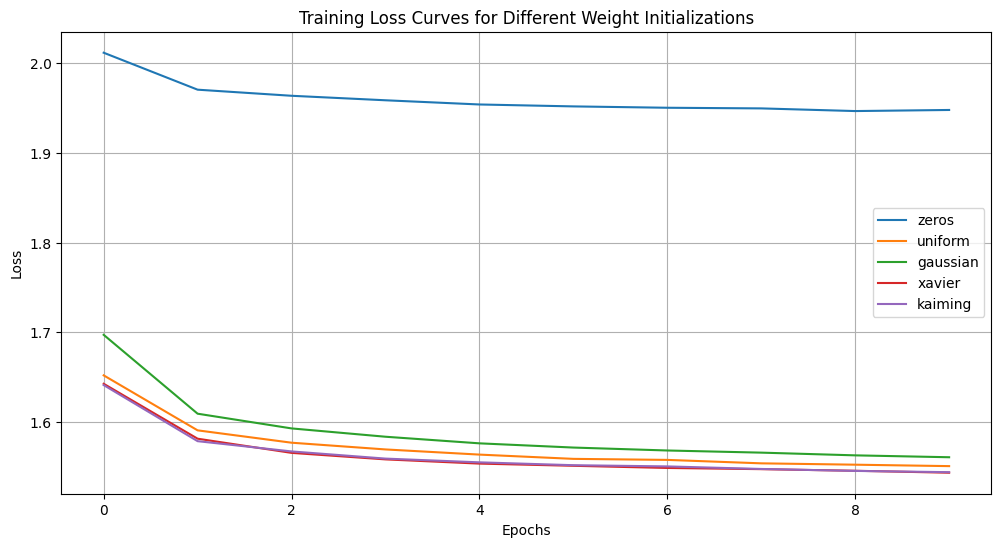

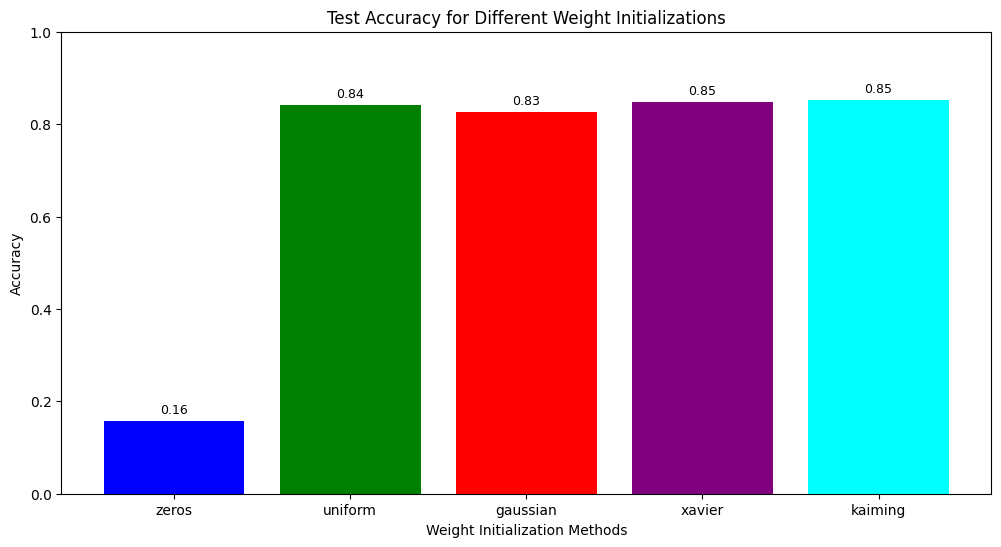

In [ ]:
weight_initialization_experiment(
    activation='sigmoid',
    hidden_layers_sizes=[128],
    lr=0.1,
    batch_size=128,
    epochs=10,
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    X_test=X_test_mnist,
    y_test=y_test_mnist
)

### B. Testing On ReLu Activation


> - Assume the learning rate is 0.0001 and epochs are 10
- The weight Init method (zeros, uniform, Gaussian) got the bad performance, but the "Xavier" and "Kaiming" get the similarly great performance with the accuracy of 0.85
- "Xavier" and "Kaiming" are the best choice for ReLu



Training with zeros initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:04<00:36,  4.10s/it]

Epoch 1/10
Train Loss: 2.3050, Train Accuracy: 10.01%
Val Loss: 2.2965, Val Accuracy: 9.97%
--------------------------------------------------


 20%|██        | 2/10 [00:06<00:25,  3.15s/it]

Epoch 2/10
Train Loss: 2.1296, Train Accuracy: 20.24%
Val Loss: 1.9738, Val Accuracy: 19.91%
--------------------------------------------------


 30%|███       | 3/10 [00:09<00:19,  2.82s/it]

Epoch 3/10
Train Loss: 1.9060, Train Accuracy: 21.42%
Val Loss: 1.8542, Val Accuracy: 21.35%
--------------------------------------------------


 40%|████      | 4/10 [00:11<00:16,  2.68s/it]

Epoch 4/10
Train Loss: 1.8148, Train Accuracy: 24.40%
Val Loss: 1.7807, Val Accuracy: 24.19%
--------------------------------------------------


 50%|█████     | 5/10 [00:14<00:13,  2.74s/it]

Epoch 5/10
Train Loss: 1.7528, Train Accuracy: 26.32%
Val Loss: 1.7281, Val Accuracy: 26.44%
--------------------------------------------------


 60%|██████    | 6/10 [00:18<00:12,  3.06s/it]

Epoch 6/10
Train Loss: 1.7089, Train Accuracy: 27.39%
Val Loss: 1.6896, Val Accuracy: 27.46%
--------------------------------------------------


 70%|███████   | 7/10 [00:20<00:08,  2.85s/it]

Epoch 7/10
Train Loss: 1.6741, Train Accuracy: 28.36%
Val Loss: 1.6572, Val Accuracy: 28.21%
--------------------------------------------------


 80%|████████  | 8/10 [00:22<00:05,  2.70s/it]

Epoch 8/10
Train Loss: 1.6448, Train Accuracy: 29.17%
Val Loss: 1.6300, Val Accuracy: 29.20%
--------------------------------------------------


 90%|█████████ | 9/10 [00:25<00:02,  2.61s/it]

Epoch 9/10
Train Loss: 1.6204, Train Accuracy: 29.92%
Val Loss: 1.6071, Val Accuracy: 30.00%
--------------------------------------------------


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


Epoch 10/10
Train Loss: 1.5992, Train Accuracy: 30.78%
Val Loss: 1.5869, Val Accuracy: 30.77%
--------------------------------------------------
Training with uniform initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:02<00:26,  2.91s/it]

Epoch 1/10
Train Loss: 2.8961, Train Accuracy: 16.34%
Val Loss: 2.2606, Val Accuracy: 15.70%
--------------------------------------------------


 20%|██        | 2/10 [00:05<00:21,  2.63s/it]

Epoch 2/10
Train Loss: 2.2284, Train Accuracy: 18.25%
Val Loss: 2.2022, Val Accuracy: 17.62%
--------------------------------------------------


 30%|███       | 3/10 [00:07<00:17,  2.55s/it]

Epoch 3/10
Train Loss: 2.1707, Train Accuracy: 20.09%
Val Loss: 2.1553, Val Accuracy: 19.43%
--------------------------------------------------


 40%|████      | 4/10 [00:10<00:15,  2.53s/it]

Epoch 4/10
Train Loss: 2.1233, Train Accuracy: 22.69%
Val Loss: 2.1044, Val Accuracy: 22.01%
--------------------------------------------------


 50%|█████     | 5/10 [00:14<00:15,  3.08s/it]

Epoch 5/10
Train Loss: 2.0812, Train Accuracy: 23.64%
Val Loss: 2.0695, Val Accuracy: 23.03%
--------------------------------------------------


 60%|██████    | 6/10 [00:16<00:11,  2.86s/it]

Epoch 6/10
Train Loss: 2.0457, Train Accuracy: 24.91%
Val Loss: 2.0370, Val Accuracy: 24.44%
--------------------------------------------------


 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Epoch 7/10
Train Loss: 2.0165, Train Accuracy: 25.89%
Val Loss: 2.0129, Val Accuracy: 25.34%
--------------------------------------------------


 80%|████████  | 8/10 [00:21<00:05,  2.66s/it]

Epoch 8/10
Train Loss: 1.9923, Train Accuracy: 26.66%
Val Loss: 1.9928, Val Accuracy: 26.10%
--------------------------------------------------


 90%|█████████ | 9/10 [00:24<00:02,  2.63s/it]

Epoch 9/10
Train Loss: 1.9743, Train Accuracy: 27.41%
Val Loss: 1.9785, Val Accuracy: 26.85%
--------------------------------------------------


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


Epoch 10/10
Train Loss: 1.9613, Train Accuracy: 27.96%
Val Loss: 1.9638, Val Accuracy: 27.41%
--------------------------------------------------
Training with gaussian initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:02<00:22,  2.48s/it]

Epoch 1/10
Train Loss: 3.0568, Train Accuracy: 16.90%
Val Loss: 2.2115, Val Accuracy: 16.06%
--------------------------------------------------


 20%|██        | 2/10 [00:04<00:19,  2.45s/it]

Epoch 2/10
Train Loss: 2.1776, Train Accuracy: 18.02%
Val Loss: 2.1614, Val Accuracy: 17.46%
--------------------------------------------------


 30%|███       | 3/10 [00:07<00:17,  2.49s/it]

Epoch 3/10
Train Loss: 2.1499, Train Accuracy: 18.36%
Val Loss: 2.1463, Val Accuracy: 17.87%
--------------------------------------------------


 40%|████      | 4/10 [00:11<00:17,  2.93s/it]

Epoch 4/10
Train Loss: 2.1352, Train Accuracy: 18.70%
Val Loss: 2.1352, Val Accuracy: 18.18%
--------------------------------------------------


 50%|█████     | 5/10 [00:13<00:14,  2.89s/it]

Epoch 5/10
Train Loss: 2.1230, Train Accuracy: 18.69%
Val Loss: 2.1328, Val Accuracy: 18.16%
--------------------------------------------------


 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Epoch 6/10
Train Loss: 2.1160, Train Accuracy: 18.95%
Val Loss: 2.1255, Val Accuracy: 18.40%
--------------------------------------------------


 70%|███████   | 7/10 [00:18<00:07,  2.64s/it]

Epoch 7/10
Train Loss: 2.1087, Train Accuracy: 19.30%
Val Loss: 2.1175, Val Accuracy: 18.82%
--------------------------------------------------


 80%|████████  | 8/10 [00:21<00:05,  2.57s/it]

Epoch 8/10
Train Loss: 2.1028, Train Accuracy: 19.43%
Val Loss: 2.1146, Val Accuracy: 18.94%
--------------------------------------------------


 90%|█████████ | 9/10 [00:25<00:03,  3.01s/it]

Epoch 9/10
Train Loss: 2.0980, Train Accuracy: 19.63%
Val Loss: 2.1093, Val Accuracy: 19.07%
--------------------------------------------------


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Epoch 10/10
Train Loss: 2.0939, Train Accuracy: 19.78%
Val Loss: 2.1083, Val Accuracy: 19.19%
--------------------------------------------------
Training with xavier initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:02<00:21,  2.41s/it]

Epoch 1/10
Train Loss: 0.6966, Train Accuracy: 81.43%
Val Loss: 0.5255, Val Accuracy: 81.88%
--------------------------------------------------


 20%|██        | 2/10 [00:04<00:19,  2.42s/it]

Epoch 2/10
Train Loss: 0.5033, Train Accuracy: 83.41%
Val Loss: 0.4714, Val Accuracy: 83.51%
--------------------------------------------------


 30%|███       | 3/10 [00:07<00:17,  2.48s/it]

Epoch 3/10
Train Loss: 0.4648, Train Accuracy: 84.30%
Val Loss: 0.4455, Val Accuracy: 84.26%
--------------------------------------------------


 40%|████      | 4/10 [00:11<00:18,  3.03s/it]

Epoch 4/10
Train Loss: 0.4426, Train Accuracy: 84.91%
Val Loss: 0.4293, Val Accuracy: 84.78%
--------------------------------------------------


 50%|█████     | 5/10 [00:13<00:14,  2.80s/it]

Epoch 5/10
Train Loss: 0.4268, Train Accuracy: 85.40%
Val Loss: 0.4172, Val Accuracy: 85.15%
--------------------------------------------------


 60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

Epoch 6/10
Train Loss: 0.4145, Train Accuracy: 85.76%
Val Loss: 0.4079, Val Accuracy: 85.47%
--------------------------------------------------


 70%|███████   | 7/10 [00:18<00:07,  2.61s/it]

Epoch 7/10
Train Loss: 0.4042, Train Accuracy: 86.11%
Val Loss: 0.4003, Val Accuracy: 85.75%
--------------------------------------------------


 80%|████████  | 8/10 [00:22<00:05,  2.94s/it]

Epoch 8/10
Train Loss: 0.3953, Train Accuracy: 86.41%
Val Loss: 0.3938, Val Accuracy: 86.02%
--------------------------------------------------


 90%|█████████ | 9/10 [00:26<00:03,  3.51s/it]

Epoch 9/10
Train Loss: 0.3874, Train Accuracy: 86.62%
Val Loss: 0.3880, Val Accuracy: 86.25%
--------------------------------------------------


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Epoch 10/10
Train Loss: 0.3803, Train Accuracy: 86.86%
Val Loss: 0.3830, Val Accuracy: 86.33%
--------------------------------------------------
Training with kaiming initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:03<00:31,  3.54s/it]

Epoch 1/10
Train Loss: 0.6857, Train Accuracy: 81.81%
Val Loss: 0.5079, Val Accuracy: 82.02%
--------------------------------------------------


 20%|██        | 2/10 [00:06<00:27,  3.41s/it]

Epoch 2/10
Train Loss: 0.4894, Train Accuracy: 83.73%
Val Loss: 0.4590, Val Accuracy: 83.63%
--------------------------------------------------


 30%|███       | 3/10 [00:10<00:25,  3.68s/it]

Epoch 3/10
Train Loss: 0.4526, Train Accuracy: 84.70%
Val Loss: 0.4355, Val Accuracy: 84.38%
--------------------------------------------------


 40%|████      | 4/10 [00:13<00:19,  3.19s/it]

Epoch 4/10
Train Loss: 0.4308, Train Accuracy: 85.28%
Val Loss: 0.4205, Val Accuracy: 84.95%
--------------------------------------------------


 50%|█████     | 5/10 [00:15<00:14,  2.91s/it]

Epoch 5/10
Train Loss: 0.4151, Train Accuracy: 85.81%
Val Loss: 0.4097, Val Accuracy: 85.40%
--------------------------------------------------


 60%|██████    | 6/10 [00:18<00:11,  2.75s/it]

Epoch 6/10
Train Loss: 0.4027, Train Accuracy: 86.15%
Val Loss: 0.4012, Val Accuracy: 85.70%
--------------------------------------------------


 70%|███████   | 7/10 [00:21<00:08,  2.96s/it]

Epoch 7/10
Train Loss: 0.3923, Train Accuracy: 86.44%
Val Loss: 0.3939, Val Accuracy: 85.99%
--------------------------------------------------


 80%|████████  | 8/10 [00:24<00:06,  3.03s/it]

Epoch 8/10
Train Loss: 0.3834, Train Accuracy: 86.76%
Val Loss: 0.3878, Val Accuracy: 86.26%
--------------------------------------------------


 90%|█████████ | 9/10 [00:27<00:02,  2.86s/it]

Epoch 9/10
Train Loss: 0.3755, Train Accuracy: 86.98%
Val Loss: 0.3826, Val Accuracy: 86.42%
--------------------------------------------------


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

Epoch 10/10
Train Loss: 0.3684, Train Accuracy: 87.18%
Val Loss: 0.3776, Val Accuracy: 86.67%
--------------------------------------------------


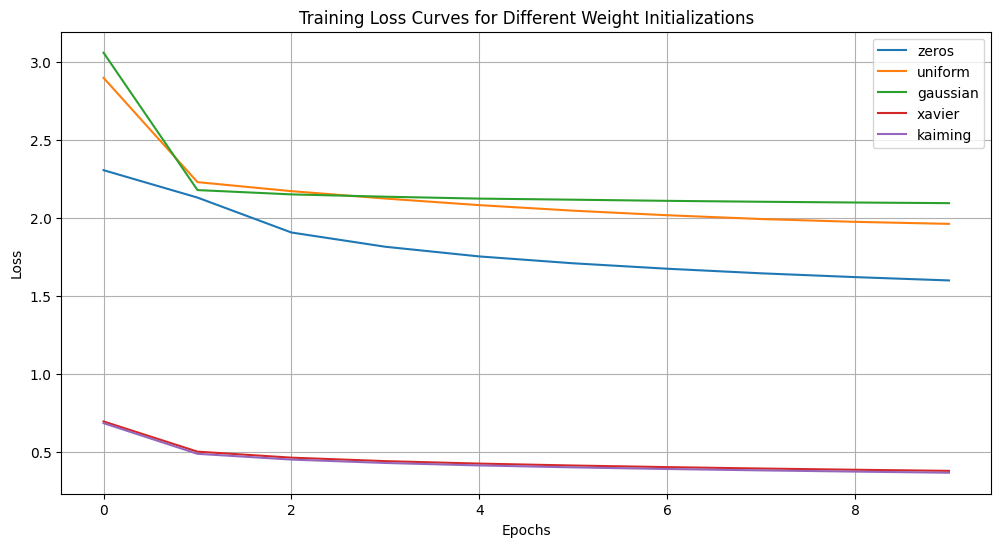

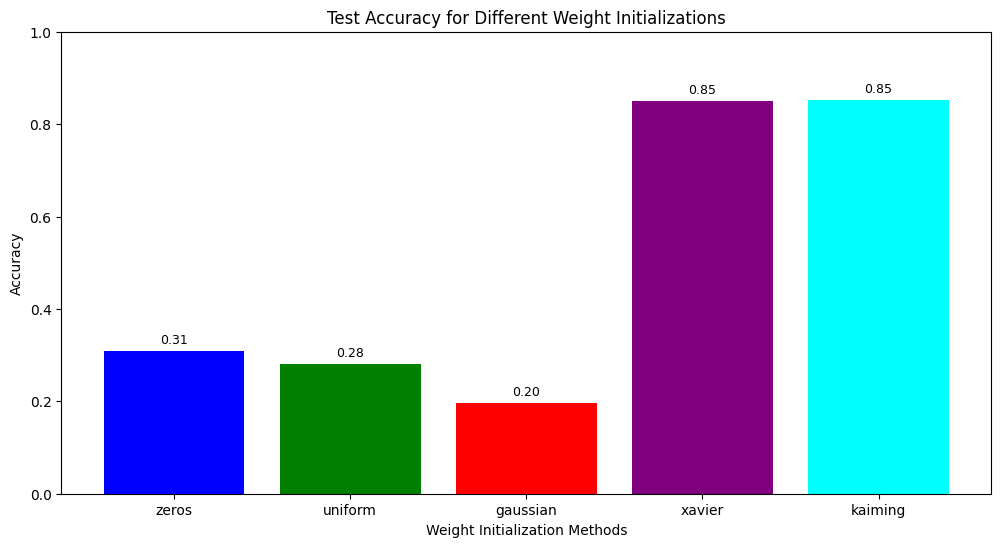

In [ ]:
weight_initialization_experiment(
    activation='relu',
    hidden_layers_sizes=[128],
    lr=0.01,
    batch_size=128,
    epochs=10,
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    X_test=X_test_mnist,
    y_test=y_test_mnist
)

### C. Testing On SoftPlus Activation


> - Assume the learning rate is 0.0001 and the batch size is 128
- The result from "zero", "uniform", and "Gaussian" are not consistent and bad
- The result from "Xavier" and "Kaiming" have the higher accuracy of 0.84

Training with zeros initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:03<00:34,  3.80s/it]

Epoch 1/10
Train Loss: 2.3060, Train Accuracy: 10.04%
Val Loss: 2.3044, Val Accuracy: 9.83%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:31,  3.97s/it]

Epoch 2/10
Train Loss: 2.3056, Train Accuracy: 10.03%
Val Loss: 2.3039, Val Accuracy: 9.88%
--------------------------------------------------


 30%|███       | 3/10 [00:11<00:25,  3.61s/it]

Epoch 3/10
Train Loss: 2.3036, Train Accuracy: 10.03%
Val Loss: 2.2987, Val Accuracy: 9.88%
--------------------------------------------------


 40%|████      | 4/10 [00:14<00:20,  3.46s/it]

Epoch 4/10
Train Loss: 2.2709, Train Accuracy: 10.03%
Val Loss: 2.2030, Val Accuracy: 9.88%
--------------------------------------------------


 50%|█████     | 5/10 [00:18<00:19,  3.90s/it]

Epoch 5/10
Train Loss: 2.1109, Train Accuracy: 20.93%
Val Loss: 2.0289, Val Accuracy: 21.51%
--------------------------------------------------


 60%|██████    | 6/10 [00:22<00:14,  3.68s/it]

Epoch 6/10
Train Loss: 1.9842, Train Accuracy: 23.84%
Val Loss: 1.9424, Val Accuracy: 23.62%
--------------------------------------------------


 70%|███████   | 7/10 [00:25<00:10,  3.53s/it]

Epoch 7/10
Train Loss: 1.9196, Train Accuracy: 24.47%
Val Loss: 1.8953, Val Accuracy: 24.45%
--------------------------------------------------


 80%|████████  | 8/10 [00:28<00:06,  3.44s/it]

Epoch 8/10
Train Loss: 1.8863, Train Accuracy: 23.77%
Val Loss: 1.8759, Val Accuracy: 24.07%
--------------------------------------------------


 90%|█████████ | 9/10 [00:33<00:03,  3.88s/it]

Epoch 9/10
Train Loss: 1.8816, Train Accuracy: 22.63%
Val Loss: 1.8837, Val Accuracy: 22.71%
--------------------------------------------------


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Epoch 10/10
Train Loss: 1.8959, Train Accuracy: 21.50%
Val Loss: 1.9187, Val Accuracy: 21.80%
--------------------------------------------------
Training with uniform initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:03<00:28,  3.17s/it]

Epoch 1/10
Train Loss: 2.7729, Train Accuracy: 62.77%
Val Loss: 2.1579, Val Accuracy: 62.56%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:29,  3.73s/it]

Epoch 2/10
Train Loss: 2.1873, Train Accuracy: 58.65%
Val Loss: 2.2977, Val Accuracy: 58.73%
--------------------------------------------------


 30%|███       | 3/10 [00:10<00:25,  3.71s/it]

Epoch 3/10
Train Loss: 2.3058, Train Accuracy: 53.79%
Val Loss: 2.1305, Val Accuracy: 52.83%
--------------------------------------------------


 40%|████      | 4/10 [00:14<00:20,  3.49s/it]

Epoch 4/10
Train Loss: 2.4842, Train Accuracy: 46.14%
Val Loss: 2.3583, Val Accuracy: 45.61%
--------------------------------------------------


 50%|█████     | 5/10 [00:17<00:16,  3.36s/it]

Epoch 5/10
Train Loss: 2.5574, Train Accuracy: 49.67%
Val Loss: 2.5463, Val Accuracy: 49.35%
--------------------------------------------------


 60%|██████    | 6/10 [00:21<00:15,  3.82s/it]

Epoch 6/10
Train Loss: 2.5945, Train Accuracy: 46.79%
Val Loss: 2.4830, Val Accuracy: 46.63%
--------------------------------------------------


 70%|███████   | 7/10 [00:25<00:10,  3.62s/it]

Epoch 7/10
Train Loss: 2.6879, Train Accuracy: 44.76%
Val Loss: 2.5130, Val Accuracy: 44.52%
--------------------------------------------------


 80%|████████  | 8/10 [00:28<00:06,  3.46s/it]

Epoch 8/10
Train Loss: 2.9156, Train Accuracy: 42.02%
Val Loss: 2.5771, Val Accuracy: 41.54%
--------------------------------------------------


 90%|█████████ | 9/10 [00:31<00:03,  3.37s/it]

Epoch 9/10
Train Loss: 2.9769, Train Accuracy: 39.32%
Val Loss: 2.8146, Val Accuracy: 39.42%
--------------------------------------------------


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Epoch 10/10
Train Loss: 2.7272, Train Accuracy: 49.53%
Val Loss: 2.3893, Val Accuracy: 49.37%
--------------------------------------------------
Training with gaussian initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:03<00:28,  3.19s/it]

Epoch 1/10
Train Loss: 2.1388, Train Accuracy: 34.39%
Val Loss: 1.7302, Val Accuracy: 33.38%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:30,  3.83s/it]

Epoch 2/10
Train Loss: 1.9185, Train Accuracy: 62.81%
Val Loss: 2.1972, Val Accuracy: 62.62%
--------------------------------------------------


 30%|███       | 3/10 [00:12<00:31,  4.56s/it]

Epoch 3/10
Train Loss: 2.3004, Train Accuracy: 57.89%
Val Loss: 2.3551, Val Accuracy: 57.72%
--------------------------------------------------


 40%|████      | 4/10 [00:16<00:24,  4.04s/it]

Epoch 4/10
Train Loss: 2.2847, Train Accuracy: 52.37%
Val Loss: 2.4131, Val Accuracy: 51.73%
--------------------------------------------------


 50%|█████     | 5/10 [00:19<00:18,  3.72s/it]

Epoch 5/10
Train Loss: 2.3322, Train Accuracy: 49.44%
Val Loss: 2.4962, Val Accuracy: 48.73%
--------------------------------------------------


 60%|██████    | 6/10 [00:23<00:15,  3.76s/it]

Epoch 6/10
Train Loss: 2.3633, Train Accuracy: 47.93%
Val Loss: 2.3696, Val Accuracy: 47.44%
--------------------------------------------------


 70%|███████   | 7/10 [00:27<00:11,  3.83s/it]

Epoch 7/10
Train Loss: 2.4213, Train Accuracy: 47.23%
Val Loss: 2.4332, Val Accuracy: 46.92%
--------------------------------------------------


 80%|████████  | 8/10 [00:30<00:07,  3.61s/it]

Epoch 8/10
Train Loss: 2.4329, Train Accuracy: 47.50%
Val Loss: 2.4419, Val Accuracy: 47.13%
--------------------------------------------------


 90%|█████████ | 9/10 [00:33<00:03,  3.48s/it]

Epoch 9/10
Train Loss: 2.5053, Train Accuracy: 45.41%
Val Loss: 2.4515, Val Accuracy: 45.11%
--------------------------------------------------


100%|██████████| 10/10 [00:38<00:00,  3.80s/it]


Epoch 10/10
Train Loss: 2.5903, Train Accuracy: 44.29%
Val Loss: 2.4770, Val Accuracy: 43.78%
--------------------------------------------------
Training with xavier initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:03<00:28,  3.18s/it]

Epoch 1/10
Train Loss: 0.7435, Train Accuracy: 80.54%
Val Loss: 0.5525, Val Accuracy: 81.04%
--------------------------------------------------


 20%|██        | 2/10 [00:06<00:25,  3.19s/it]

Epoch 2/10
Train Loss: 0.5279, Train Accuracy: 82.70%
Val Loss: 0.4922, Val Accuracy: 82.93%
--------------------------------------------------


 30%|███       | 3/10 [00:09<00:22,  3.26s/it]

Epoch 3/10
Train Loss: 0.4872, Train Accuracy: 83.62%
Val Loss: 0.4654, Val Accuracy: 83.68%
--------------------------------------------------


 40%|████      | 4/10 [00:14<00:22,  3.81s/it]

Epoch 4/10
Train Loss: 0.4650, Train Accuracy: 84.22%
Val Loss: 0.4491, Val Accuracy: 84.18%
--------------------------------------------------


 50%|█████     | 5/10 [00:17<00:17,  3.58s/it]

Epoch 5/10
Train Loss: 0.4501, Train Accuracy: 84.71%
Val Loss: 0.4378, Val Accuracy: 84.56%
--------------------------------------------------


 60%|██████    | 6/10 [00:20<00:14,  3.51s/it]

Epoch 6/10
Train Loss: 0.4389, Train Accuracy: 84.98%
Val Loss: 0.4293, Val Accuracy: 84.91%
--------------------------------------------------


 70%|███████   | 7/10 [00:25<00:11,  3.92s/it]

Epoch 7/10
Train Loss: 0.4300, Train Accuracy: 85.19%
Val Loss: 0.4226, Val Accuracy: 85.12%
--------------------------------------------------


 80%|████████  | 8/10 [00:29<00:07,  3.78s/it]

Epoch 8/10
Train Loss: 0.4226, Train Accuracy: 85.45%
Val Loss: 0.4170, Val Accuracy: 85.21%
--------------------------------------------------


 90%|█████████ | 9/10 [00:32<00:03,  3.64s/it]

Epoch 9/10
Train Loss: 0.4162, Train Accuracy: 85.62%
Val Loss: 0.4122, Val Accuracy: 85.34%
--------------------------------------------------


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]

Epoch 10/10
Train Loss: 0.4106, Train Accuracy: 85.80%
Val Loss: 0.4080, Val Accuracy: 85.55%
--------------------------------------------------


Training with kaiming initialization...
[784, 128, 10]


 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

Epoch 1/10
Train Loss: 0.7043, Train Accuracy: 81.31%
Val Loss: 0.5286, Val Accuracy: 81.45%
--------------------------------------------------


 20%|██        | 2/10 [00:08<00:32,  4.12s/it]

Epoch 2/10
Train Loss: 0.5105, Train Accuracy: 83.13%
Val Loss: 0.4781, Val Accuracy: 83.38%
--------------------------------------------------


 30%|███       | 3/10 [00:13<00:31,  4.52s/it]

Epoch 3/10
Train Loss: 0.4742, Train Accuracy: 84.05%
Val Loss: 0.4546, Val Accuracy: 84.07%
--------------------------------------------------


 40%|████      | 4/10 [00:18<00:27,  4.66s/it]

Epoch 4/10
Train Loss: 0.4536, Train Accuracy: 84.56%
Val Loss: 0.4400, Val Accuracy: 84.62%
--------------------------------------------------


 50%|█████     | 5/10 [00:21<00:20,  4.14s/it]

Epoch 5/10
Train Loss: 0.4394, Train Accuracy: 84.91%
Val Loss: 0.4296, Val Accuracy: 85.10%
--------------------------------------------------


 60%|██████    | 6/10 [00:24<00:15,  3.82s/it]

Epoch 6/10
Train Loss: 0.4285, Train Accuracy: 85.20%
Val Loss: 0.4216, Val Accuracy: 85.28%
--------------------------------------------------


 70%|███████   | 7/10 [00:29<00:11,  3.95s/it]

Epoch 7/10
Train Loss: 0.4197, Train Accuracy: 85.50%
Val Loss: 0.4151, Val Accuracy: 85.35%
--------------------------------------------------


 80%|████████  | 8/10 [00:32<00:07,  3.82s/it]

Epoch 8/10
Train Loss: 0.4123, Train Accuracy: 85.74%
Val Loss: 0.4097, Val Accuracy: 85.43%
--------------------------------------------------


 90%|█████████ | 9/10 [00:35<00:03,  3.61s/it]

Epoch 9/10
Train Loss: 0.4058, Train Accuracy: 85.92%
Val Loss: 0.4050, Val Accuracy: 85.63%
--------------------------------------------------


100%|██████████| 10/10 [00:38<00:00,  3.90s/it]

Epoch 10/10
Train Loss: 0.4001, Train Accuracy: 86.13%
Val Loss: 0.4008, Val Accuracy: 85.72%
--------------------------------------------------


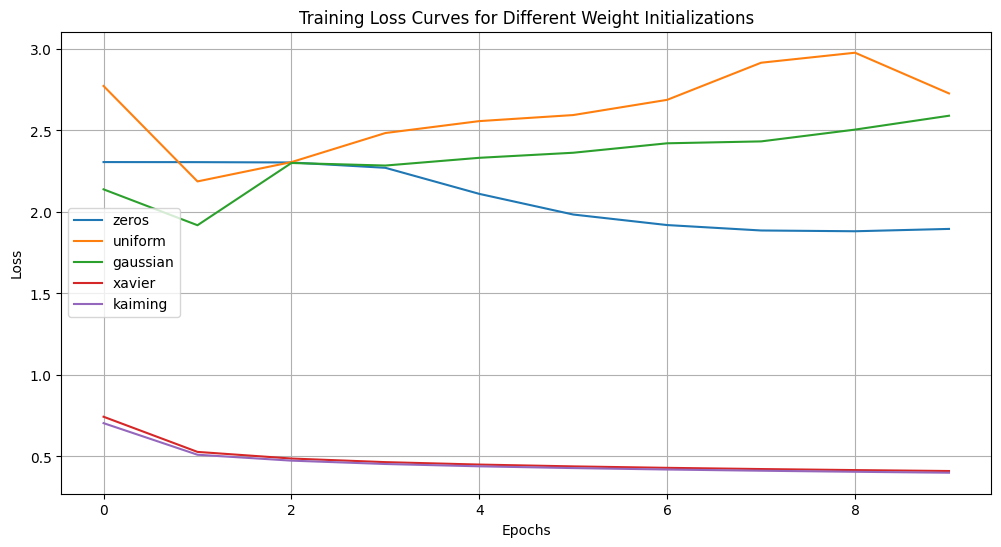

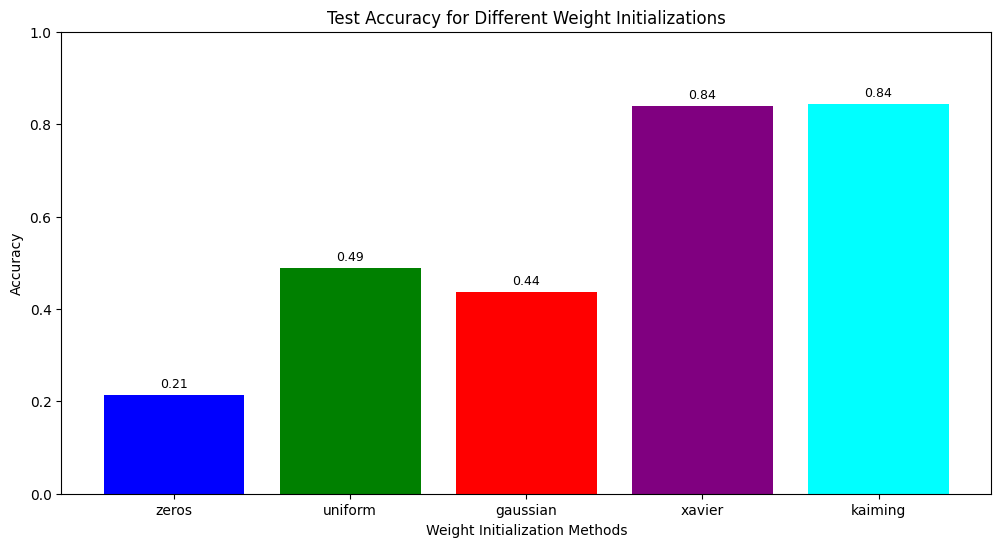

In [ ]:
weight_initialization_experiment(
    activation='soft_plus',
    hidden_layers_sizes=[128],
    lr=0.01,
    batch_size=128,
    epochs=10,
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    X_test=X_test_mnist,
    y_test=y_test_mnist
)

## 3.2 Experiment With Different Layers and Units


> Testing on ReLu with the three cases:
- (1) an MLP with no hidden layers (only softmax)
- (2) an MLP with a single hidden layer having 128 units
- (3) an MLP with 2 hidden layers each having 128 units



No Hidden Layer Model:

- Test Accuracy: 71.35%
1 Hidden Layer Model:

- Test Accuracy: 85.27%
2 Hidden Layers Model:

- Test Accuracy: 85.31%


Effect of Non-linearity and Network Depth on Accuracy:

- Non-linearity: The jump in accuracy from the model with no hidden layers to the model with a single hidden layer illustrates the power of non-linearity. It allows the neural network to learn more complex functions and capture intricate patterns in the data.

- Network Depth: The increase in accuracy from the 1-hidden-layer model to the 2-hidden-layer model is minimal, suggesting diminishing returns with added depth for this particular dataset and architecture. This means the data might not have more intricate patterns that need deeper networks to capture. Alternatively, the depth might introduce more parameters, increasing the risk of overfitting if not managed correctly.

Are the results expected?:

- The improvement in accuracy upon introducing non-linearity (via a hidden layer) is expected. It's well known in deep learning that non-linear transformations allow networks to learn more complex functions.
- The minimal gain in accuracy with an additional hidden layer is somewhat expected for a relatively simple dataset like Fashion MNIST. Deeper networks might show more pronounced benefits on more complex datasets or tasks. However, one must also be cautious as deeper networks can lead to overfitting and might require more sophisticated regularization techniques.



Training model: No Hidden Layer
[784, 10]


 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Epoch 1/10
Train Loss: 9.8249, Train Accuracy: 52.46%
Val Loss: 6.2621, Val Accuracy: 52.30%
--------------------------------------------------


 20%|██        | 2/10 [00:03<00:12,  1.61s/it]

Epoch 2/10
Train Loss: 5.3456, Train Accuracy: 61.02%
Val Loss: 4.7403, Val Accuracy: 60.74%
--------------------------------------------------


 30%|███       | 3/10 [00:04<00:08,  1.28s/it]

Epoch 3/10
Train Loss: 4.3748, Train Accuracy: 64.89%
Val Loss: 4.0902, Val Accuracy: 64.60%
--------------------------------------------------


 40%|████      | 4/10 [00:04<00:06,  1.11s/it]

Epoch 4/10
Train Loss: 3.8745, Train Accuracy: 67.06%
Val Loss: 3.6913, Val Accuracy: 67.06%
--------------------------------------------------


 50%|█████     | 5/10 [00:05<00:05,  1.01s/it]

Epoch 5/10
Train Loss: 3.5389, Train Accuracy: 68.70%
Val Loss: 3.4067, Val Accuracy: 68.47%
--------------------------------------------------


 60%|██████    | 6/10 [00:06<00:03,  1.04it/s]

Epoch 6/10
Train Loss: 3.2910, Train Accuracy: 69.93%
Val Loss: 3.1901, Val Accuracy: 69.70%
--------------------------------------------------


 70%|███████   | 7/10 [00:07<00:02,  1.08it/s]

Epoch 7/10
Train Loss: 3.0977, Train Accuracy: 70.78%
Val Loss: 3.0207, Val Accuracy: 70.82%
--------------------------------------------------


 80%|████████  | 8/10 [00:08<00:01,  1.11it/s]

Epoch 8/10
Train Loss: 2.9409, Train Accuracy: 71.56%
Val Loss: 2.8848, Val Accuracy: 71.48%
--------------------------------------------------


 90%|█████████ | 9/10 [00:09<00:00,  1.13it/s]

Epoch 9/10
Train Loss: 2.8105, Train Accuracy: 72.21%
Val Loss: 2.7714, Val Accuracy: 71.98%
--------------------------------------------------


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 10/10
Train Loss: 2.7000, Train Accuracy: 72.78%
Val Loss: 2.6742, Val Accuracy: 72.59%
--------------------------------------------------
No Hidden Layer Test Accuracy: 71.28%
--------------------------------------------------
Training model: 1 Hidden Layer
[784, 128, 10]


 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Epoch 1/10
Train Loss: 0.6857, Train Accuracy: 81.81%
Val Loss: 0.5079, Val Accuracy: 82.02%
--------------------------------------------------


 20%|██        | 2/10 [00:06<00:27,  3.50s/it]

Epoch 2/10
Train Loss: 0.4894, Train Accuracy: 83.73%
Val Loss: 0.4590, Val Accuracy: 83.63%
--------------------------------------------------


 30%|███       | 3/10 [00:09<00:21,  3.04s/it]

Epoch 3/10
Train Loss: 0.4526, Train Accuracy: 84.70%
Val Loss: 0.4355, Val Accuracy: 84.38%
--------------------------------------------------


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

Epoch 4/10
Train Loss: 0.4308, Train Accuracy: 85.28%
Val Loss: 0.4205, Val Accuracy: 84.95%
--------------------------------------------------


 50%|█████     | 5/10 [00:14<00:13,  2.71s/it]

Epoch 5/10
Train Loss: 0.4151, Train Accuracy: 85.81%
Val Loss: 0.4097, Val Accuracy: 85.40%
--------------------------------------------------


 60%|██████    | 6/10 [00:16<00:10,  2.61s/it]

Epoch 6/10
Train Loss: 0.4027, Train Accuracy: 86.15%
Val Loss: 0.4012, Val Accuracy: 85.70%
--------------------------------------------------


 70%|███████   | 7/10 [00:20<00:09,  3.10s/it]

Epoch 7/10
Train Loss: 0.3923, Train Accuracy: 86.44%
Val Loss: 0.3939, Val Accuracy: 85.99%
--------------------------------------------------


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

Epoch 8/10
Train Loss: 0.3834, Train Accuracy: 86.76%
Val Loss: 0.3878, Val Accuracy: 86.26%
--------------------------------------------------


 90%|█████████ | 9/10 [00:25<00:02,  2.76s/it]

Epoch 9/10
Train Loss: 0.3755, Train Accuracy: 86.98%
Val Loss: 0.3826, Val Accuracy: 86.42%
--------------------------------------------------


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


Epoch 10/10
Train Loss: 0.3684, Train Accuracy: 87.18%
Val Loss: 0.3776, Val Accuracy: 86.67%
--------------------------------------------------
1 Hidden Layer Test Accuracy: 85.25%
--------------------------------------------------
Training model: 2 Hidden Layers
[784, 128, 128, 10]


 10%|█         | 1/10 [00:04<00:39,  4.43s/it]

Epoch 1/10
Train Loss: 1.0425, Train Accuracy: 78.68%
Val Loss: 0.7017, Val Accuracy: 78.61%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:29,  3.64s/it]

Epoch 2/10
Train Loss: 0.6877, Train Accuracy: 81.32%
Val Loss: 0.6366, Val Accuracy: 80.79%
--------------------------------------------------


 30%|███       | 3/10 [00:10<00:23,  3.30s/it]

Epoch 3/10
Train Loss: 0.5647, Train Accuracy: 85.09%
Val Loss: 0.4292, Val Accuracy: 84.82%
--------------------------------------------------


 40%|████      | 4/10 [00:13<00:18,  3.16s/it]

Epoch 4/10
Train Loss: 0.4181, Train Accuracy: 86.16%
Val Loss: 0.4045, Val Accuracy: 85.62%
--------------------------------------------------


 50%|█████     | 5/10 [00:17<00:18,  3.63s/it]

Epoch 5/10
Train Loss: 0.3944, Train Accuracy: 86.79%
Val Loss: 0.3893, Val Accuracy: 86.11%
--------------------------------------------------


 60%|██████    | 6/10 [00:20<00:13,  3.40s/it]

Epoch 6/10
Train Loss: 0.3779, Train Accuracy: 87.21%
Val Loss: 0.3793, Val Accuracy: 86.50%
--------------------------------------------------


 70%|███████   | 7/10 [00:23<00:09,  3.25s/it]

Epoch 7/10
Train Loss: 0.3649, Train Accuracy: 87.52%
Val Loss: 0.3716, Val Accuracy: 86.72%
--------------------------------------------------


 80%|████████  | 8/10 [00:26<00:06,  3.17s/it]

Epoch 8/10
Train Loss: 0.3541, Train Accuracy: 87.82%
Val Loss: 0.3656, Val Accuracy: 86.82%
--------------------------------------------------


 90%|█████████ | 9/10 [00:31<00:03,  3.61s/it]

Epoch 9/10
Train Loss: 0.3446, Train Accuracy: 88.16%
Val Loss: 0.3600, Val Accuracy: 86.93%
--------------------------------------------------


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]

Epoch 10/10
Train Loss: 0.3363, Train Accuracy: 88.39%
Val Loss: 0.3556, Val Accuracy: 87.21%
--------------------------------------------------
2 Hidden Layers Test Accuracy: 85.74%
--------------------------------------------------


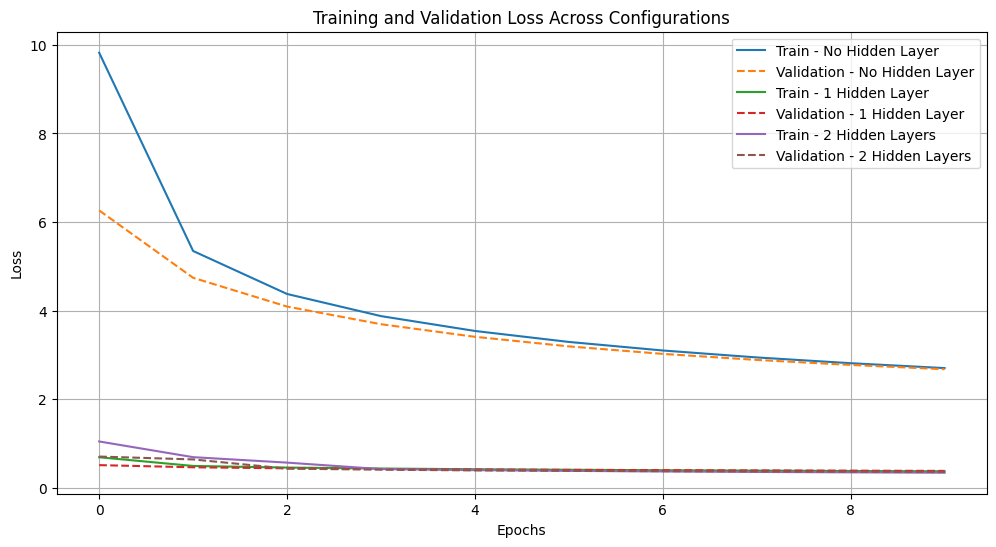

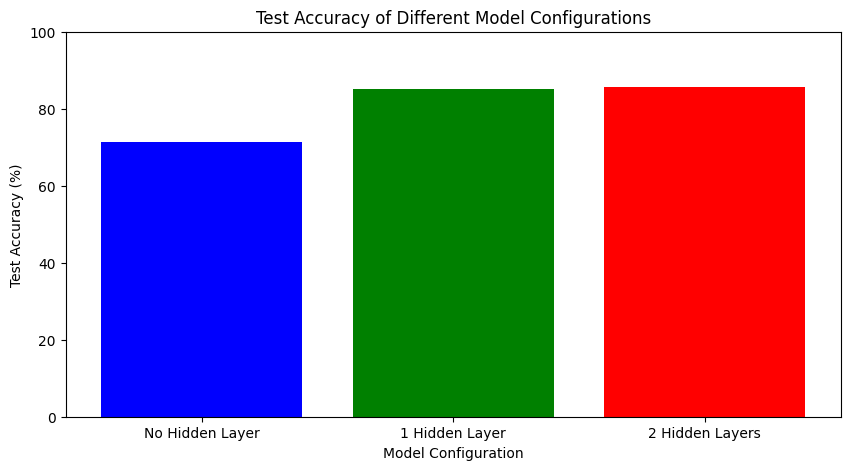

In [ ]:
def run_layer_experiment(X_train, y_train, X_val, y_val, X_test, y_test, epochs=10, lr=0.0001, batch_size=128):
    configurations = [
        ("No Hidden Layer", []),
        ("1 Hidden Layer", [128]),
        ("2 Hidden Layers", [128, 128])
    ]

    test_accuracies = []
    config_names = []

    all_train_losses = {}
    all_val_losses = {}

    for config_name, hidden_layers in configurations:
        print(f"Training model: {config_name}")
        config_names.append(config_name)

        # Initialize the MLP model
        model = MLP(activation_name='relu',
                    hidden_layers_sizes=hidden_layers,
                    input_sizes=X_train.shape[1],
                    output_sizes=y_train.shape[1],
                    weight_init='kaiming' if hidden_layers else 'gaussian')  # kaiming init is good for ReLU, else gaussian

        # Train the model with batches
        optimizer = MiniBatchSGD(lr=lr, batch_size=batch_size, rs=42)
        train_losses, val_losses, _, _ = model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            num_of_epoch=epochs,
            optimizer_class=optimizer)

        all_train_losses[config_name] = train_losses
        all_val_losses[config_name] = val_losses

        # Test accuracy
        y_pred = model.predict(X_test)
        test_acc = evaluate_acc(y_true=y_test, y_pred=y_pred)
        test_accuracies.append(test_acc)

        print(f"{config_name} Test Accuracy: {test_acc * 100:.2f}%")
        print('-' * 50)

    # Plot training and validation loss curves for all configurations on one graph
    plt.figure(figsize=(12, 6))
    for config_name in config_names:
        plt.plot(range(epochs), all_train_losses[config_name], label=f"Train - {config_name}")
        plt.plot(range(epochs), all_val_losses[config_name], '--', label=f"Validation - {config_name}")
    plt.title("Training and Validation Loss Across Configurations")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the test accuracy for each model
    plt.figure(figsize=(10, 5))
    plt.bar(config_names, [acc*100 for acc in test_accuracies], color=['blue', 'green', 'red'])
    plt.xlabel("Model Configuration")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy of Different Model Configurations")
    plt.ylim(0, 100)
    plt.show()

    return test_accuracies

accuracies = run_layer_experiment(X_train_mnist, y_train_mnist, X_val_mnist, y_val_mnist, X_test_mnist, y_test_mnist)


## 3.3 Experiment With Different Activation Functions

> - We have selected "ReLu", "Sigmoid", and "SoftPlus" activations for comparison
- From the previous experiment, we have found the weight init "kaiming" have the best performance among all the activation, we choose as the common configuration
- Assume the models are in 2 hidden layers (128 units each) and the same batch sizes of 128
- Finally, compare the performance though the training curve, loss curve and accuracy bar chart



In [ ]:
def activation_experiment(X_train, y_train, X_test, y_test, X_val, y_val, sigmoid_lr, softplus_lr, relu_lr):
    # 1. Train a model with the sigmoid activation function
    model_sigmoid = MLP(activation_name='sigmoid',
                        hidden_layers_sizes=[128, 128],
                        input_sizes=X_train.shape[1],
                        output_sizes=y_train.shape[1],
                        weight_init='kaiming')

    sigmoid_optimizer = MiniBatchSGD(lr=sigmoid_lr, batch_size=128, rs=42)
    train_losses_sigmoid, val_losses_sigmoid, train_accuracy_sigmoid, val_accuracy_sigmoid = model_sigmoid.fit(X_train, y_train, X_val, y_val, num_of_epoch=10, optimizer_class=sigmoid_optimizer)

    # 2. Train a model with the softplus activation function
    model_softplus = MLP(activation_name='soft_plus',
                         hidden_layers_sizes=[128, 128],
                         input_sizes=X_train.shape[1],
                         output_sizes=y_train.shape[1],
                         weight_init='kaiming')

    softplus_optimizer = MiniBatchSGD(lr=softplus_lr, batch_size=128, rs=42)
    train_losses_softplus, val_losses_softplus, train_accuracy_softplus, val_accuracy_softplus = model_softplus.fit(X_train, y_train, X_val, y_val, num_of_epoch=10, optimizer_class=softplus_optimizer)

    # 3. Train the original model with the ReLU activation for comparison
    model_relu = MLP(activation_name='relu',
                     hidden_layers_sizes=[128, 128],
                     input_sizes=X_train.shape[1],
                     output_sizes=y_train.shape[1],
                     weight_init='kaiming')

    relu_optimizer = MiniBatchSGD(lr=relu_lr, batch_size=128, rs=42)
    train_losses_relu, val_losses_relu, train_accuracy_relu, val_accuracy_relu = model_relu.fit(X_train, y_train, X_val, y_val, num_of_epoch=10, optimizer_class=relu_optimizer)

    # 4. Compare the test accuracies of all three models
    sigmoid_test_accuracy = evaluate_acc(y_true=y_test, y_pred=model_sigmoid.predict(X_test))
    softplus_test_accuracy = evaluate_acc(y_true=y_test, y_pred=model_softplus.predict(X_test))
    relu_test_accuracy = evaluate_acc(y_true=y_test, y_pred=model_relu.predict(X_test))


    # Plotting 1. Plot Loss vs. Epochs for Train and Validation Sets
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses_sigmoid, label="Sigmoid Train Loss")
    plt.plot(val_losses_sigmoid, label="Sigmoid Validation Loss")
    plt.plot(train_losses_softplus, label="Softplus Train Loss")
    plt.plot(val_losses_softplus, label="Softplus Validation Loss")
    plt.plot(train_losses_relu, label="ReLU Train Loss")
    plt.plot(val_losses_relu, label="ReLU Validation Loss")
    plt.legend()
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Plotting 2. Plot Accuracy vs. Epochs for Train and Validation Sets
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_sigmoid, label="Sigmoid Train Accuracy")
    plt.plot(val_accuracy_sigmoid, label="Sigmoid Validation Accuracy")
    plt.plot(train_accuracy_softplus, label="Softplus Train Accuracy")
    plt.plot(val_accuracy_softplus, label="Softplus Validation Accuracy")
    plt.plot(train_accuracy_relu, label="ReLU Train Accuracy")
    plt.plot(val_accuracy_relu, label="ReLU Validation Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    # Plotting 3. Bar Graph Comparing Final Test Accuracies
    accuracies = [sigmoid_test_accuracy, softplus_test_accuracy, relu_test_accuracy]
    labels = ["Sigmoid", "Softplus", "ReLU"]

    plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
    plt.ylabel("Test Accuracy")
    plt.title("Comparison of Test Accuracies")
    plt.show()

    print(f"Sigmoid Test Accuracy: {sigmoid_test_accuracy * 100:.2f}%")
    print(f"Softplus Test Accuracy: {softplus_test_accuracy * 100:.2f}%")
    print(f"ReLU Test Accuracy: {relu_test_accuracy * 100:.2f}%")

    # 5. Provide a comment on the performance
    # This is a general analysis, which could be refined based on real results.
    if sigmoid_test_accuracy > relu_test_accuracy and sigmoid_test_accuracy > softplus_test_accuracy:
        print("The model with the sigmoid activation performed the best.")
    elif softplus_test_accuracy > relu_test_accuracy and softplus_test_accuracy > sigmoid_test_accuracy:
        print("The model with the softplus activation performed the best.")
    else:
        print("The model with the ReLU activation performed the best.")

### A. Case 1 - Assume all activiation having same learning rate of 0.01



> - We can see only sigmoid is performing well here
- At a higher learning rate (e.g., 0.01), only the sigmoid activation function performs well, while both ReLU and softplus underperform.



[784, 128, 128, 10]


 10%|█         | 1/10 [00:03<00:31,  3.50s/it]

Epoch 1/10
Train Loss: 1.7658, Train Accuracy: 61.57%
Val Loss: 1.6595, Val Accuracy: 61.32%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:31,  3.88s/it]

Epoch 2/10
Train Loss: 1.6424, Train Accuracy: 66.19%
Val Loss: 1.6271, Val Accuracy: 65.97%
--------------------------------------------------


 30%|███       | 3/10 [00:11<00:28,  4.05s/it]

Epoch 3/10
Train Loss: 1.6170, Train Accuracy: 70.01%
Val Loss: 1.6074, Val Accuracy: 70.05%
--------------------------------------------------


 40%|████      | 4/10 [00:15<00:22,  3.78s/it]

Epoch 4/10
Train Loss: 1.6017, Train Accuracy: 75.66%
Val Loss: 1.5965, Val Accuracy: 75.62%
--------------------------------------------------


 50%|█████     | 5/10 [00:18<00:18,  3.66s/it]

Epoch 5/10
Train Loss: 1.5929, Train Accuracy: 78.72%
Val Loss: 1.5902, Val Accuracy: 78.56%
--------------------------------------------------


 60%|██████    | 6/10 [00:23<00:16,  4.15s/it]

Epoch 6/10
Train Loss: 1.5815, Train Accuracy: 80.52%
Val Loss: 1.5753, Val Accuracy: 80.45%
--------------------------------------------------


 70%|███████   | 7/10 [00:27<00:11,  3.91s/it]

Epoch 7/10
Train Loss: 1.5712, Train Accuracy: 81.70%
Val Loss: 1.5719, Val Accuracy: 81.63%
--------------------------------------------------


 80%|████████  | 8/10 [00:30<00:07,  3.75s/it]

Epoch 8/10
Train Loss: 1.5673, Train Accuracy: 82.65%
Val Loss: 1.5695, Val Accuracy: 82.54%
--------------------------------------------------


 90%|█████████ | 9/10 [00:35<00:04,  4.11s/it]

Epoch 9/10
Train Loss: 1.5641, Train Accuracy: 83.45%
Val Loss: 1.5674, Val Accuracy: 83.39%
--------------------------------------------------


100%|██████████| 10/10 [00:38<00:00,  3.90s/it]


Epoch 10/10
Train Loss: 1.5613, Train Accuracy: 84.08%
Val Loss: 1.5656, Val Accuracy: 84.02%
--------------------------------------------------
[784, 128, 128, 10]


 10%|█         | 1/10 [00:04<00:37,  4.21s/it]

Epoch 1/10
Train Loss: 5.0371, Train Accuracy: 13.92%
Val Loss: 2.2644, Val Accuracy: 13.73%
--------------------------------------------------


 20%|██        | 2/10 [00:09<00:40,  5.02s/it]

Epoch 2/10
Train Loss: 3.6562, Train Accuracy: 17.20%
Val Loss: 2.3373, Val Accuracy: 16.58%
--------------------------------------------------


 30%|███       | 3/10 [00:14<00:32,  4.65s/it]

Epoch 3/10
Train Loss: 3.3113, Train Accuracy: 10.10%
Val Loss: 2.3041, Val Accuracy: 9.60%
--------------------------------------------------


 40%|████      | 4/10 [00:18<00:26,  4.50s/it]

Epoch 4/10
Train Loss: 3.1670, Train Accuracy: 10.10%
Val Loss: 2.3087, Val Accuracy: 9.60%
--------------------------------------------------


 50%|█████     | 5/10 [00:24<00:25,  5.04s/it]

Epoch 5/10
Train Loss: 3.1901, Train Accuracy: 10.10%
Val Loss: 2.3194, Val Accuracy: 9.60%
--------------------------------------------------


 60%|██████    | 6/10 [00:29<00:20,  5.03s/it]

Epoch 6/10
Train Loss: 3.0726, Train Accuracy: 10.05%
Val Loss: 2.3606, Val Accuracy: 9.55%
--------------------------------------------------


 70%|███████   | 7/10 [00:35<00:16,  5.54s/it]

Epoch 7/10
Train Loss: 3.1423, Train Accuracy: 14.33%
Val Loss: 2.4427, Val Accuracy: 13.63%
--------------------------------------------------


 80%|████████  | 8/10 [00:40<00:10,  5.31s/it]

Epoch 8/10
Train Loss: 3.0102, Train Accuracy: 10.10%
Val Loss: 2.3026, Val Accuracy: 9.60%
--------------------------------------------------


 90%|█████████ | 9/10 [00:46<00:05,  5.37s/it]

Epoch 9/10
Train Loss: 3.1190, Train Accuracy: 10.10%
Val Loss: 2.3055, Val Accuracy: 9.60%
--------------------------------------------------


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


Epoch 10/10
Train Loss: 2.9411, Train Accuracy: 10.10%
Val Loss: 2.3072, Val Accuracy: 9.60%
--------------------------------------------------
[784, 128, 128, 10]


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-7-1ec57f747654>:28: RuntimeWarning: invalid value encountered in subtract
  exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
 10%|█         | 1/10 [00:02<00:26,  2.91s/it]

Epoch 1/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

Epoch 2/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 30%|███       | 3/10 [00:10<00:25,  3.68s/it]

Epoch 3/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 40%|████      | 4/10 [00:13<00:20,  3.37s/it]

Epoch 4/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 50%|█████     | 5/10 [00:16<00:16,  3.21s/it]

Epoch 5/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 60%|██████    | 6/10 [00:19<00:12,  3.11s/it]

Epoch 6/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 70%|███████   | 7/10 [00:23<00:10,  3.57s/it]

Epoch 7/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 80%|████████  | 8/10 [00:26<00:06,  3.37s/it]

Epoch 8/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


 90%|█████████ | 9/10 [00:29<00:03,  3.23s/it]

Epoch 9/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]

Epoch 10/10
Train Loss: nan, Train Accuracy: 10.10%
Val Loss: nan, Val Accuracy: 9.60%
--------------------------------------------------


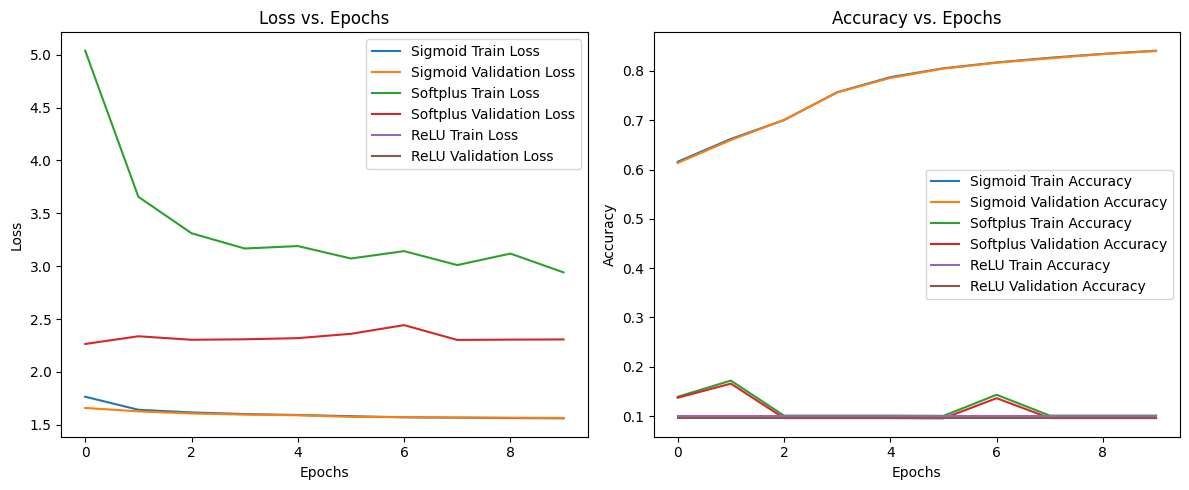

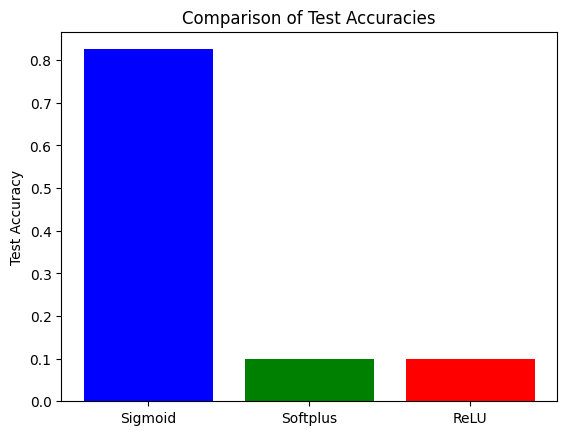

Sigmoid Test Accuracy: 82.55%
Softplus Test Accuracy: 10.00%
ReLU Test Accuracy: 10.00%
The model with the sigmoid activation performed the best.


In [ ]:
activation_experiment(
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_test=X_test_mnist,
    y_test=y_test_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    sigmoid_lr=0.1,
    softplus_lr=0.1,
    relu_lr=0.1
)

### B. Case 2 - Lower down the learning rate of Relu and SoftPlus


> - At a much lower learning rate (0.0001), both ReLU and softplus start to outperform the sigmoid.



[784, 128, 128, 10]


 10%|█         | 1/10 [00:04<00:41,  4.60s/it]

Epoch 1/10
Train Loss: 1.7083, Train Accuracy: 69.97%
Val Loss: 1.6118, Val Accuracy: 69.37%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:31,  3.88s/it]

Epoch 2/10
Train Loss: 1.6068, Train Accuracy: 79.81%
Val Loss: 1.5918, Val Accuracy: 79.79%
--------------------------------------------------


 30%|███       | 3/10 [00:11<00:25,  3.66s/it]

Epoch 3/10
Train Loss: 1.5826, Train Accuracy: 82.45%
Val Loss: 1.5707, Val Accuracy: 82.01%
--------------------------------------------------


 40%|████      | 4/10 [00:16<00:25,  4.21s/it]

Epoch 4/10
Train Loss: 1.5696, Train Accuracy: 83.36%
Val Loss: 1.5715, Val Accuracy: 83.13%
--------------------------------------------------


 50%|█████     | 5/10 [00:19<00:19,  3.94s/it]

Epoch 5/10
Train Loss: 1.5648, Train Accuracy: 85.64%
Val Loss: 1.5588, Val Accuracy: 85.52%
--------------------------------------------------


 60%|██████    | 6/10 [00:23<00:15,  3.75s/it]

Epoch 6/10
Train Loss: 1.5595, Train Accuracy: 84.96%
Val Loss: 1.5628, Val Accuracy: 84.29%
--------------------------------------------------


 70%|███████   | 7/10 [00:27<00:12,  4.01s/it]

Epoch 7/10
Train Loss: 1.5553, Train Accuracy: 85.96%
Val Loss: 1.5569, Val Accuracy: 85.43%
--------------------------------------------------


 80%|████████  | 8/10 [00:31<00:07,  3.92s/it]

Epoch 8/10
Train Loss: 1.5533, Train Accuracy: 85.97%
Val Loss: 1.5584, Val Accuracy: 84.82%
--------------------------------------------------


 90%|█████████ | 9/10 [00:34<00:03,  3.77s/it]

Epoch 9/10
Train Loss: 1.5532, Train Accuracy: 86.83%
Val Loss: 1.5556, Val Accuracy: 86.02%
--------------------------------------------------


100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


Epoch 10/10
Train Loss: 1.5509, Train Accuracy: 85.72%
Val Loss: 1.5599, Val Accuracy: 84.91%
--------------------------------------------------
[784, 128, 128, 10]


 10%|█         | 1/10 [00:05<00:53,  5.95s/it]

Epoch 1/10
Train Loss: 0.7058, Train Accuracy: 81.47%
Val Loss: 0.5176, Val Accuracy: 81.70%
--------------------------------------------------


 20%|██        | 2/10 [00:10<00:40,  5.03s/it]

Epoch 2/10
Train Loss: 0.5039, Train Accuracy: 83.43%
Val Loss: 0.4650, Val Accuracy: 83.23%
--------------------------------------------------


 30%|███       | 3/10 [00:15<00:36,  5.18s/it]

Epoch 3/10
Train Loss: 0.4637, Train Accuracy: 84.44%
Val Loss: 0.4406, Val Accuracy: 83.97%
--------------------------------------------------


 40%|████      | 4/10 [00:20<00:29,  4.98s/it]

Epoch 4/10
Train Loss: 0.4411, Train Accuracy: 85.02%
Val Loss: 0.4253, Val Accuracy: 84.58%
--------------------------------------------------


 50%|█████     | 5/10 [00:24<00:23,  4.75s/it]

Epoch 5/10
Train Loss: 0.4254, Train Accuracy: 85.44%
Val Loss: 0.4144, Val Accuracy: 84.95%
--------------------------------------------------


 60%|██████    | 6/10 [00:30<00:20,  5.12s/it]

Epoch 6/10
Train Loss: 0.4135, Train Accuracy: 85.74%
Val Loss: 0.4059, Val Accuracy: 85.38%
--------------------------------------------------


 70%|███████   | 7/10 [00:34<00:14,  4.86s/it]

Epoch 7/10
Train Loss: 0.4039, Train Accuracy: 86.03%
Val Loss: 0.3991, Val Accuracy: 85.64%
--------------------------------------------------


 80%|████████  | 8/10 [00:39<00:09,  4.70s/it]

Epoch 8/10
Train Loss: 0.3957, Train Accuracy: 86.27%
Val Loss: 0.3933, Val Accuracy: 85.82%
--------------------------------------------------


 90%|█████████ | 9/10 [00:45<00:05,  5.11s/it]

Epoch 9/10
Train Loss: 0.3886, Train Accuracy: 86.54%
Val Loss: 0.3884, Val Accuracy: 85.99%
--------------------------------------------------


100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


Epoch 10/10
Train Loss: 0.3822, Train Accuracy: 86.74%
Val Loss: 0.3840, Val Accuracy: 86.12%
--------------------------------------------------
[784, 128, 128, 10]


 10%|█         | 1/10 [00:02<00:26,  2.97s/it]

Epoch 1/10
Train Loss: 1.0425, Train Accuracy: 78.68%
Val Loss: 0.7017, Val Accuracy: 78.61%
--------------------------------------------------


 20%|██        | 2/10 [00:07<00:32,  4.08s/it]

Epoch 2/10
Train Loss: 0.6877, Train Accuracy: 81.32%
Val Loss: 0.6366, Val Accuracy: 80.79%
--------------------------------------------------


 30%|███       | 3/10 [00:10<00:25,  3.58s/it]

Epoch 3/10
Train Loss: 0.5647, Train Accuracy: 85.09%
Val Loss: 0.4292, Val Accuracy: 84.82%
--------------------------------------------------


 40%|████      | 4/10 [00:13<00:20,  3.36s/it]

Epoch 4/10
Train Loss: 0.4181, Train Accuracy: 86.16%
Val Loss: 0.4045, Val Accuracy: 85.62%
--------------------------------------------------


 50%|█████     | 5/10 [00:16<00:16,  3.28s/it]

Epoch 5/10
Train Loss: 0.3944, Train Accuracy: 86.79%
Val Loss: 0.3893, Val Accuracy: 86.11%
--------------------------------------------------


 60%|██████    | 6/10 [00:21<00:14,  3.69s/it]

Epoch 6/10
Train Loss: 0.3779, Train Accuracy: 87.21%
Val Loss: 0.3793, Val Accuracy: 86.50%
--------------------------------------------------


 70%|███████   | 7/10 [00:24<00:10,  3.45s/it]

Epoch 7/10
Train Loss: 0.3649, Train Accuracy: 87.52%
Val Loss: 0.3716, Val Accuracy: 86.72%
--------------------------------------------------


 80%|████████  | 8/10 [00:27<00:06,  3.30s/it]

Epoch 8/10
Train Loss: 0.3541, Train Accuracy: 87.82%
Val Loss: 0.3656, Val Accuracy: 86.82%
--------------------------------------------------


 90%|█████████ | 9/10 [00:31<00:03,  3.40s/it]

Epoch 9/10
Train Loss: 0.3446, Train Accuracy: 88.16%
Val Loss: 0.3600, Val Accuracy: 86.93%
--------------------------------------------------


100%|██████████| 10/10 [00:35<00:00,  3.52s/it]

Epoch 10/10
Train Loss: 0.3363, Train Accuracy: 88.39%
Val Loss: 0.3556, Val Accuracy: 87.21%
--------------------------------------------------


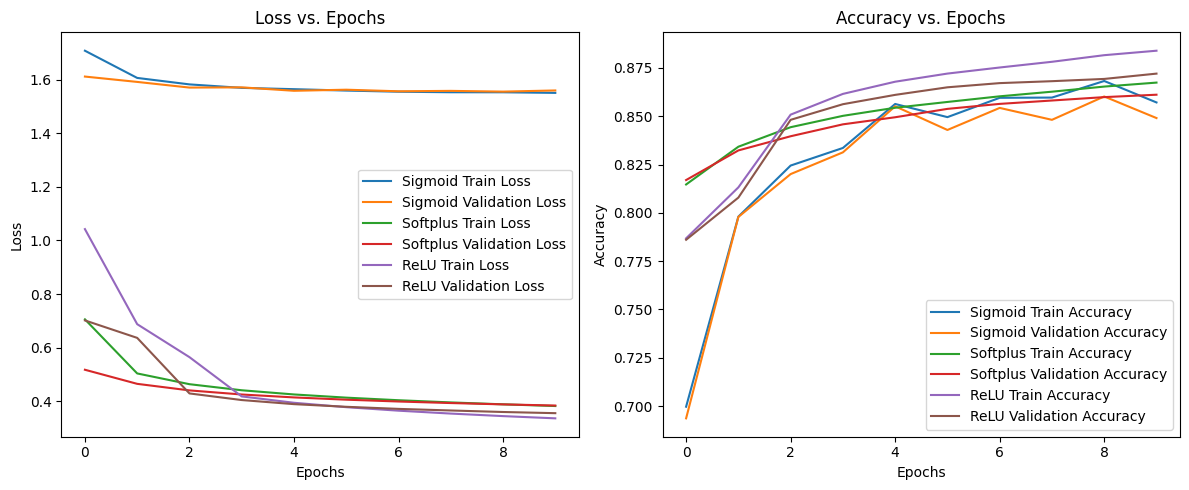

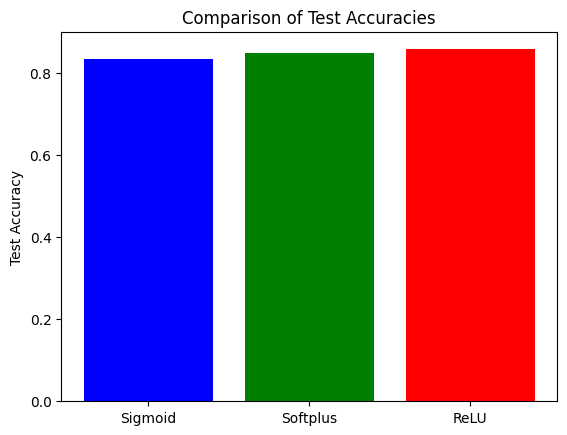

Sigmoid Test Accuracy: 83.48%
Softplus Test Accuracy: 84.89%
ReLU Test Accuracy: 85.74%
The model with the ReLU activation performed the best.


In [ ]:
activation_experiment(
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_test=X_test_mnist,
    y_test=y_test_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    sigmoid_lr=0.1,
    softplus_lr=0.01,
    relu_lr=0.01
)

### C. The reason of Learning Rate Sensitivity



- Sigmoid:

1. Gradients: Produces small gradients; a higher learning rate amplifies these, ensuring reasonable weight updates.
2. Output Range: Outputs are between 0 and 1, adding robustness against larger learning rates as activations can't become extremely large or small.
3. Vanishing Gradients: Prone to this issue. A higher learning rate compensates for tiny gradient values.

- ReLU:

1. Gradients: Can produce large gradient values; a higher learning rate can lead to very aggressive and possibly unstable weight updates.
2. Output Range: No upper bound on activations; higher learning rates can cause activations to skyrocket, leading to exploding gradients.
3. Dying Neurons: At higher learning rates, there's a risk of more neurons outputting only zeros due to large weight updates.

- Softplus:

1. Gradients: Produces larger gradients than sigmoid; a higher learning rate can make the model unstable.
2. Smoothness: Being a smoothed version of ReLU, it avoids some pitfalls but can still be impacted by exploding gradients at high learning rates.



## 3.4 Experiment With L1 and L2 Regularizations

In [ ]:
def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _negative_sigmoid(x):
    # Cache exp so you won't have to calculate it twice
    exp = np.exp(x)
    return exp / (exp + 1)

def sigmoid(x):
    positive = x >= 0
    # Boolean array inversion is faster than another comparison
    negative = ~positive

    # empty contains junk hence will be faster to allocate
    # Zeros has to zero-out the array after allocation, no need for that
    # See comment to the answer when it comes to dtype
    result = np.empty_like(x, dtype=float)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])

    return result

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def relu_derivative(z):
    return np.greater(z, 0).astype(int)

def cross_entropy_loss_temp(y_true, y_pred):
    epsilon = 1e-10
    y_pred = y_pred.T
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]   # Isn't this the cost already?
    return loss

In [ ]:
from sklearn.utils import shuffle
class Opt_NN:
    def __init__(self, sizes, regularization_strength=0.1, activation = "relu"):
        """
        Initialize a neural network with the specified layer sizes and L2 regularization.

        :param sizes: List of layer sizes, where sizes[0] is the input layer size.
        :param regularization_strength: L2 regularization strength (lambda).
        """
        self.numlayers = len(sizes)
        self.b = [np.random.randn(y, 1) for y in sizes[1:]]
        self.w = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.regularization_strength = regularization_strength
        self.activation = activation  # activation for the feed-forward loop
        self.traincost = []
        self.cvcost = []

    def specify_activation(self, name, dir, input):
        # name of the activation as a string
        # input x on which we want to apply the function
        if name == "relu" and dir == "forward":
          return relu(input)
        if name == "sigmoid" and dir == "forward":
          return sigmoid(input)
        if name == "relu" and dir == "back":
          return relu_derivative(input)
        if name == "sigmoid" and dir == "back":
          return sigmoid_prime(input)

    def forwardpass(self, a):
        is_last_layer = 0
        self.active_layers = [a]
        self.layers = []

        for b, w in zip(self.b, self.w):
            is_last_layer =+ 1
            if is_last_layer == self.numlayers -1:
                z = np.dot(w, a) + b
                a = softmax(z)
                self.layers.append(z)
                self.active_layers.append(a)
            else:
                z = np.dot(w, a) + b
                a = self.specify_activation(self.activation, 'forward', z)
                self.layers.append(z)
                self.active_layers.append(a)

        return self.active_layers[-1]

    def SGD(self, X, Y, epochs, mini_batch_size, learning_rate, reg = "L2", cv_data = None, test_data = None):
        m, n = X.shape
        Xshuffled, Yshuffled = shuffle(np.array(X).T, np.array(Y))
        n = len(Xshuffled)

        for j in range(epochs):
            for k in range(0, n, mini_batch_size):
                Xmini = Xshuffled[k:k + mini_batch_size].T
                Ymini = Yshuffled[k:k + mini_batch_size].T
                self.update_mini_batch(Xmini, Ymini, learning_rate, m, reg = reg)

            if test_data:
                print(f"Epoch {j}: {self.evaluate(test_data[0], test_data[1])}")
            if cv_data:
                self.cvcost.append(cross_entropy_loss(cv_data[1], self.forwardpass(cv_data[0])))
            self.traincost.append(cross_entropy_loss(Y, self.forwardpass(X)))

    def update_mini_batch(self, X, Y, learning_rate, m, reg):
        # Note: we're initializing lists of numpy arrays under the list comprehensions
        # Which is what permits us to use element-wise operations further down
        grad_b = [np.zeros(b.shape) for b in self.b]
        grad_w = [np.zeros(w.shape) for w in self.w]

        delta_grad_b, delta_grad_w = self.backprop(X, Y)

        # Capture the computed gradients from backprop for their respective layers
        grad_b = [gb + dgb for gb, dgb in zip(grad_b, delta_grad_b)]
        grad_w = [gw + dgw for gw, dgw in zip(grad_w, delta_grad_w)]

        # Apply L1 regularization to weights
        if reg == "L2":
            self.b = [(1 - (learning_rate * self.regularization_strength / m)) * b - (learning_rate / m) * gb for b, gb in zip(self.b, grad_b)]
            self.w = [(1 - (learning_rate * self.regularization_strength / m)) * w - (learning_rate / m) * gw for w, gw in zip(self.w, grad_w)]
        elif reg == "L1":
            self.b = [b - (learning_rate / m) * gb - (learning_rate * self.regularization_strength / m) * np.sign(b) for b, gb in zip(self.b, grad_b)]
            self.w = [w - (learning_rate / m) * gw - (learning_rate * self.regularization_strength / m) * np.sign(w) for w, gw in zip(self.w, grad_w)]
        else:
            self.b = [b - (learning_rate / m) * gb for b, gb in zip(self.b, grad_b)]
            self.w = [w - (learning_rate / m) * gw for w, gw in zip(self.w, grad_w)]

    def backprop(self, X, Y):
        grad_b = [np.zeros(b.shape) for b in self.b]
        grad_w = [np.zeros(w.shape) for w in self.w]

        a = self.forwardpass(X)
        self.out_error = self.cost_derivative(a, Y)
        delta = np.multiply(self.out_error, self.specify_activation("sigmoid", "back", self.layers[-1]))
        grad_b[-1] = np.sum(delta, axis=1, keepdims=True)
        grad_w[-1] = np.dot(delta, self.active_layers[-2].T)

        for l in range(2, self.numlayers):
            delta = np.multiply(np.dot(self.w[-l + 1].T, delta), self.specify_activation(self.activation, "back", (self.layers[-l])))
            grad_b[-l] = np.sum(delta, axis=1, keepdims=True) / len(delta)
            grad_w[-l] = np.dot(delta, self.active_layers[-l - 1].T)

        return (grad_b, grad_w)

    def evaluate(self, Xtest, Ytest):
        prediction = self.forwardpass(Xtest)
        predictions = np.argmax(prediction, axis=0)
        expected = np.argmax(Ytest, axis=1)
        return np.sum(predictions == expected) / len(predictions)

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

    def predict(self, Xtest, Ytest, i):
        image = Xtest[:,i].reshape(28,28)
        prediction = self.forwardpass(Xtest); predictions = np.argmax(prediction, axis = 0)
        expected = np.argmax(Ytest, axis = 1)
        plt.imshow(image, cmap = "binary")
        plt.show()
        print("Expected:",expected[i],"Predicted:",predictions[i])

In [ ]:
reg = [["L2", "relu", 3], ["L1", "relu", 3], ["None",'relu', 3]]

for regularizer in reg:
  print(f"Training using {regularizer[0]} regularization")
  net = Opt_NN([784,128,128,10], activation = regularizer[int(len(reg)/2)])
  net.SGD(Xtrain, Ytrain, 10, 100, regularizer[2], reg = regularizer[0], cv_data = (Xval, Yval))
  print(net.evaluate(Xtest,Ytest))
  print('-' * 20)

  fig, ax = plt.subplots(1,1, figsize = (16,8))
  ax.plot(net.cvcost, 'r.--', label = "CV Cost")
  ax.plot(net.traincost, 'k.--', label = "Training Cost")
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Cost')
  ax.set_title(f"Graph of the Cost Function for Training and CV Sets for {regularizer[0]} Regularization")
  # ax.set_ylim(0,2)
  ax.legend()

Training using L2 regularization
0.8163
--------------------
Training using L1 regularization
0.7223
--------------------
Training using None regularization
0.5872
--------------------


## 3.5 Experiment With Unnormalizated Images

In [ ]:
# X_train_mnist, X_val_mnist, X_test_mnist, y_train_mnist, y_val_mnist, y_test_mnist
# Fix hard code num_classes
num_classes = len(np.unique(y_train_mnist_r))
# num_classes = 10
y_train_mnist_r = np.eye(num_classes)[y_train_mnist_r]
y_val_mnist_r = np.eye(num_classes)[y_val_mnist_r]
y_test_mnist_r = np.eye(num_classes)[y_test_mnist_r]

[784, 128, 128, 10]


 10%|█         | 1/10 [00:01<00:17,  1.89s/it]

Epoch 1/10
Train Loss: 1.3702, Train Accuracy: 63.44%
Val Loss: 1.0933, Val Accuracy: 62.52%
--------------------------------------------------


 20%|██        | 2/10 [00:03<00:15,  1.91s/it]

Epoch 2/10
Train Loss: 1.0128, Train Accuracy: 67.42%
Val Loss: 0.9775, Val Accuracy: 66.20%
--------------------------------------------------


 30%|███       | 3/10 [00:05<00:13,  1.91s/it]

Epoch 3/10
Train Loss: 0.9428, Train Accuracy: 69.28%
Val Loss: 0.9390, Val Accuracy: 67.97%
--------------------------------------------------


 40%|████      | 4/10 [00:07<00:11,  1.92s/it]

Epoch 4/10
Train Loss: 0.9109, Train Accuracy: 70.55%
Val Loss: 0.9175, Val Accuracy: 69.08%
--------------------------------------------------


 50%|█████     | 5/10 [00:09<00:09,  1.93s/it]

Epoch 5/10
Train Loss: 0.8659, Train Accuracy: 74.66%
Val Loss: 0.7379, Val Accuracy: 73.22%
--------------------------------------------------


 60%|██████    | 6/10 [00:12<00:09,  2.39s/it]

Epoch 6/10
Train Loss: 0.6926, Train Accuracy: 75.39%
Val Loss: 0.6997, Val Accuracy: 74.17%
--------------------------------------------------


 70%|███████   | 7/10 [00:14<00:06,  2.25s/it]

Epoch 7/10
Train Loss: 0.6698, Train Accuracy: 75.79%
Val Loss: 0.6856, Val Accuracy: 74.64%
--------------------------------------------------


 80%|████████  | 8/10 [00:16<00:04,  2.17s/it]

Epoch 8/10
Train Loss: 0.6561, Train Accuracy: 76.05%
Val Loss: 0.6757, Val Accuracy: 74.90%
--------------------------------------------------


 90%|█████████ | 9/10 [00:18<00:02,  2.09s/it]

Epoch 9/10
Train Loss: 0.6455, Train Accuracy: 76.39%
Val Loss: 0.6682, Val Accuracy: 75.03%
--------------------------------------------------


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Epoch 10/10
Train Loss: 0.6369, Train Accuracy: 76.60%
Val Loss: 0.6621, Val Accuracy: 75.15%
--------------------------------------------------
[784, 128, 128, 10]


 10%|█         | 1/10 [00:01<00:17,  1.92s/it]

Epoch 1/10
Train Loss: 0.9430, Train Accuracy: 78.17%
Val Loss: 0.7337, Val Accuracy: 76.89%
--------------------------------------------------


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

Epoch 2/10
Train Loss: 0.6828, Train Accuracy: 80.84%
Val Loss: 0.6817, Val Accuracy: 79.24%
--------------------------------------------------


 30%|███       | 3/10 [00:07<00:16,  2.40s/it]

Epoch 3/10
Train Loss: 0.6399, Train Accuracy: 82.17%
Val Loss: 0.6571, Val Accuracy: 80.41%
--------------------------------------------------


 40%|████      | 4/10 [00:09<00:13,  2.21s/it]

Epoch 4/10
Train Loss: 0.4582, Train Accuracy: 86.27%
Val Loss: 0.4458, Val Accuracy: 84.49%
--------------------------------------------------


 50%|█████     | 5/10 [00:11<00:10,  2.12s/it]

Epoch 5/10
Train Loss: 0.3987, Train Accuracy: 86.86%
Val Loss: 0.4296, Val Accuracy: 84.88%
--------------------------------------------------


 60%|██████    | 6/10 [00:13<00:08,  2.05s/it]

Epoch 6/10
Train Loss: 0.3808, Train Accuracy: 87.31%
Val Loss: 0.4182, Val Accuracy: 85.29%
--------------------------------------------------


 70%|███████   | 7/10 [00:15<00:06,  2.16s/it]

Epoch 7/10
Train Loss: 0.3672, Train Accuracy: 87.74%
Val Loss: 0.4098, Val Accuracy: 85.63%
--------------------------------------------------


 80%|████████  | 8/10 [00:21<00:06,  3.27s/it]

Epoch 8/10
Train Loss: 0.3559, Train Accuracy: 88.03%
Val Loss: 0.4031, Val Accuracy: 85.88%
--------------------------------------------------


 90%|█████████ | 9/10 [00:23<00:02,  2.85s/it]

Epoch 9/10
Train Loss: 0.3462, Train Accuracy: 88.35%
Val Loss: 0.3977, Val Accuracy: 85.94%
--------------------------------------------------


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

Epoch 10/10
Train Loss: 0.3378, Train Accuracy: 88.61%
Val Loss: 0.3926, Val Accuracy: 86.17%
--------------------------------------------------



<ipython-input-13-1c6c071153df>:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 3)
<ipython-input-13-1c6c071153df>:54: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


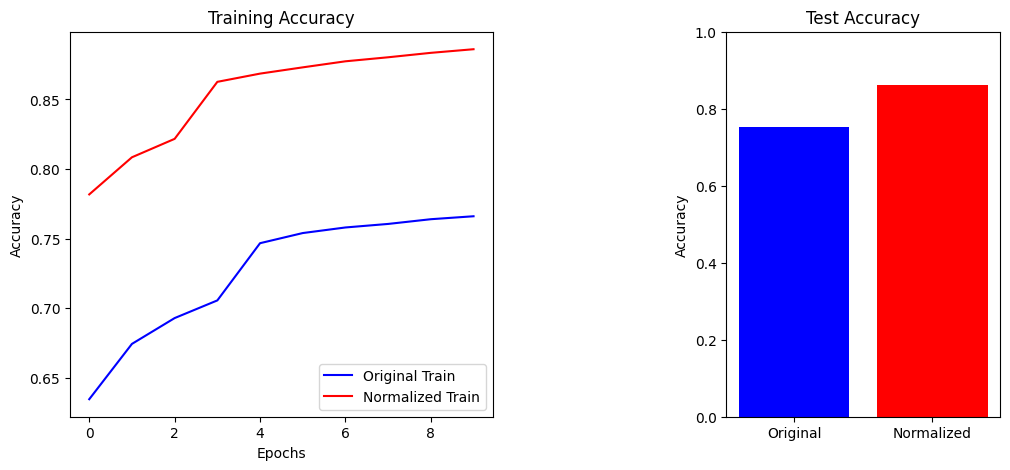

In [ ]:
def normalization_experiment(X_train_mnist_r, X_val_mnist_r, X_test_mnist_r, y_train_mnist_r, y_val_mnist_r, y_test_mnist_r,
                             X_train_mnist, X_val_mnist, X_test_mnist, y_train_mnist, y_val_mnist, y_test_mnist):

    # Define the model configurations
    hidden_layers = [128, 128]
    activation = 'relu'
    weight_init = 'kaiming'
    learning_rate = 0.01
    epochs = 10

    optimizer = MiniBatchSGD(lr=learning_rate, batch_size=128, rs=42)

    # Lists to store results
    original_train_accuracies = []
    original_val_accuracies = []
    normalized_train_accuracies = []
    normalized_val_accuracies = []

    # Train model on unnormalized dataset
    model_original = MLP(activation, hidden_layers, 28*28, 10, weight_init)
    _, _, original_train_accuracies, original_val_accuracies = model_original.fit(X_train_mnist_r, y_train_mnist_r, X_test_mnist_r, y_test_mnist_r, epochs, optimizer_class=optimizer)
    original_test_accuracy = evaluate_acc(y_test_mnist_r, model_original.predict(X_test_mnist_r))

    # Train model on normalized dataset
    model_normalized = MLP(activation, hidden_layers, 28*28, 10, weight_init)
    _, _, normalized_train_accuracies, normalized_val_accuracies = model_normalized.fit(X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist, epochs, optimizer_class=optimizer)
    normalized_test_accuracy = evaluate_acc(y_test_mnist, model_normalized.predict(X_test_mnist))

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(original_train_accuracies, label="Original Train", color='blue')
    plt.plot(normalized_train_accuracies, label="Normalized Train", color='red')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(original_val_accuracies, label="Original Validation", color='blue')
    plt.plot(normalized_val_accuracies, label="Normalized Validation", color='red')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.bar(['Original', 'Normalized'], [original_test_accuracy, normalized_test_accuracy], color=['blue', 'red'])
    plt.title('Test Accuracy')
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# Run the experiment
normalization_experiment(X_train_mnist_r, X_val_mnist_r, X_test_mnist_r, y_train_mnist_r, y_val_mnist_r, y_test_mnist_r,
                             X_train_mnist, X_val_mnist, X_test_mnist, y_train_mnist, y_val_mnist, y_test_mnist)


## 3.6 CNN vs MLP in MINIST (Use GPU to run all PyTorch models)

In [ ]:
len(dataset_train_mnist), len(dataset_val_mnist), len(dataset_test_mnist)

(48000, 12000, 10000)

 20%|██        | 1/5 [00:15<01:00, 15.02s/it]

Epoch is 0 Avg CE (Train): 0.6928826570510864 Avg CE (Val): 0.4384996294975281 Accuracy (Val):  0.8420833349227905


 40%|████      | 2/5 [00:30<00:45, 15.09s/it]

Epoch is 1 Avg CE (Train): 0.39614009857177734 Avg CE (Val): 0.3655240535736084 Accuracy (Val):  0.8677499890327454


 60%|██████    | 3/5 [00:44<00:29, 14.74s/it]

Epoch is 2 Avg CE (Train): 0.34241417050361633 Avg CE (Val): 0.3339848518371582 Accuracy (Val):  0.8815000057220459


 80%|████████  | 4/5 [00:58<00:14, 14.51s/it]

Epoch is 3 Avg CE (Train): 0.313014417886734 Avg CE (Val): 0.3115267753601074 Accuracy (Val):  0.8883333206176758


100%|██████████| 5/5 [01:17<00:00, 15.51s/it]

Epoch is 4 Avg CE (Train): 0.2914960980415344 Avg CE (Val): 0.3207055628299713 Accuracy (Val):  0.8837499618530273


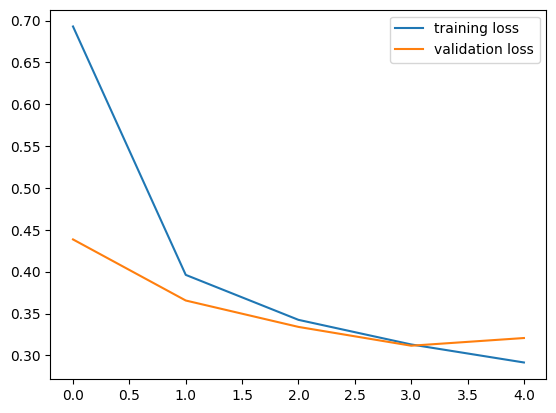

Test accuracy is  0.8759999871253967


 20%|██        | 1/5 [00:15<01:02, 15.70s/it]

Epoch is 0 Avg CE (Train): 0.8427309393882751 Avg CE (Val): 0.5998623967170715 Accuracy (Val):  0.7599999904632568


 40%|████      | 2/5 [00:33<00:50, 16.88s/it]

Epoch is 1 Avg CE (Train): 0.5234261155128479 Avg CE (Val): 0.4890224039554596 Accuracy (Val):  0.8149166703224182


 60%|██████    | 3/5 [00:51<00:34, 17.37s/it]

Epoch is 2 Avg CE (Train): 0.45040857791900635 Avg CE (Val): 0.43774524331092834 Accuracy (Val):  0.8349166512489319


 80%|████████  | 4/5 [01:07<00:16, 16.87s/it]

Epoch is 3 Avg CE (Train): 0.40301093459129333 Avg CE (Val): 0.3853265047073364 Accuracy (Val):  0.8604999780654907


100%|██████████| 5/5 [01:21<00:00, 16.32s/it]

Epoch is 4 Avg CE (Train): 0.37670645117759705 Avg CE (Val): 0.3727998733520508 Accuracy (Val):  0.8650833368301392


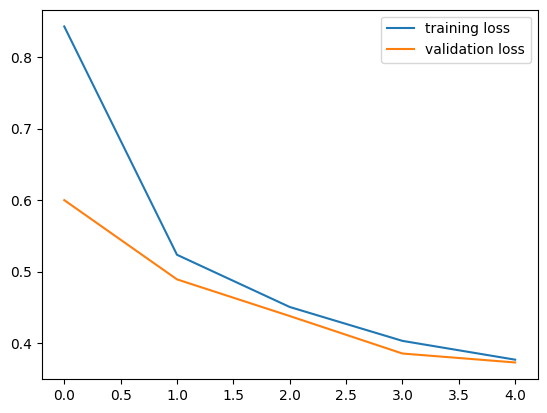

Test accuracy is  0.8562999963760376


 20%|██        | 1/5 [00:14<00:59, 14.96s/it]

Epoch is 0 Avg CE (Train): 1.5935038328170776 Avg CE (Val): 0.9864334464073181 Accuracy (Val):  0.6470000147819519


 40%|████      | 2/5 [00:34<00:53, 17.78s/it]

Epoch is 1 Avg CE (Train): 0.838416576385498 Avg CE (Val): 0.7555954456329346 Accuracy (Val):  0.734083354473114


 60%|██████    | 3/5 [00:52<00:35, 17.89s/it]

Epoch is 2 Avg CE (Train): 0.7013561725616455 Avg CE (Val): 0.6767343878746033 Accuracy (Val):  0.7582499980926514


 80%|████████  | 4/5 [01:11<00:18, 18.08s/it]

Epoch is 3 Avg CE (Train): 0.6385072469711304 Avg CE (Val): 0.62474524974823 Accuracy (Val):  0.7690833210945129


100%|██████████| 5/5 [01:34<00:00, 18.85s/it]

Epoch is 4 Avg CE (Train): 0.596157968044281 Avg CE (Val): 0.5825800895690918 Accuracy (Val):  0.7908333539962769


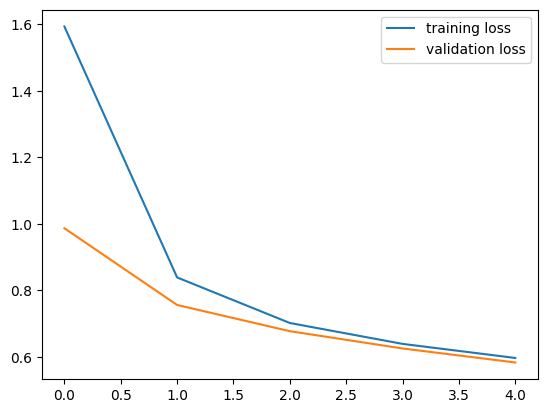

Test accuracy is  0.7874000072479248


In [ ]:
# 3.6 CNN vs MLP in MNIST Fashion (kernel_size=3)
class SimpleCNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.dense1 = torch.nn.Linear(64 * 7 * 7, 128)  # new dense layer
        self.dropout = torch.nn.Dropout(0.5)
        self.dense2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = torch.flatten(x, start_dim=1)
        x = self.dense1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)

        return x

# Load to DataLoader
dataloader_train, dataloader_val, dataloader_test = train_val_test_data_loader(dataset_train_mnist, dataset_val_mnist, dataset_test_mnist,
                                                                               batch_size=128)

lr_list = [0.5, 0.05, 0.005]
acc_list =[]
for lr in lr_list:
  model = SimpleCNN()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  device = torch.device('cuda')
  model.to(device)
  L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)
  plot_training_vs_val_loss(L_vals_train, L_vals_val)
  acc_list.append(test_acc_gpu(model, dataloader_test, device))

In [ ]:
print(acc_list)

[0.8759999871253967, 0.8562999963760376, 0.7874000072479248]


 20%|██        | 1/5 [00:14<00:59, 14.90s/it]

Epoch is 0 Avg CE (Train): nan Avg CE (Val): nan Accuracy (Val):  0.09775000065565109


 40%|████      | 2/5 [00:32<00:50, 16.71s/it]

Epoch is 1 Avg CE (Train): nan Avg CE (Val): nan Accuracy (Val):  0.09775000065565109


 60%|██████    | 3/5 [00:50<00:33, 16.95s/it]

Epoch is 2 Avg CE (Train): nan Avg CE (Val): nan Accuracy (Val):  0.09775000065565109


 80%|████████  | 4/5 [01:10<00:18, 18.16s/it]

Epoch is 3 Avg CE (Train): nan Avg CE (Val): nan Accuracy (Val):  0.09775000065565109


100%|██████████| 5/5 [01:29<00:00, 17.99s/it]

Epoch is 4 Avg CE (Train): nan Avg CE (Val): nan Accuracy (Val):  0.09775000065565109


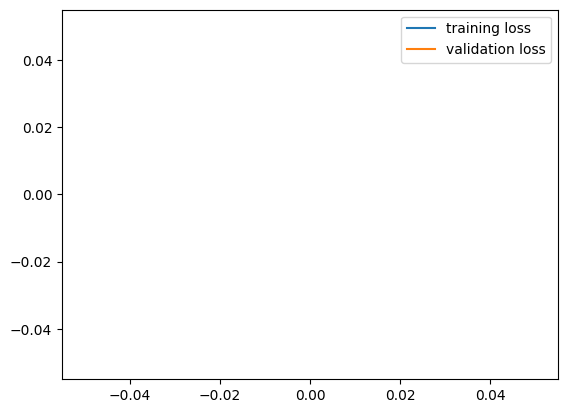

Test accuracy is  0.09999999403953552


 20%|██        | 1/5 [00:16<01:05, 16.43s/it]

Epoch is 0 Avg CE (Train): 0.835965633392334 Avg CE (Val): 0.587637186050415 Accuracy (Val):  0.7754166722297668


 40%|████      | 2/5 [00:30<00:45, 15.11s/it]

Epoch is 1 Avg CE (Train): 0.5262059569358826 Avg CE (Val): 0.49111825227737427 Accuracy (Val):  0.8162499666213989


 60%|██████    | 3/5 [00:44<00:29, 14.59s/it]

Epoch is 2 Avg CE (Train): 0.45304206013679504 Avg CE (Val): 0.4281100332736969 Accuracy (Val):  0.8454999923706055


 80%|████████  | 4/5 [00:58<00:14, 14.40s/it]

Epoch is 3 Avg CE (Train): 0.40618404746055603 Avg CE (Val): 0.3867652416229248 Accuracy (Val):  0.859250009059906


100%|██████████| 5/5 [01:13<00:00, 14.65s/it]

Epoch is 4 Avg CE (Train): 0.3724665343761444 Avg CE (Val): 0.3698504567146301 Accuracy (Val):  0.8646666407585144


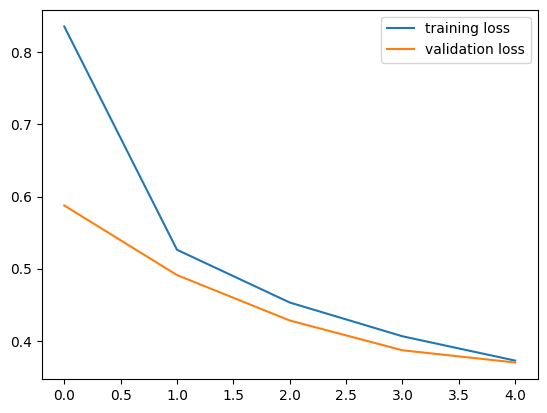

Test accuracy is  0.8549999594688416


 20%|██        | 1/5 [00:14<00:56, 14.12s/it]

Epoch is 0 Avg CE (Train): 1.517438292503357 Avg CE (Val): 0.9474969506263733 Accuracy (Val):  0.6668333411216736


 40%|████      | 2/5 [00:28<00:42, 14.01s/it]

Epoch is 1 Avg CE (Train): 0.8267049193382263 Avg CE (Val): 0.7514269948005676 Accuracy (Val):  0.7239166498184204


 60%|██████    | 3/5 [00:42<00:28, 14.03s/it]

Epoch is 2 Avg CE (Train): 0.7055973410606384 Avg CE (Val): 0.6931615471839905 Accuracy (Val):  0.7381666302680969


 80%|████████  | 4/5 [00:56<00:14, 14.03s/it]

Epoch is 3 Avg CE (Train): 0.6412482261657715 Avg CE (Val): 0.6249943375587463 Accuracy (Val):  0.7684999704360962


100%|██████████| 5/5 [01:10<00:00, 14.05s/it]

Epoch is 4 Avg CE (Train): 0.5982573628425598 Avg CE (Val): 0.5950046181678772 Accuracy (Val):  0.7796666622161865


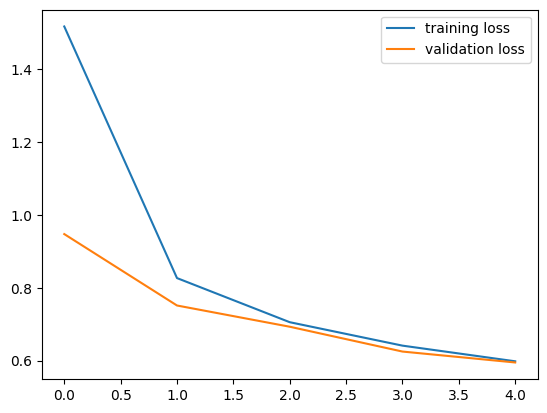

Test accuracy is  0.774399995803833


In [ ]:
# 3.6 CNN vs MLP in MNIST Fashion (kernel_size=6)
class SimpleCNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, padding='same')
        self.dense1 = torch.nn.Linear(64 * 7 * 7, 128)  # new dense layer
        self.dropout = torch.nn.Dropout(0.5)
        self.dense2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = torch.flatten(x, start_dim=1)
        x = self.dense1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)

        return x



acc_list_k6 =[]
for lr in lr_list:
  model = SimpleCNN()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  device = torch.device('cuda')
  model.to(device)
  L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)
  plot_training_vs_val_loss(L_vals_train, L_vals_val)
  acc_list_k6.append(test_acc_gpu(model, dataloader_test, device))

In [ ]:
acc_list_k5 = acc_list_k6
def plot_lr_acc(lr_list, acc_list, acc_list_2):
  plt.figure(figsize=(10,6))
  plt.plot(lr_list, acc_list, marker='o', linestyle='-', label='Kernel Size 3')
  plt.plot(lr_list, acc_list_2, marker='x', linestyle='-', color='red', label='Kernel Size 5')
  plt.xscale('log')  # Since learning rates are often varied in log scale
  plt.xlabel('Learning Rate')
  plt.ylabel('Test Accuracy')
  plt.title('Test Accuracy vs Learning Rate')
  plt.grid(True, which="both", ls="--")
  plt.legend()
  plt.show()

In [ ]:
acc_list, acc_list_k5

([0.8759999871253967, 0.8562999963760376, 0.7874000072479248],
 [0.09999999403953552, 0.8549999594688416, 0.774399995803833])

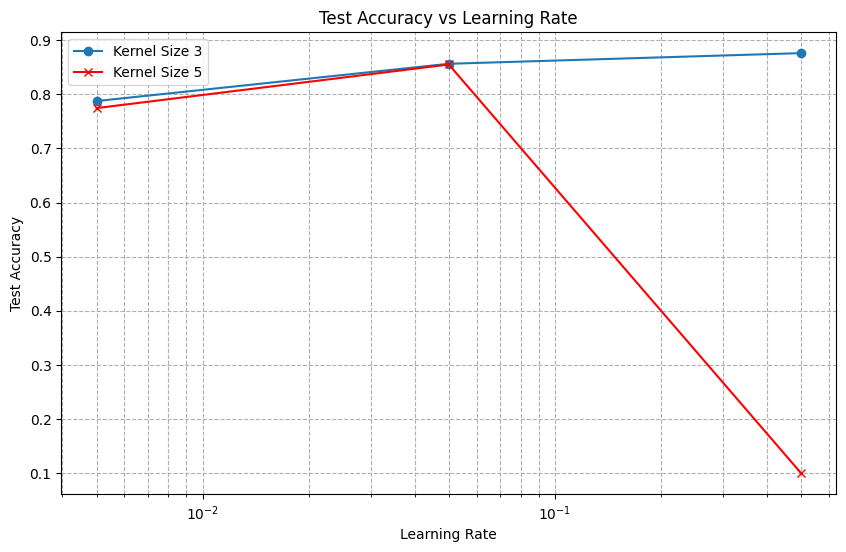

In [ ]:
plot_lr_acc(lr_list, acc_list, acc_list_k5)

When the Learning rate is 0.5 and the Convolutional layers' kernel size is 3, this simple CNN can achive 0.88 accuracy using 5 epochs.

This CNN comprises two convolutional layers, two max-pooling layers, two fully connected layers, and a dropout layer. ReLU serves as the activation function following both convolutional layers and the hidden dense layer. When trained with a consistent batch size of 128, a multi-layer perceptron (MLP) yields an accuracy of 0.82 to 0.85 on the test set. In contrast, this simple CNN boosts the accuracy to 0.88 on the same test set with only 5 epochs (MLP uses 10 epochs), given both models use the same training data.

However, the improvement, while notable, isn't drastic. A plausible explanation is the relatively small size of the images in the original dataset and the easily discernible patterns they contain. This makes an MLP sufficiently adept at classifying these images without necessitating a more complex model.

## 3.7 CNN vs MLP in CIFAR-10

### 3.7.1 MLP

In [ ]:
y_train_cifar = np.eye(len(np.unique(y_train_cifar)))[y_train_cifar]
y_val_cifar = np.eye(len(np.unique(y_val_cifar)))[y_val_cifar]
y_test_cifar = np.eye(len(np.unique(y_test_cifar)))[y_test_cifar]

[3072, 128, 128, 10]


 10%|█         | 1/10 [00:07<01:08,  7.58s/it]

Epoch 1/10
Train Loss: 2.0160, Train Accuracy: 39.52%
Val Loss: 1.8163, Val Accuracy: 38.30%
--------------------------------------------------


 20%|██        | 2/10 [00:13<00:54,  6.85s/it]

Epoch 2/10
Train Loss: 1.7299, Train Accuracy: 44.00%
Val Loss: 1.7082, Val Accuracy: 41.84%
--------------------------------------------------


 30%|███       | 3/10 [00:21<00:49,  7.11s/it]

Epoch 3/10
Train Loss: 1.6256, Train Accuracy: 46.85%
Val Loss: 1.6435, Val Accuracy: 43.66%
--------------------------------------------------


 40%|████      | 4/10 [00:27<00:40,  6.78s/it]

Epoch 4/10
Train Loss: 1.5563, Train Accuracy: 48.70%
Val Loss: 1.6059, Val Accuracy: 45.15%
--------------------------------------------------


 50%|█████     | 5/10 [00:35<00:35,  7.11s/it]

Epoch 5/10
Train Loss: 1.5046, Train Accuracy: 50.03%
Val Loss: 1.5824, Val Accuracy: 45.75%
--------------------------------------------------


 60%|██████    | 6/10 [00:41<00:27,  6.82s/it]

Epoch 6/10
Train Loss: 1.4632, Train Accuracy: 51.41%
Val Loss: 1.5632, Val Accuracy: 46.21%
--------------------------------------------------


 70%|███████   | 7/10 [00:49<00:21,  7.10s/it]

Epoch 7/10
Train Loss: 1.4280, Train Accuracy: 52.47%
Val Loss: 1.5466, Val Accuracy: 46.56%
--------------------------------------------------


 80%|████████  | 8/10 [00:55<00:13,  6.85s/it]

Epoch 8/10
Train Loss: 1.3973, Train Accuracy: 53.46%
Val Loss: 1.5339, Val Accuracy: 46.83%
--------------------------------------------------


 90%|█████████ | 9/10 [01:03<00:07,  7.14s/it]

Epoch 9/10
Train Loss: 1.3696, Train Accuracy: 54.37%
Val Loss: 1.5236, Val Accuracy: 47.33%
--------------------------------------------------


100%|██████████| 10/10 [01:10<00:00,  7.04s/it]

Epoch 10/10
Train Loss: 1.3441, Train Accuracy: 55.23%
Val Loss: 1.5127, Val Accuracy: 47.76%
--------------------------------------------------


The Test Accuracy: 47.599999999999994%
--------------------------------------------------


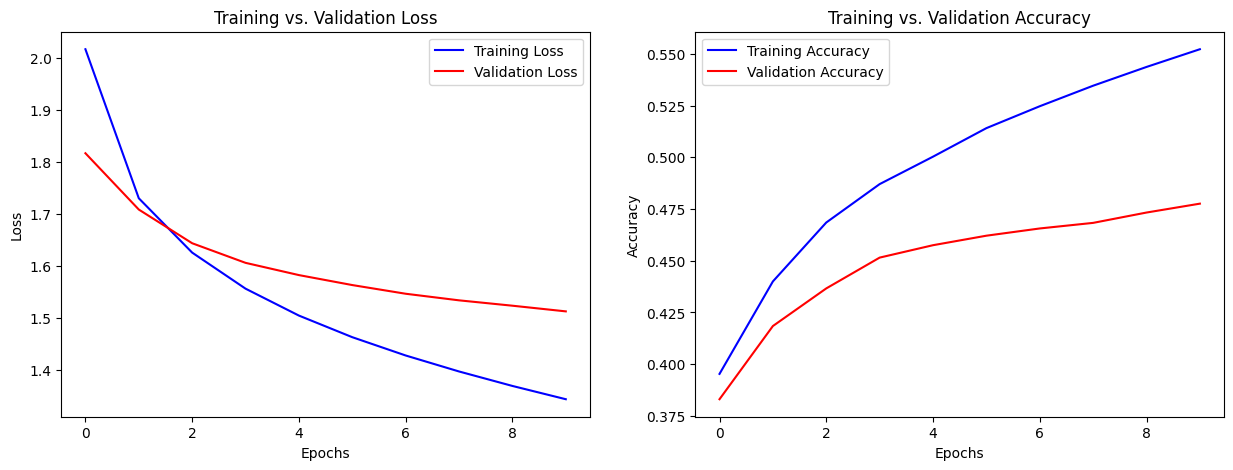

In [ ]:
# Initialize your MLP model
model = MLP(activation_name='relu',
            hidden_layers_sizes=[128, 128],
            input_sizes=X_train_cifar.shape[1],
            output_sizes=y_train_cifar.shape[1],
            weight_init='kaiming'
            )

# Train the model with batches
optimizer = MiniBatchSGD(lr=0.005, batch_size=128, rs=52)
train_losses, val_losses, train_accuracy, val_accuracy = model.fit(
    X_train=X_train_cifar,
    y_train=y_train_cifar,
    X_val=X_val_cifar,
    y_val=y_val_cifar,
    num_of_epoch=10,
    optimizer_class=optimizer
)


# Print the test accuracy
y_pred = model.predict(X_test_cifar)
test_acc = evaluate_acc(y_true=y_test_cifar, y_pred=y_pred)
test_acc_percentage = test_acc * 100
print(f"The Test Accuracy: {test_acc_percentage}%")
print('-' * 50)

# Plot the loss and accuracy graph
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

### 3.7.2 CNN

In [ ]:
len(dataset_train_cifar), len(dataset_val_cifar), len(dataset_test_cifar)

(40000, 10000, 10000)

 10%|█         | 1/10 [00:14<02:10, 14.52s/it]

Epoch is 0 Avg CE (Train): 1.7864012718200684 Avg CE (Val): 1.5623234510421753 Accuracy (Val):  0.42989999055862427


 20%|██        | 2/10 [00:32<02:14, 16.78s/it]

Epoch is 1 Avg CE (Train): 1.4115158319473267 Avg CE (Val): 1.3834247589111328 Accuracy (Val):  0.5049999952316284


 30%|███       | 3/10 [00:55<02:15, 19.29s/it]

Epoch is 2 Avg CE (Train): 1.235749363899231 Avg CE (Val): 1.2601693868637085 Accuracy (Val):  0.5547999739646912


 40%|████      | 4/10 [01:17<02:02, 20.36s/it]

Epoch is 3 Avg CE (Train): 1.1071110963821411 Avg CE (Val): 1.194651484489441 Accuracy (Val):  0.5755000114440918


 50%|█████     | 5/10 [01:33<01:34, 18.94s/it]

Epoch is 4 Avg CE (Train): 1.0162467956542969 Avg CE (Val): 1.1457394361495972 Accuracy (Val):  0.614300012588501


 60%|██████    | 6/10 [01:47<01:09, 17.38s/it]

Epoch is 5 Avg CE (Train): 0.941874086856842 Avg CE (Val): 1.0712370872497559 Accuracy (Val):  0.6328999996185303


 70%|███████   | 7/10 [02:02<00:49, 16.51s/it]

Epoch is 6 Avg CE (Train): 0.8759703636169434 Avg CE (Val): 1.0474709272384644 Accuracy (Val):  0.63919997215271


 80%|████████  | 8/10 [02:17<00:31, 15.94s/it]

Epoch is 7 Avg CE (Train): 0.8187190890312195 Avg CE (Val): 1.0538012981414795 Accuracy (Val):  0.6495999693870544


 90%|█████████ | 9/10 [02:31<00:15, 15.47s/it]

Epoch is 8 Avg CE (Train): 0.7606140375137329 Avg CE (Val): 1.0251699686050415 Accuracy (Val):  0.6625999808311462


100%|██████████| 10/10 [02:46<00:00, 16.62s/it]

Epoch is 9 Avg CE (Train): 0.7155670523643494 Avg CE (Val): 1.0387719869613647 Accuracy (Val):  0.6496999859809875


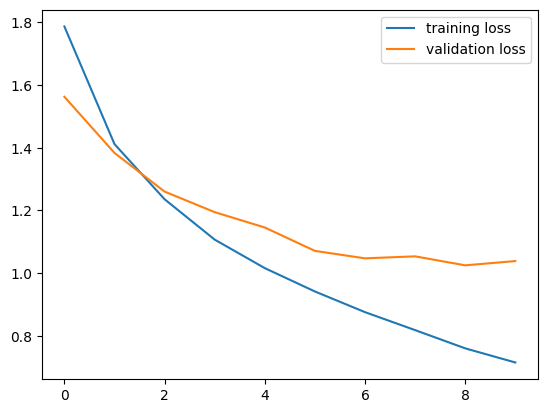

Test accuracy is  0.6506999731063843


 10%|█         | 1/10 [00:15<02:19, 15.50s/it]

Epoch is 0 Avg CE (Train): 2.160752296447754 Avg CE (Val): 2.0119738578796387 Accuracy (Val):  0.27699998021125793


 20%|██        | 2/10 [00:30<02:01, 15.18s/it]

Epoch is 1 Avg CE (Train): 1.9044541120529175 Avg CE (Val): 1.833189606666565 Accuracy (Val):  0.34129998087882996


 30%|███       | 3/10 [00:44<01:43, 14.77s/it]

Epoch is 2 Avg CE (Train): 1.7478976249694824 Avg CE (Val): 1.6869068145751953 Accuracy (Val):  0.39819997549057007


 40%|████      | 4/10 [01:00<01:32, 15.36s/it]

Epoch is 3 Avg CE (Train): 1.6214133501052856 Avg CE (Val): 1.5933266878128052 Accuracy (Val):  0.4260999858379364


 50%|█████     | 5/10 [01:15<01:14, 14.97s/it]

Epoch is 4 Avg CE (Train): 1.5363129377365112 Avg CE (Val): 1.5262446403503418 Accuracy (Val):  0.4503999948501587


 60%|██████    | 6/10 [01:32<01:02, 15.72s/it]

Epoch is 5 Avg CE (Train): 1.4769587516784668 Avg CE (Val): 1.5091440677642822 Accuracy (Val):  0.45749998092651367


 70%|███████   | 7/10 [01:46<00:45, 15.27s/it]

Epoch is 6 Avg CE (Train): 1.4332691431045532 Avg CE (Val): 1.434829831123352 Accuracy (Val):  0.47919997572898865


 80%|████████  | 8/10 [02:01<00:29, 14.98s/it]

Epoch is 7 Avg CE (Train): 1.3952629566192627 Avg CE (Val): 1.3858733177185059 Accuracy (Val):  0.5051000118255615


 90%|█████████ | 9/10 [02:16<00:15, 15.07s/it]

Epoch is 8 Avg CE (Train): 1.3562184572219849 Avg CE (Val): 1.382623553276062 Accuracy (Val):  0.507099986076355


100%|██████████| 10/10 [02:31<00:00, 15.12s/it]

Epoch is 9 Avg CE (Train): 1.3230044841766357 Avg CE (Val): 1.3519060611724854 Accuracy (Val):  0.5074999928474426


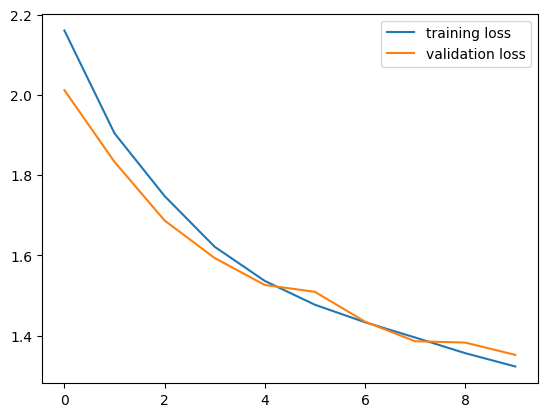

Test accuracy is  0.5231999754905701


 10%|█         | 1/10 [00:14<02:14, 14.95s/it]

Epoch is 0 Avg CE (Train): 2.2921853065490723 Avg CE (Val): 2.2817184925079346 Accuracy (Val):  0.16269999742507935


 20%|██        | 2/10 [00:29<01:59, 14.90s/it]

Epoch is 1 Avg CE (Train): 2.2713851928710938 Avg CE (Val): 2.2620301246643066 Accuracy (Val):  0.1850000023841858


 30%|███       | 3/10 [00:46<01:49, 15.68s/it]

Epoch is 2 Avg CE (Train): 2.2466461658477783 Avg CE (Val): 2.2305705547332764 Accuracy (Val):  0.20969998836517334


 40%|████      | 4/10 [01:07<01:46, 17.74s/it]

Epoch is 3 Avg CE (Train): 2.211920738220215 Avg CE (Val): 2.194689989089966 Accuracy (Val):  0.21930000185966492


 50%|█████     | 5/10 [01:29<01:37, 19.50s/it]

Epoch is 4 Avg CE (Train): 2.1724660396575928 Avg CE (Val): 2.15301513671875 Accuracy (Val):  0.2305999994277954


 60%|██████    | 6/10 [01:48<01:16, 19.14s/it]

Epoch is 5 Avg CE (Train): 2.1299965381622314 Avg CE (Val): 2.108642816543579 Accuracy (Val):  0.2556999921798706


 70%|███████   | 7/10 [02:07<00:57, 19.18s/it]

Epoch is 6 Avg CE (Train): 2.09334659576416 Avg CE (Val): 2.0758166313171387 Accuracy (Val):  0.2590999901294708


 80%|████████  | 8/10 [02:23<00:36, 18.03s/it]

Epoch is 7 Avg CE (Train): 2.057096481323242 Avg CE (Val): 2.0361006259918213 Accuracy (Val):  0.2687999904155731


 90%|█████████ | 9/10 [02:51<00:21, 21.36s/it]

Epoch is 8 Avg CE (Train): 2.0244388580322266 Avg CE (Val): 2.002448558807373 Accuracy (Val):  0.28679999709129333


100%|██████████| 10/10 [03:11<00:00, 19.20s/it]

Epoch is 9 Avg CE (Train): 1.995568871498108 Avg CE (Val): 1.9709391593933105 Accuracy (Val):  0.29739999771118164


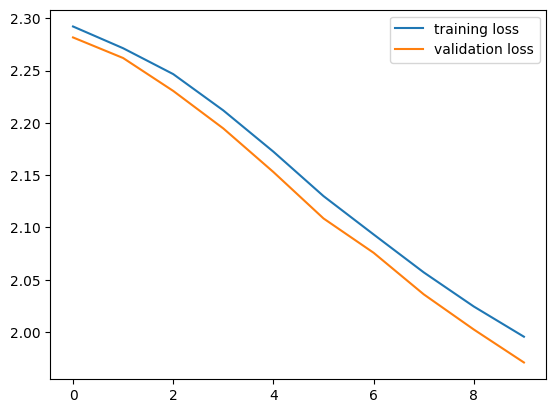

Test accuracy is  0.30239999294281006


In [ ]:
# 3.6 CNN vs MLP in CIFAR Fashion
class SimpleCNN_cifar(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.dense1 = torch.nn.Linear(64 * 8 * 8, 128)  # new dense layer
        self.dropout = torch.nn.Dropout(0.5)
        self.dense2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = torch.flatten(x, start_dim=1)
        x = self.dense1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)

        return x


# Load to DataLoader
dataloader_train, dataloader_val, dataloader_test = train_val_test_data_loader(dataset_train_cifar, dataset_val_cifar,dataset_test_cifar,
                                                                               batch_size=128)
lr_list = [0.1, 0.01, 0.001]
acc_list_cifar =[]
for lr in lr_list:
  model = SimpleCNN_cifar()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  device = torch.device('cuda')
  model.to(device)
  L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 10, device = device)
  plot_training_vs_val_loss(L_vals_train, L_vals_val)
  acc_list_cifar.append(test_acc_gpu(model, dataloader_test, device))

 10%|█         | 1/10 [00:14<02:10, 14.48s/it]

Epoch is 0 Avg CE (Train): 1.780271291732788 Avg CE (Val): 1.5066044330596924 Accuracy (Val):  0.4537999927997589


 20%|██        | 2/10 [00:29<01:59, 14.98s/it]

Epoch is 1 Avg CE (Train): 1.406355381011963 Avg CE (Val): 1.64031183719635 Accuracy (Val):  0.4388999938964844


 30%|███       | 3/10 [00:44<01:43, 14.82s/it]

Epoch is 2 Avg CE (Train): 1.2180901765823364 Avg CE (Val): 1.212369680404663 Accuracy (Val):  0.5723999738693237


 40%|████      | 4/10 [00:59<01:29, 14.98s/it]

Epoch is 3 Avg CE (Train): 1.0807594060897827 Avg CE (Val): 1.1267081499099731 Accuracy (Val):  0.6072999835014343


 50%|█████     | 5/10 [01:14<01:13, 14.77s/it]

Epoch is 4 Avg CE (Train): 0.985531210899353 Avg CE (Val): 1.0804208517074585 Accuracy (Val):  0.6301000118255615


 60%|██████    | 6/10 [01:28<00:58, 14.68s/it]

Epoch is 5 Avg CE (Train): 0.9046663045883179 Avg CE (Val): 1.1227641105651855 Accuracy (Val):  0.621399998664856


 70%|███████   | 7/10 [01:43<00:44, 14.89s/it]

Epoch is 6 Avg CE (Train): 0.8297378420829773 Avg CE (Val): 1.1130554676055908 Accuracy (Val):  0.6225000023841858


 80%|████████  | 8/10 [01:58<00:29, 14.89s/it]

Epoch is 7 Avg CE (Train): 0.7712287306785583 Avg CE (Val): 1.1009387969970703 Accuracy (Val):  0.6344000101089478


 90%|█████████ | 9/10 [02:14<00:15, 15.08s/it]

Epoch is 8 Avg CE (Train): 0.7104499340057373 Avg CE (Val): 0.985375165939331 Accuracy (Val):  0.6736999750137329


100%|██████████| 10/10 [02:28<00:00, 14.90s/it]

Epoch is 9 Avg CE (Train): 0.660499095916748 Avg CE (Val): 0.9991545677185059 Accuracy (Val):  0.6710999608039856


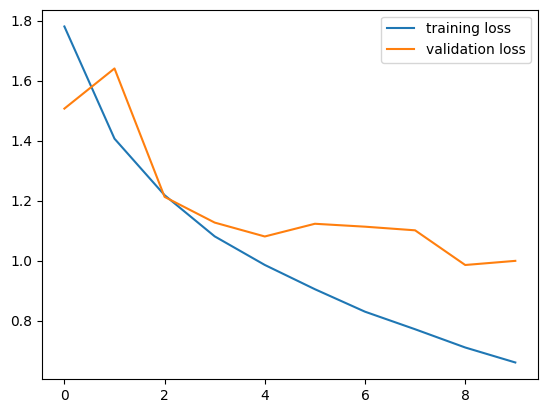

Test accuracy is  0.661300003528595


 10%|█         | 1/10 [00:15<02:23, 15.98s/it]

Epoch is 0 Avg CE (Train): 2.0898008346557617 Avg CE (Val): 1.9149872064590454 Accuracy (Val):  0.3105999827384949


 20%|██        | 2/10 [00:31<02:05, 15.74s/it]

Epoch is 1 Avg CE (Train): 1.818691372871399 Avg CE (Val): 1.7167807817459106 Accuracy (Val):  0.376800000667572


 30%|███       | 3/10 [00:51<02:03, 17.64s/it]

Epoch is 2 Avg CE (Train): 1.6652443408966064 Avg CE (Val): 1.606192946434021 Accuracy (Val):  0.41599997878074646


 40%|████      | 4/10 [01:07<01:41, 16.86s/it]

Epoch is 3 Avg CE (Train): 1.5756480693817139 Avg CE (Val): 1.562034249305725 Accuracy (Val):  0.4423999786376953


 50%|█████     | 5/10 [01:21<01:19, 15.96s/it]

Epoch is 4 Avg CE (Train): 1.5081301927566528 Avg CE (Val): 1.4907199144363403 Accuracy (Val):  0.4648999869823456


 60%|██████    | 6/10 [01:39<01:06, 16.54s/it]

Epoch is 5 Avg CE (Train): 1.4536395072937012 Avg CE (Val): 1.493129849433899 Accuracy (Val):  0.4616999924182892


 70%|███████   | 7/10 [02:01<00:55, 18.41s/it]

Epoch is 6 Avg CE (Train): 1.4089734554290771 Avg CE (Val): 1.4073964357376099 Accuracy (Val):  0.48649999499320984


 80%|████████  | 8/10 [02:19<00:36, 18.17s/it]

Epoch is 7 Avg CE (Train): 1.365936517715454 Avg CE (Val): 1.3770561218261719 Accuracy (Val):  0.505899965763092


 90%|█████████ | 9/10 [02:42<00:19, 19.67s/it]

Epoch is 8 Avg CE (Train): 1.3258025646209717 Avg CE (Val): 1.3428272008895874 Accuracy (Val):  0.5181999802589417


100%|██████████| 10/10 [03:01<00:00, 18.16s/it]

Epoch is 9 Avg CE (Train): 1.2920531034469604 Avg CE (Val): 1.3126184940338135 Accuracy (Val):  0.5254999995231628


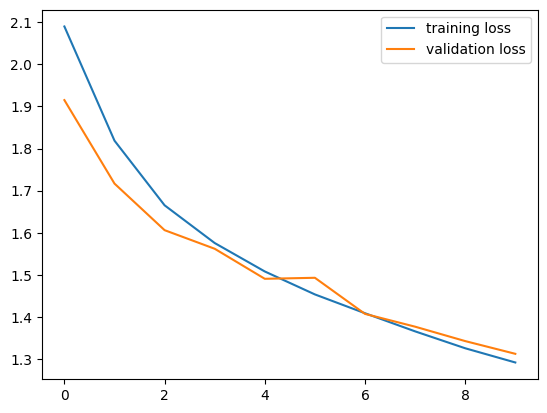

Test accuracy is  0.5242999792098999


 10%|█         | 1/10 [00:17<02:40, 17.84s/it]

Epoch is 0 Avg CE (Train): 2.2909064292907715 Avg CE (Val): 2.2763614654541016 Accuracy (Val):  0.1437000036239624


 20%|██        | 2/10 [00:39<02:39, 19.92s/it]

Epoch is 1 Avg CE (Train): 2.2559831142425537 Avg CE (Val): 2.233917713165283 Accuracy (Val):  0.19820000231266022


 30%|███       | 3/10 [00:59<02:21, 20.15s/it]

Epoch is 2 Avg CE (Train): 2.206484794616699 Avg CE (Val): 2.178826332092285 Accuracy (Val):  0.22349999845027924


 40%|████      | 4/10 [01:22<02:06, 21.08s/it]

Epoch is 3 Avg CE (Train): 2.151287794113159 Avg CE (Val): 2.1215872764587402 Accuracy (Val):  0.24390000104904175


 50%|█████     | 5/10 [01:39<01:39, 19.84s/it]

Epoch is 4 Avg CE (Train): 2.1014158725738525 Avg CE (Val): 2.0762441158294678 Accuracy (Val):  0.2572999894618988


 60%|██████    | 6/10 [01:59<01:18, 19.67s/it]

Epoch is 5 Avg CE (Train): 2.0570881366729736 Avg CE (Val): 2.032665967941284 Accuracy (Val):  0.2766999900341034


 70%|███████   | 7/10 [02:23<01:03, 21.23s/it]

Epoch is 6 Avg CE (Train): 2.018028974533081 Avg CE (Val): 1.9907331466674805 Accuracy (Val):  0.2883000075817108


 80%|████████  | 8/10 [02:38<00:38, 19.33s/it]

Epoch is 7 Avg CE (Train): 1.9821664094924927 Avg CE (Val): 1.9539388418197632 Accuracy (Val):  0.296099990606308


 90%|█████████ | 9/10 [02:53<00:17, 17.81s/it]

Epoch is 8 Avg CE (Train): 1.9527206420898438 Avg CE (Val): 1.9277194738388062 Accuracy (Val):  0.3107999861240387


100%|██████████| 10/10 [03:07<00:00, 18.78s/it]

Epoch is 9 Avg CE (Train): 1.9187114238739014 Avg CE (Val): 1.8981820344924927 Accuracy (Val):  0.31869998574256897


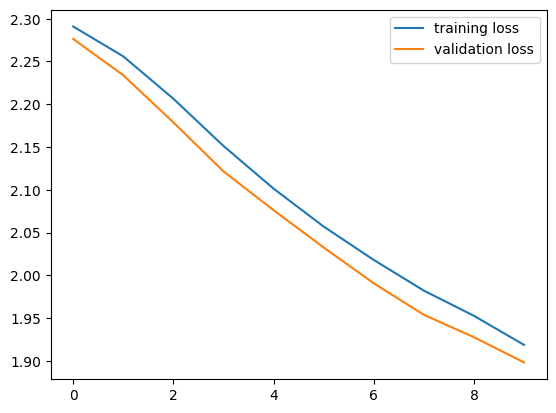

Test accuracy is  0.3319000005722046


In [ ]:
# 3.6 CNN vs MLP in CIFAR Fashion
class SimpleCNN_cifar(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, padding='same')
        self.dense1 = torch.nn.Linear(64 * 8 * 8, 128)  # new dense layer
        self.dropout = torch.nn.Dropout(0.5)
        self.dense2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)

        x = torch.flatten(x, start_dim=1)
        x = self.dense1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)

        return x


# Load to DataLoader
dataloader_train, dataloader_val, dataloader_test = train_val_test_data_loader(dataset_train_cifar, dataset_val_cifar,dataset_test_cifar,
                                                                               batch_size=128)

acc_list_cifar_k5 =[]
for lr in lr_list:
  model = SimpleCNN_cifar()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  device = torch.device('cuda')
  model.to(device)
  L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 10, device = device)
  plot_training_vs_val_loss(L_vals_train, L_vals_val)
  acc_list_cifar_k5.append(test_acc_gpu(model, dataloader_test, device))

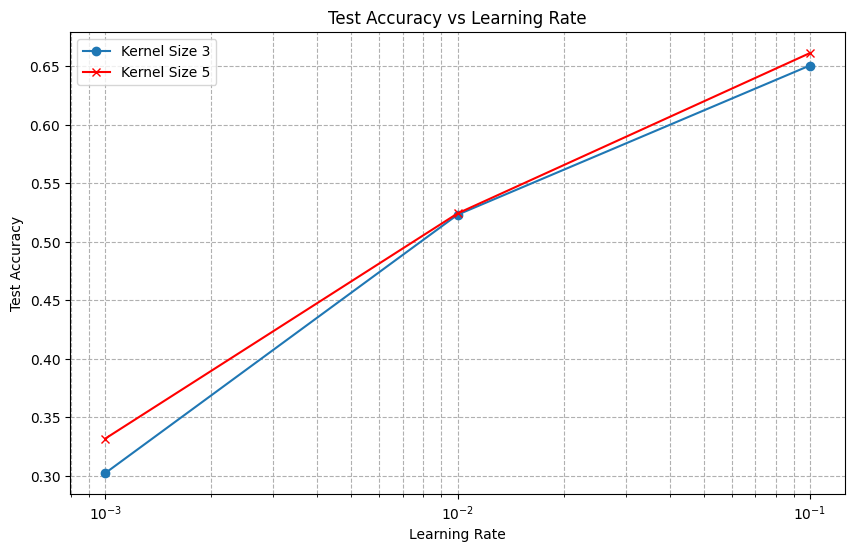

In [ ]:
plot_lr_acc(lr_list, acc_list_cifar, acc_list_cifar_k5)

When the Learning rate is 0.1 and the Convolutional layers' kernel size is 5, this simple CNN can achive 0.66 accuracy using 10 epochs for CIFAR-10 dataset. One observation is kernel size 5 has better performance than size 3 in RGB dataset like CIFAR but has similar performance in single color dataset like MINIST. One potentail reason is RGB image has more complex patterns and it needs bigger kernel to capture more spatial information.

Using a MLP with two hidden layers, 128 units, ReLU activation, Kaiming weight initialization, and a batch size of 128, we observed that the accuracy remained below 0.5. This underscores the notion that MLP struggles to discern patterns from RGB images effectively.

In contrast, using a simple CNN with the identical structure from Task 3.6, led to a significant leap in accuracy, pushing it well above 0.6. This outcome reinforces the hypothesis presented in Task 3.6, suggesting that the disparity in performance between CNNs and MLPs becomes more obevious as the complexity of features in the dataset increases. The reason is CNN has ability to capture more complex and abstract patterns through Convolutional layers.

## 3.8 Different momemntum vs Adam using CNN in CIFAR-10

### 3.8.1 Experment different momentum

Set momentgum in SGD optimizer as:  0.3


 10%|█         | 1/10 [00:15<02:17, 15.30s/it]

Epoch is 0 Avg CE (Train): 1.7024149894714355 Avg CE (Val): 1.4762649536132812 Accuracy (Val):  0.46389999985694885


 20%|██        | 2/10 [00:29<01:57, 14.74s/it]

Epoch is 1 Avg CE (Train): 1.3327445983886719 Avg CE (Val): 1.2816340923309326 Accuracy (Val):  0.5378000140190125


 30%|███       | 3/10 [00:44<01:44, 14.96s/it]

Epoch is 2 Avg CE (Train): 1.1622517108917236 Avg CE (Val): 1.2318248748779297 Accuracy (Val):  0.5708999633789062


 40%|████      | 4/10 [01:00<01:30, 15.16s/it]

Epoch is 3 Avg CE (Train): 1.0474671125411987 Avg CE (Val): 1.1007415056228638 Accuracy (Val):  0.6164000034332275


 50%|█████     | 5/10 [01:21<01:27, 17.41s/it]

Epoch is 4 Avg CE (Train): 0.9587833881378174 Avg CE (Val): 1.1704517602920532 Accuracy (Val):  0.6036999821662903


 60%|██████    | 6/10 [01:44<01:16, 19.09s/it]

Epoch is 5 Avg CE (Train): 0.8755014538764954 Avg CE (Val): 1.1130506992340088 Accuracy (Val):  0.616599977016449


 70%|███████   | 7/10 [02:02<00:56, 18.90s/it]

Epoch is 6 Avg CE (Train): 0.8133487701416016 Avg CE (Val): 1.033996820449829 Accuracy (Val):  0.6538999676704407


 80%|████████  | 8/10 [02:22<00:38, 19.30s/it]

Epoch is 7 Avg CE (Train): 0.7531242370605469 Avg CE (Val): 1.0068819522857666 Accuracy (Val):  0.6675999760627747


 90%|█████████ | 9/10 [02:37<00:17, 17.81s/it]

Epoch is 8 Avg CE (Train): 0.6952975988388062 Avg CE (Val): 0.9677850604057312 Accuracy (Val):  0.6803999543190002


100%|██████████| 10/10 [02:52<00:00, 17.30s/it]

Epoch is 9 Avg CE (Train): 0.643840491771698 Avg CE (Val): 1.0996642112731934 Accuracy (Val):  0.6579999923706055


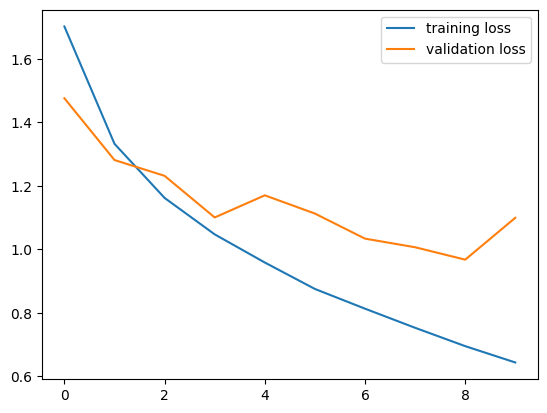

Test accuracy is  0.6539999842643738
Set momentgum in SGD optimizer as:  0.6


 10%|█         | 1/10 [00:17<02:38, 17.57s/it]

Epoch is 0 Avg CE (Train): 1.632122278213501 Avg CE (Val): 1.4131094217300415 Accuracy (Val):  0.49949997663497925


 20%|██        | 2/10 [00:33<02:11, 16.39s/it]

Epoch is 1 Avg CE (Train): 1.2474459409713745 Avg CE (Val): 1.1666508913040161 Accuracy (Val):  0.5798999667167664


 30%|███       | 3/10 [00:47<01:49, 15.63s/it]

Epoch is 2 Avg CE (Train): 1.075582504272461 Avg CE (Val): 1.1012966632843018 Accuracy (Val):  0.6121000051498413


 40%|████      | 4/10 [01:02<01:32, 15.37s/it]

Epoch is 3 Avg CE (Train): 0.9696642160415649 Avg CE (Val): 1.0513911247253418 Accuracy (Val):  0.6331999897956848


 50%|█████     | 5/10 [01:21<01:22, 16.58s/it]

Epoch is 4 Avg CE (Train): 0.874927818775177 Avg CE (Val): 1.0430643558502197 Accuracy (Val):  0.6322000026702881


 60%|██████    | 6/10 [01:41<01:11, 17.88s/it]

Epoch is 5 Avg CE (Train): 0.8081968426704407 Avg CE (Val): 1.0819036960601807 Accuracy (Val):  0.6366999745368958


 70%|███████   | 7/10 [01:58<00:52, 17.42s/it]

Epoch is 6 Avg CE (Train): 0.750978410243988 Avg CE (Val): 1.0004568099975586 Accuracy (Val):  0.6593999862670898


 80%|████████  | 8/10 [02:14<00:33, 16.97s/it]

Epoch is 7 Avg CE (Train): 0.6924885511398315 Avg CE (Val): 1.068885326385498 Accuracy (Val):  0.6557999849319458


 90%|█████████ | 9/10 [02:29<00:16, 16.38s/it]

Epoch is 8 Avg CE (Train): 0.6405306458473206 Avg CE (Val): 1.071681261062622 Accuracy (Val):  0.6597999930381775


100%|██████████| 10/10 [02:44<00:00, 16.42s/it]

Epoch is 9 Avg CE (Train): 0.6026248931884766 Avg CE (Val): 1.1381486654281616 Accuracy (Val):  0.647599995136261


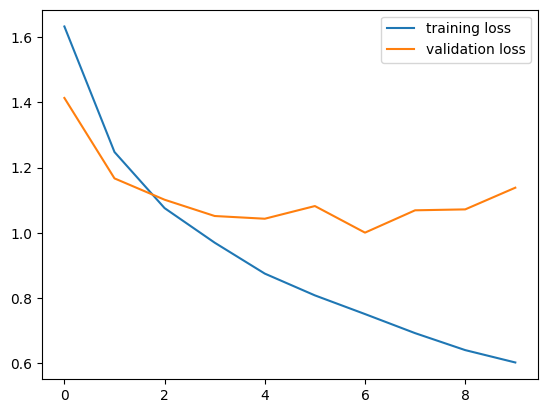

Test accuracy is  0.6638000011444092
Set momentgum in SGD optimizer as:  0.9


 10%|█         | 1/10 [00:14<02:09, 14.37s/it]

Epoch is 0 Avg CE (Train): 1.7905995845794678 Avg CE (Val): 1.6009327173233032 Accuracy (Val):  0.4152999818325043


 20%|██        | 2/10 [00:33<02:17, 17.22s/it]

Epoch is 1 Avg CE (Train): 1.6024960279464722 Avg CE (Val): 1.6030644178390503 Accuracy (Val):  0.42800000309944153


 30%|███       | 3/10 [00:51<02:01, 17.36s/it]

Epoch is 2 Avg CE (Train): 1.5311506986618042 Avg CE (Val): 1.628980278968811 Accuracy (Val):  0.4342999756336212


 40%|████      | 4/10 [01:14<01:58, 19.67s/it]

Epoch is 3 Avg CE (Train): 1.4981200695037842 Avg CE (Val): 1.5349029302597046 Accuracy (Val):  0.46779999136924744


 50%|█████     | 5/10 [01:31<01:34, 18.82s/it]

Epoch is 4 Avg CE (Train): 1.4626474380493164 Avg CE (Val): 1.590772032737732 Accuracy (Val):  0.4407999813556671


 60%|██████    | 6/10 [01:50<01:15, 18.83s/it]

Epoch is 5 Avg CE (Train): 1.4470096826553345 Avg CE (Val): 1.5241663455963135 Accuracy (Val):  0.47769999504089355


 70%|███████   | 7/10 [02:05<00:52, 17.57s/it]

Epoch is 6 Avg CE (Train): 1.4329620599746704 Avg CE (Val): 1.444806694984436 Accuracy (Val):  0.5018999576568604


 80%|████████  | 8/10 [02:26<00:37, 18.53s/it]

Epoch is 7 Avg CE (Train): 1.3940731287002563 Avg CE (Val): 1.537545084953308 Accuracy (Val):  0.4749999940395355


 90%|█████████ | 9/10 [02:45<00:18, 18.90s/it]

Epoch is 8 Avg CE (Train): 1.3847295045852661 Avg CE (Val): 1.5545533895492554 Accuracy (Val):  0.4626999795436859


100%|██████████| 10/10 [03:01<00:00, 18.11s/it]

Epoch is 9 Avg CE (Train): 1.361042857170105 Avg CE (Val): 1.529178261756897 Accuracy (Val):  0.48319998383522034


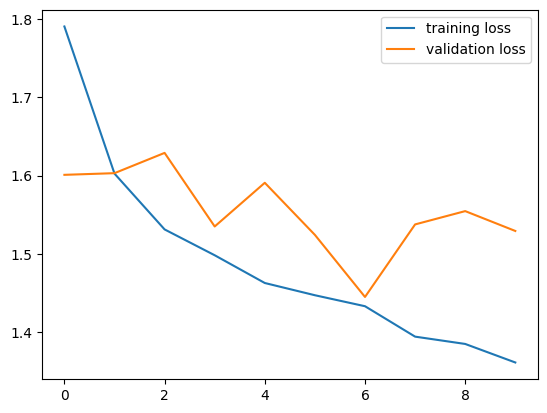

Test accuracy is  0.48499998450279236


In [ ]:
# momentum_list = [0.9]
momentum_list = [0.3, 0.6, 0.9]
for m in momentum_list:
  print("Set momentgum in SGD optimizer as: ", m)
  model = SimpleCNN_cifar()
  optimizer = torch.optim.SGD(model.parameters(), momentum=m, lr=0.1)
  device = torch.device('cuda')
  model.to(device)
  L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 10, device = device)
  plot_training_vs_val_loss(L_vals_train, L_vals_val)
  test_acc_gpu(model, dataloader_test, device)

When we increase momentum, the convergence speed and accuracy in test set will increase too but the loss will become more unstable. In this experiment, the best momentum parameter is 0.6 with 0.66 accuracy.

And by introducing momentum, the optimizer not only considers the current gradient but also the previous steps, smoothing the path taken by the optimizer. Because increasing the the momentum parameter let the optimizer places more weight on the accumulated past gradients, the model will recognize the patterns from image more swiftly. As a result, the convergence speed and accuracy on the test set often improve.

However, an overly high momentum may cause the optimizer to overshoot the minima and lead to an unstable loss. For example, the model does not find the local minima using the momentum parameter as 0.9 in this experiment because its test accuracy is similiar to MLP (below 0.5).

### 3.8.2 Experiment Adam

Use Adam optimizer


 10%|█         | 1/10 [00:15<02:18, 15.42s/it]

Epoch is 0 Avg CE (Train): 2.3074183464050293 Avg CE (Val): 2.308290481567383 Accuracy (Val):  0.10809999704360962


 20%|██        | 2/10 [00:31<02:08, 16.04s/it]

Epoch is 1 Avg CE (Train): 2.3076834678649902 Avg CE (Val): 2.307143211364746 Accuracy (Val):  0.1103999987244606


 30%|███       | 3/10 [00:46<01:46, 15.23s/it]

Epoch is 2 Avg CE (Train): 2.3073291778564453 Avg CE (Val): 2.308175802230835 Accuracy (Val):  0.10740000009536743


 40%|████      | 4/10 [01:00<01:29, 14.86s/it]

Epoch is 3 Avg CE (Train): 2.307441234588623 Avg CE (Val): 2.307753324508667 Accuracy (Val):  0.10830000042915344


 50%|█████     | 5/10 [01:15<01:13, 14.77s/it]

Epoch is 4 Avg CE (Train): 2.3077986240386963 Avg CE (Val): 2.306292772293091 Accuracy (Val):  0.11229999363422394


 60%|██████    | 6/10 [01:30<00:59, 14.85s/it]

Epoch is 5 Avg CE (Train): 2.3076765537261963 Avg CE (Val): 2.307481288909912 Accuracy (Val):  0.11599999666213989


 70%|███████   | 7/10 [01:46<00:46, 15.49s/it]

Epoch is 6 Avg CE (Train): 2.3077642917633057 Avg CE (Val): 2.3081166744232178 Accuracy (Val):  0.11029999703168869


 80%|████████  | 8/10 [02:01<00:30, 15.13s/it]

Epoch is 7 Avg CE (Train): 2.3070476055145264 Avg CE (Val): 2.307034969329834 Accuracy (Val):  0.11459999531507492


 90%|█████████ | 9/10 [02:15<00:14, 14.86s/it]

Epoch is 8 Avg CE (Train): 2.307617425918579 Avg CE (Val): 2.307741403579712 Accuracy (Val):  0.11339999735355377


100%|██████████| 10/10 [02:29<00:00, 15.00s/it]

Epoch is 9 Avg CE (Train): 2.30729341506958 Avg CE (Val): 2.3071861267089844 Accuracy (Val):  0.10509999841451645


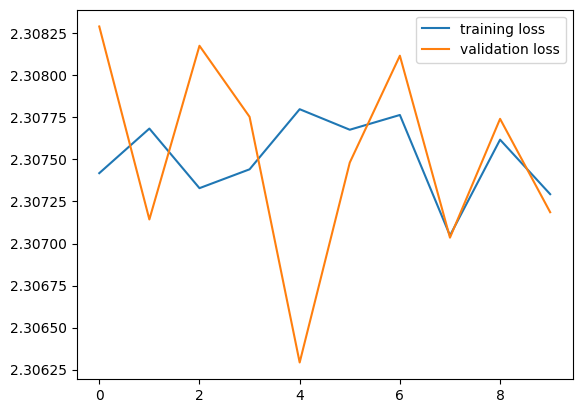

Test accuracy is  0.1087999939918518


In [ ]:
print("Use Adam optimizer")
model = SimpleCNN_cifar()
Optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
device = torch.device('cuda')
model.to(device)
L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 10, device = device)
plot_training_vs_val_loss(L_vals_train, L_vals_val)
test_acc_gpu(model, dataloader_test, device)

Adam's performance is significantly worse than SGD. One potential reason is Adam adjusts its learing rate based on the initial several gradient vectors which may derive the learning rate is not suitable for high dimension data like RGB images.

## 3.9 Pre-trained model

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Pre-trained model expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
training_data_cifar_pretrain = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data_cifar_pretrain = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)


# Split the dataset to train and val
dataset_train, dataset_val = train_val_split_tensors(training_data_cifar_pretrain, 0.8)
dataset_test = test_data_cifar_pretrain


# Load to DataLoader
dataloader_train, dataloader_val, dataloader_test = train_val_test_data_loader(dataset_train, dataset_val, dataset_test,
                                                                               batch_size=512)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# VGG-11 with one hidden layer
# 1. Load pre-trained VGG-11
model = vgg11(pretrained=True)

# 2. Freeze all layers (Include convs)
for param in model.features.parameters():
    param.requires_grad = False

# 3. Use new defined fully connected layers instead of the original ones
# Get number of input features of the first FC layer
num_features = model.classifier[0].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)  # CIFAR-10 has 10 classes
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 20%|██        | 1/5 [01:39<06:37, 99.38s/it]

Epoch is 0 Avg CE (Train): 0.940993070602417 Avg CE (Val): 0.628934383392334 Accuracy (Val):  0.7795000076293945


 40%|████      | 2/5 [03:20<05:01, 100.49s/it]

Epoch is 1 Avg CE (Train): 0.4643222987651825 Avg CE (Val): 0.6526238322257996 Accuracy (Val):  0.7670999765396118


 60%|██████    | 3/5 [04:59<03:19, 99.69s/it] 

Epoch is 2 Avg CE (Train): 0.3510127663612366 Avg CE (Val): 0.4478272795677185 Accuracy (Val):  0.8431999683380127


 80%|████████  | 4/5 [06:41<01:40, 100.62s/it]

Epoch is 3 Avg CE (Train): 0.28565293550491333 Avg CE (Val): 0.6224928498268127 Accuracy (Val):  0.7888000011444092


100%|██████████| 5/5 [08:19<00:00, 99.81s/it]

Epoch is 4 Avg CE (Train): 0.23932169377803802 Avg CE (Val): 0.5221322774887085 Accuracy (Val):  0.8255999684333801


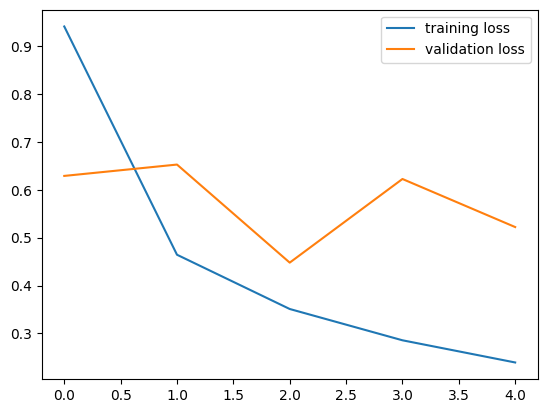

Test accuracy is  0.8174999952316284


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
device = torch.device('cuda')
model.to(device)

"""
# Test our model
x_batch, y_batch = next(iter(dataloader_train))
x_batch.shape
y_pred = model(x_batch)
y_pred.shape
"""

L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)

plot_training_vs_val_loss(L_vals_train, L_vals_val)
acc_list_vgg11 = []
acc_list_vgg11.append(test_acc_gpu(model, dataloader_test, device))

 20%|██        | 1/5 [01:38<06:35, 98.76s/it]

Epoch is 0 Avg CE (Train): 1.226932406425476 Avg CE (Val): 1.0930283069610596 Accuracy (Val):  0.6624999642372131


 40%|████      | 2/5 [03:18<04:57, 99.08s/it]

Epoch is 1 Avg CE (Train): 0.5647421479225159 Avg CE (Val): 0.5074536204338074 Accuracy (Val):  0.8188999891281128


 60%|██████    | 3/5 [04:57<03:18, 99.17s/it]

Epoch is 2 Avg CE (Train): 0.41236600279808044 Avg CE (Val): 0.5410603284835815 Accuracy (Val):  0.8066999912261963


 80%|████████  | 4/5 [06:36<01:39, 99.22s/it]

Epoch is 3 Avg CE (Train): 0.33109092712402344 Avg CE (Val): 0.5348089337348938 Accuracy (Val):  0.8091999888420105


100%|██████████| 5/5 [08:15<00:00, 99.20s/it]

Epoch is 4 Avg CE (Train): 0.28197720646858215 Avg CE (Val): 0.5649287700653076 Accuracy (Val):  0.8107999563217163


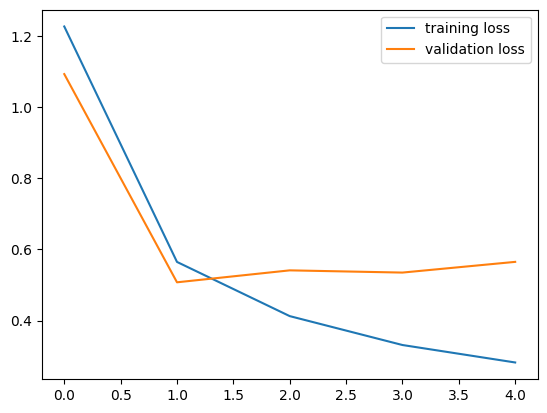

Test accuracy is  0.8046000003814697


In [ ]:
# VGG-11 with 2 hidden layers
# 1. Load pre-trained VGG-11
model = vgg11(pretrained=True)

# 2. Freeze all layers (Include convs)
for param in model.features.parameters():
    param.requires_grad = False

# 3. Use new defined fully connected layers instead of the original ones
# Get number of input features of the first FC layer
num_features = model.classifier[0].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)  # CIFAR-10 has 10 classes
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
device = torch.device('cuda')
model.to(device)

L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)

plot_training_vs_val_loss(L_vals_train, L_vals_val)
acc_list_vgg11.append(test_acc_gpu(model, dataloader_test, device))

 20%|██        | 1/5 [01:38<06:34, 98.52s/it]

Epoch is 0 Avg CE (Train): 1.708700180053711 Avg CE (Val): 1.0276414155960083 Accuracy (Val):  0.6237999796867371


 40%|████      | 2/5 [03:17<04:55, 98.60s/it]

Epoch is 1 Avg CE (Train): 0.8388295769691467 Avg CE (Val): 0.6546300649642944 Accuracy (Val):  0.7684999704360962


 60%|██████    | 3/5 [04:56<03:17, 98.71s/it]

Epoch is 2 Avg CE (Train): 0.5355775356292725 Avg CE (Val): 0.5041504502296448 Accuracy (Val):  0.8219999670982361


 80%|████████  | 4/5 [06:35<01:39, 99.03s/it]

Epoch is 3 Avg CE (Train): 0.4151541292667389 Avg CE (Val): 0.5065987706184387 Accuracy (Val):  0.819599986076355


100%|██████████| 5/5 [08:14<00:00, 98.92s/it]

Epoch is 4 Avg CE (Train): 0.3476276993751526 Avg CE (Val): 0.5224169492721558 Accuracy (Val):  0.8163999915122986


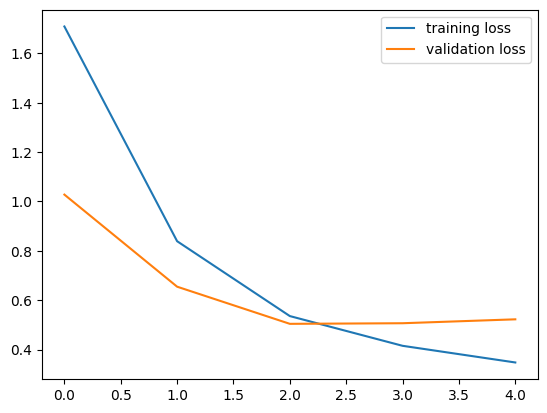

Test accuracy is  0.8202999830245972


In [ ]:
# VGG-11 with 3 hidden layers
# 1. Load pre-trained VGG-11
model = vgg11(pretrained=True)

# 2. Freeze all layers (Include convs)
for param in model.features.parameters():
    param.requires_grad = False

# 3. Use new defined fully connected layers instead of the original ones
# Get number of input features of the first FC layer
num_features = model.classifier[0].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)  # CIFAR-10 has 10 classes
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
device = torch.device('cuda')
model.to(device)

L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)

plot_training_vs_val_loss(L_vals_train, L_vals_val)
acc_list_vgg11.append(test_acc_gpu(model, dataloader_test, device))

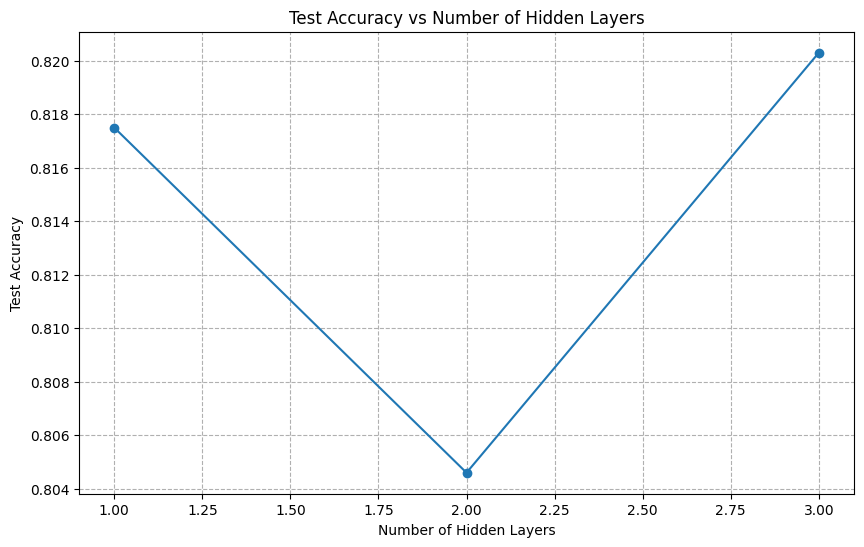

In [ ]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3], acc_list_vgg11, marker='o', linestyle='-')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Number of Hidden Layers')
plt.grid(True, which="both", ls="--")
plt.show()

https://towardsdatascience.com/how-to-use-a-pre-trained-model-vgg-for-image-classification-8dd7c4a4a517

Explaination: VGG models have a features section and a classifier section. The features section contains the convolutional layers, pooling layers, etc., while the classifier section contains the fully connected layers.

Conclusion: With two hidden layers and batch size as 512, pre-trained vgg11 model can achieve 0.82 accuracy using 5 epochs.

## 3.10 ResNet

 20%|██        | 1/5 [01:39<06:37, 99.46s/it]

Epoch is 0 Avg CE (Train): 1.5210155248641968 Avg CE (Val): 1.0924447774887085 Accuracy (Val):  0.6139999628067017


 40%|████      | 2/5 [03:26<05:10, 103.65s/it]

Epoch is 1 Avg CE (Train): 0.8382094502449036 Avg CE (Val): 0.776241660118103 Accuracy (Val):  0.7307999730110168


 60%|██████    | 3/5 [05:07<03:24, 102.45s/it]

Epoch is 2 Avg CE (Train): 0.7061784863471985 Avg CE (Val): 0.7237405180931091 Accuracy (Val):  0.7543999552726746


 80%|████████  | 4/5 [06:44<01:40, 100.35s/it]

Epoch is 3 Avg CE (Train): 0.6513230204582214 Avg CE (Val): 0.7362837195396423 Accuracy (Val):  0.7414000034332275


100%|██████████| 5/5 [08:21<00:00, 100.30s/it]

Epoch is 4 Avg CE (Train): 0.6221457123756409 Avg CE (Val): 0.7281301617622375 Accuracy (Val):  0.7459999918937683


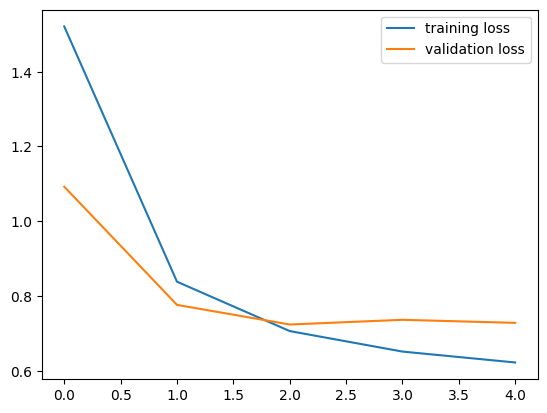

Test accuracy is  0.7404999732971191


In [ ]:
# ResNet-18 with one hidden layer
# 1. Load pre-trained ResNet-18
model = resnet18(pretrained=True)

# 2. Freeze all layers (Include convs)
for param in model.parameters():
    param.requires_grad = False

# 3. Use new defined fully connected layers instead of the original ones
# Get number of input features of the first FC layer
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)  # CIFAR-10 has 10 classes
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
device = torch.device('cuda')
model.to(device)

"""
# Test our model
x_batch, y_batch = next(iter(dataloader_train))
x_batch.shape
y_pred = model(x_batch)
y_pred.shape
"""

L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)

plot_training_vs_val_loss(L_vals_train, L_vals_val)
acc_list_resnet18 = []
acc_list_resnet18.append(test_acc_gpu(model, dataloader_test, device))

 20%|██        | 1/5 [01:37<06:29, 97.44s/it]

Epoch is 0 Avg CE (Train): 2.2303524017333984 Avg CE (Val): 2.0445754528045654 Accuracy (Val):  0.321399986743927


 40%|████      | 2/5 [03:15<04:53, 97.74s/it]

Epoch is 1 Avg CE (Train): 1.649245023727417 Avg CE (Val): 1.3408870697021484 Accuracy (Val):  0.4439999759197235


 60%|██████    | 3/5 [04:53<03:16, 98.12s/it]

Epoch is 2 Avg CE (Train): 1.1518964767456055 Avg CE (Val): 1.041145920753479 Accuracy (Val):  0.6146000027656555


 80%|████████  | 4/5 [06:31<01:38, 98.05s/it]

Epoch is 3 Avg CE (Train): 0.9357334971427917 Avg CE (Val): 0.9093260765075684 Accuracy (Val):  0.6714000105857849


100%|██████████| 5/5 [08:09<00:00, 97.95s/it]

Epoch is 4 Avg CE (Train): 0.8284591436386108 Avg CE (Val): 0.7997555136680603 Accuracy (Val):  0.7197999954223633


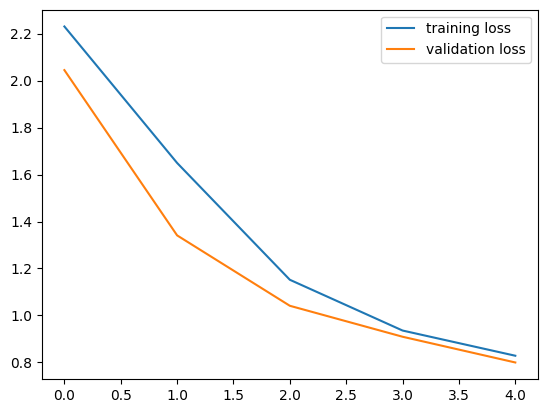

Test accuracy is  0.70660001039505


In [ ]:
# ResNet-18 with three hidden layers
# 1. Load pre-trained ResNet-18
model = resnet18(pretrained=True)

# 2. Freeze all layers (Include convs)
for param in model.parameters():
    param.requires_grad = False

# 3. Use new defined fully connected layers instead of the original ones
# Get number of input features of the first FC layer
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)  # CIFAR-10 has 10 classes
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
device = torch.device('cuda')
model.to(device)

"""
# Test our model
x_batch, y_batch = next(iter(dataloader_train))
x_batch.shape
y_pred = model(x_batch)
y_pred.shape
"""

L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)

plot_training_vs_val_loss(L_vals_train, L_vals_val)
acc_list_resnet18.append(test_acc_gpu(model, dataloader_test, device))

 20%|██        | 1/5 [01:39<06:37, 99.29s/it]

Epoch is 0 Avg CE (Train): 1.1738284826278687 Avg CE (Val): 0.8770849108695984 Accuracy (Val):  0.7076999545097351


 40%|████      | 2/5 [03:16<04:54, 98.24s/it]

Epoch is 1 Avg CE (Train): 0.7458696365356445 Avg CE (Val): 0.7958311438560486 Accuracy (Val):  0.7242000102996826


 60%|██████    | 3/5 [04:53<03:15, 97.61s/it]

Epoch is 2 Avg CE (Train): 0.6704947352409363 Avg CE (Val): 0.7216993570327759 Accuracy (Val):  0.7511999607086182


 80%|████████  | 4/5 [06:31<01:37, 97.79s/it]

Epoch is 3 Avg CE (Train): 0.6340878009796143 Avg CE (Val): 0.6921160221099854 Accuracy (Val):  0.7590999603271484


100%|██████████| 5/5 [08:08<00:00, 97.80s/it]

Epoch is 4 Avg CE (Train): 0.6119802594184875 Avg CE (Val): 0.6513608694076538 Accuracy (Val):  0.7766000032424927


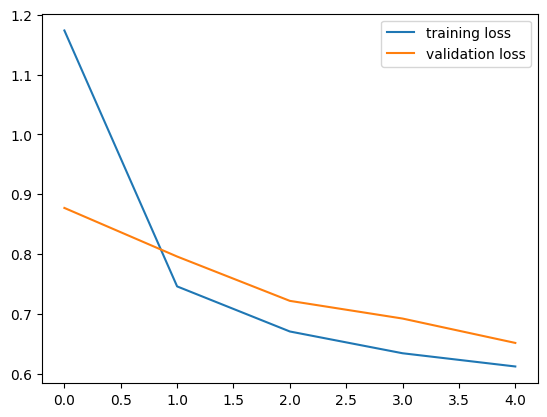

Test accuracy is  0.7727999687194824


In [ ]:
# ResNet-18 with zero hidden layer
# 1. Load pre-trained ResNet-18
model = resnet18(pretrained=True)

# 2. Freeze all layers (Include convs)
for param in model.parameters():
    param.requires_grad = False

# 3. Use new defined fully connected layers instead of the original ones
# Get number of input features of the first FC layer
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 10),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
device = torch.device('cuda')
model.to(device)

"""
# Test our model
x_batch, y_batch = next(iter(dataloader_train))
x_batch.shape
y_pred = model(x_batch)
y_pred.shape
"""

L_vals_train, L_vals_val = train_gpu(model, dataloader_train, dataloader_val, num_epochs = 5, device = device)

plot_training_vs_val_loss(L_vals_train, L_vals_val)
acc_list_resnet18.append(test_acc_gpu(model, dataloader_test, device))

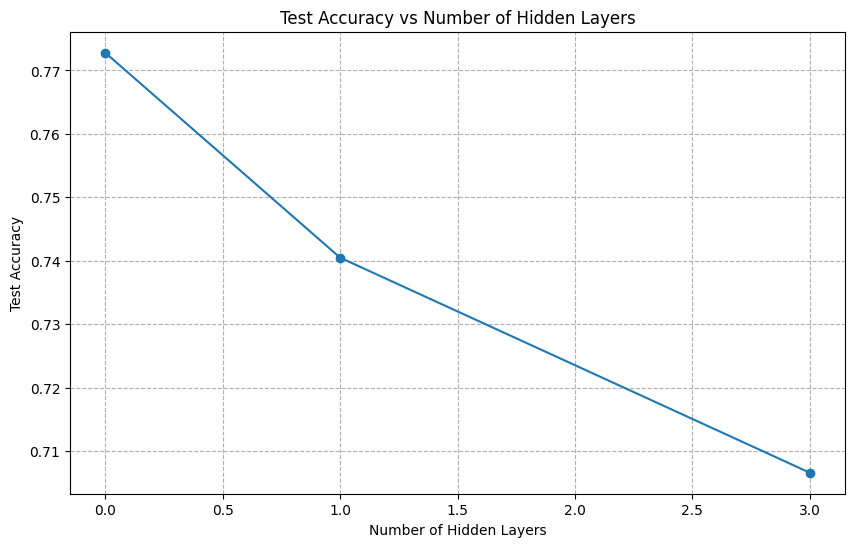

In [ ]:
plt.figure(figsize=(10,6))
plt.plot([0,1,3], [acc_list_resnet18[2],acc_list_resnet18[0],acc_list_resnet18[1]], marker='o', linestyle='-')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Number of Hidden Layers')
plt.grid(True, which="both", ls="--")
plt.show()

Reference: https://ijcrt.org/papers/IJCRT2205235.pdf

With one fully connected layer and batch size as 512, pre-trained ResNet18 model can achieve 0.77 accuracy using 5 epochs. We observed that adding hidde layers make ResNet18's performance worse because original ResNet18 model only has one single linear layer to reduce the risk of overfitting from minizing the parameters.